# MITBIH NOISE 생성

In [2]:
import numpy as np
import wfdb
import _pickle as pickle

import pickle

In [3]:
def compute_target_noise_power(Px, snr_db):
    """SNR을 고려하여 목표 노이즈 파워 Pn 계산"""
    return Px / (10 ** (snr_db / 10))

def compute_actual_noise_power(noise):
    """전체 노이즈 신호의 실제 파워 P_n 계산"""
    return np.mean(noise ** 2)  # 전체 샘플에 대한 파워 계산

def compute_scale_factor(Pn, Pn_actual):
    """SNR을 적용하기 위한 스케일 팩터 계산"""
    return np.sqrt(Pn / Pn_actual)

def apply_snr_to_noise(px_value, Pn_actual, noise, snr_db):
    """
    클린 ECG의 신호 파워(Px)를 기반으로
    주어진 SNR(dB)에 맞춰 노이즈의 파워를 조정
    """
    # P_x = np.mean(clean_ecg ** 2, axis=1, keepdims=True)  # (num_samples, 1, 1)
    Pn = compute_target_noise_power(px_value, snr_db)
    # Pn_actual = compute_actual_noise_power(noise)
    scale_factor = compute_scale_factor(Pn, Pn_actual)
    return noise * scale_factor

In [4]:
NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'
"""
BW, EM, MA 노이즈에 대해 여러 SNR 값(-6, 0, 6, 12, 18 dB)로 변환 후 저장.
원본 노이즈 shape: (2, 650000, 1) 유지
"""
# NSTDB에서 노이즈 로드 (Baseline Wander, Electrode Motion, Muscle Artifact)
bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
bw_signals.shape, em_signals.shape, ma_signals.shape  
print(f"Baseline Wander Noise: {bw_signals.shape}")
print(f"Electrode Motion Noise: {em_signals.shape}")
print(f"Muscle Artifact Noise: {ma_signals.shape}")
Pn_bw, Pn_em, Pn_ma = 0, 0, 0  
for channel in range(2):
    bw_noise = bw_signals[:, channel]
    em_noise = em_signals[:, channel]
    ma_noise = ma_signals[:, channel]            
    Pn_bw += compute_actual_noise_power(bw_noise)  
    Pn_em += compute_actual_noise_power(em_noise)  
    Pn_ma += compute_actual_noise_power(ma_noise)  
pn_bw= Pn_bw / 2
pn_em= Pn_em / 2
pn_ma= Pn_ma / 2
print(f"Baseline Wander Noise Power: {pn_bw:.4f}")
print(f"Electrode Motion Noise Power: {pn_em:.4f}") 


Baseline Wander Noise: (650000, 2)
Electrode Motion Noise: (650000, 2)
Muscle Artifact Noise: (650000, 2)
Baseline Wander Noise Power: 0.1244
Electrode Motion Noise Power: 0.2875


In [5]:
import numpy as np
import wfdb
import pickle
px_value_mit = 0.19774412823369134

def prepare_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    BW, EM, MA 노이즈에 대해 여러 SNR 값(-6, 0, 6, 12, 18 dB)로 변환 후 저장.
    원본 노이즈 shape: (2, 650000, 1) 유지
    """
    # NSTDB에서 노이즈 로드 (Baseline Wander, Electrode Motion, Muscle Artifact)
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    # SNR 레벨 정의
    snr_levels = [-6,0, 6, 12, 18]
    seed = 1234
    np.random.seed(seed)  
    for snr_db in snr_levels:
        bw_adjusted = np.zeros((2, 650000))
        em_adjusted = np.zeros((2, 650000))
        ma_adjusted = np.zeros((2, 650000))
        for channel in range(2):     
            bw_adjusted[channel, :] = apply_snr_to_noise(px_value_mit, pn_bw, bw_signals[:, channel], snr_db)
            em_adjusted[channel, :] = apply_snr_to_noise(px_value_mit, pn_em, em_signals[:, channel], snr_db)
            ma_adjusted[channel, :] = apply_snr_to_noise(px_value_mit, pn_ma, ma_signals[:, channel], snr_db)   
            # 저장 (pickle 파일)
        bw_adjusted = np.expand_dims(bw_adjusted, axis=-1)
        em_adjusted = np.expand_dims(em_adjusted, axis=-1)
        ma_adjusted = np.expand_dims(ma_adjusted, axis=-1)
        print(bw_adjusted.shape)
        with open(f'data2/BW_Noise_SNR_{snr_db}.pkl', 'wb') as f:
            pickle.dump(bw_adjusted, f)
        with open(f'data2/EM_Noise_SNR_{snr_db}.pkl', 'wb') as f:
            pickle.dump(em_adjusted, f)
        with open(f'data2/MA_Noise_SNR_{snr_db}.pkl', 'wb') as f:
            pickle.dump(ma_adjusted, f)    
        print(f"[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = {snr_db} dB)")    
    print("[INFO] 모든 SNR 변환 및 저장 완료!")
# 실행
prepare_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')


(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = -6 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = 0 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = 6 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = 12 dB)
(2, 650000, 1)
[INFO] BW, EM, MA 노이즈 저장 완료 (SNR = 18 dB)
[INFO] 모든 SNR 변환 및 저장 완료!


In [6]:
import numpy as np
import pickle

def load_noise(noise_type, snr_db, base_path='data2/'):
    """
    SNR별 BW, EM, MA 노이즈를 불러오는 함수
    """
    with open(f'{base_path}{noise_type}_Noise_SNR_{snr_db}.pkl', 'rb') as f:
        noise = pickle.load(f)  # Shape: (2, 650000, 1)
    return noise.squeeze(-1)  # Shape: (2, 650000)

def generate_mixed_noise():
    """
    SNR별 BW, EM, MA 노이즈를 합쳐서 "완전 혼합 노이즈" 생성 및 저장
    """
    snr_levels = [-6, 0, 6, 12, 18]
    total_samples = 650000
    
    for snr_db in snr_levels:
        # 개별 SNR 노이즈 로드 (Shape: (2, 650000))
        bw_noise = load_noise('BW', snr_db)
        em_noise = load_noise('EM', snr_db)
        ma_noise = load_noise('MA', snr_db)

        # **모든 노이즈를 합쳐서 "완전 혼합 노이즈" 생성**
        mixed_noise = bw_noise + em_noise + ma_noise  # (2, 650000)

        # 차원 확장하여 (2, 650000, 1) 형태로 저장
        mixed_noise = np.expand_dims(mixed_noise, axis=-1)

        # 저장 (pickle 파일)
        with open(f'data2/Mixed_Noise_SNR_{snr_db}.pkl', 'wb') as f:
            pickle.dump(mixed_noise, f)

        print(f"[INFO] 완전 혼합 노이즈 저장 완료 (SNR = {snr_db} dB)")

    print("[INFO] 모든 SNR에 대해 완전 혼합 노이즈 저장 완료!")

# 실행
generate_mixed_noise()


[INFO] 완전 혼합 노이즈 저장 완료 (SNR = -6 dB)
[INFO] 완전 혼합 노이즈 저장 완료 (SNR = 0 dB)
[INFO] 완전 혼합 노이즈 저장 완료 (SNR = 6 dB)
[INFO] 완전 혼합 노이즈 저장 완료 (SNR = 12 dB)
[INFO] 완전 혼합 노이즈 저장 완료 (SNR = 18 dB)
[INFO] 모든 SNR에 대해 완전 혼합 노이즈 저장 완료!


In [39]:

import numpy as np
import pandas as pd
import pickle

with open('data2/Mixed_Noise_SNR_-6.pkl', 'rb') as input:
    static_noise = pickle.load(input)

# NumPy 배열인 경우
if isinstance(static_noise, np.ndarray):
    final_arr = np.squeeze(static_noise)[0]
    print("Shape of static_noise (NumPy array):", final_arr.shape)

# Pandas DataFrame인 경우
elif isinstance(static_noise, pd.DataFrame):
    print("Shape of static_noise (Pandas DataFrame):", static_noise.shape)

# 다른 데이터 구조인 경우
else:
    print("static_noise is of type:", type(static_noise))

Shape of static_noise (NumPy array): (650000,)


In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# SNR 레벨
snr_levels = [-6,  0,6, 12, 18]
base_path = 'data2/'

def load_mixed_noise(snr_db):
    """ SNR별 혼합 노이즈 파일 불러오기 """
    with open(f'{base_path}Mixed_Noise_SNR_{snr_db}.pkl', 'rb') as f:
        noise = pickle.load(f)  # (2, 650000, 1)
    return noise.squeeze(-1)  # (2, 650000)

# 모든 데이터 로드하여 Y축 범위 확인
all_noises = [load_mixed_noise(snr) for snr in snr_levels]

# Y축 범위 계산 (모든 SNR에서 최대/최소값 찾기)
y_min = min(noise.min() for noise in all_noises)
y_max = max(noise.max() for noise in all_noises)

# 시각화
fig, axes = plt.subplots(len(snr_levels), 1, figsize=(12, 10), sharex=True, sharey=True)

for i, snr in enumerate(snr_levels):
    mixed_noise = all_noises[i]
    
    axes[i].plot(mixed_noise[0, :], label=f"SNR {snr} dB", alpha=0.8)
    axes[i].set_title(f"SNR {snr} dB - Mixed Noise (BW+EM+MA)")
    axes[i].set_ylabel("Amplitude")
    axes[i].set_ylim(y_min, y_max)  # Y축 동일하게 설정
    axes[i].legend(loc="upper right")

plt.xlabel("Samples (Time Domain)")
plt.tight_layout()
plt.show()


In [9]:
import numpy as np
import pickle
import wfdb

def load_noise(noise_type, snr_db, base_path='data2/'):
    """
    SNR별 BW, EM, MA 노이즈를 불러오는 함수
    """
    with open(f'{base_path}{noise_type}_Noise_SNR_{snr_db}.pkl', 'rb') as f:
        noise = pickle.load(f)  # Shape: (2, 650000, 1)
    return noise.squeeze(-1)  # Shape: (2, 650000)

def generate_combined_noise():
    """
    Chunk 단위로 BW, EM, MA 노이즈를 합쳐서 Train/Test 데이터 생성
    """
    snr_values = [-6,0,6, 12, 18]
    chunk_size = 10000
    total_samples = 650000
    num_chunks = total_samples // chunk_size
    
    combined_train = np.zeros((2, total_samples))
    combined_test = np.zeros((2, total_samples))
    
    np.random.seed(1234)  # Seed 설정
    
    for chunk_idx in range(num_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = start_idx + chunk_size
        
        # Random SNR 선택
        bw_snr = np.random.choice(snr_values)
        em_snr = np.random.choice(snr_values)
        ma_snr = np.random.choice(snr_values)
        
        # 해당 SNR의 노이즈 불러오기
        bw_noise = load_noise('BW', bw_snr)[:, start_idx:end_idx]
        em_noise = load_noise('EM', em_snr)[:, start_idx:end_idx]
        ma_noise = load_noise('MA', ma_snr)[:, start_idx:end_idx]
        
        # 채널별 합산하여 혼합 노이즈 생성
        mixed_noise = bw_noise + em_noise + ma_noise
        
        # Train / Test Split (Half and Half)
        if chunk_idx < num_chunks // 2:
            combined_train[:, start_idx:end_idx] = mixed_noise
        else:
            combined_test[:, start_idx:end_idx] = mixed_noise
    
    # 차원 확장하여 (2, 650000, 1) 형태로 저장
    combined_train = np.expand_dims(combined_train, axis=-1)
    combined_test = np.expand_dims(combined_test, axis=-1)
    
    with open('data2/CombinedNoise_Train.pkl', 'wb') as f:
        pickle.dump(combined_train, f)
    with open('data2/CombinedNoise_Test.pkl', 'wb') as f:
        pickle.dump(combined_test, f)
    
    print("[INFO] Combined Noise Train/Test 저장 완료!")

# 실행
generate_combined_noise()

import pickle
import numpy as np

# Load the data
with open('data2/CombinedNoise_Train.pkl', 'rb') as f:
    train_noise = pickle.load(f)  # Shape: (2, 650000, 1)

with open('data2/CombinedNoise_Test.pkl', 'rb') as f:
    test_noise = pickle.load(f)  # Shape: (2, 650000, 1)

# Calculate the half-length
total_length = train_noise.shape[1]  # 650000 samples
half_length = total_length // 2

# Combine the first half of train_noise with the second half of test_noise for each channel
combined_channel_0 = np.concatenate((train_noise[0, :half_length], test_noise[0, half_length:]), axis=0)
combined_channel_1 = np.concatenate((train_noise[1, :half_length], test_noise[1, half_length:]), axis=0)

# Reshape to (650000,)
combined_channel_0 = combined_channel_0.squeeze()  # Shape: (650000,)
combined_channel_1 = combined_channel_1.squeeze()  # Shape: (650000,)

# Save combined_channel_0 as CombinedNoise_Train.pkl
with open('data2/CombinedNoise_Train.pkl', 'wb') as f:
    pickle.dump(combined_channel_0, f)

# Save combined_channel_1 as CombinedNoise_Test.pkl
with open('data2/CombinedNoise_Test.pkl', 'wb') as f:
    pickle.dump(combined_channel_1, f)

print("Saved combined_channel_0 as CombinedNoise_Train.pkl with shape:", combined_channel_0.shape)
print("Saved combined_channel_1 as CombinedNoise_Test.pkl with shape:", combined_channel_1.shape)


[INFO] Combined Noise Train/Test 저장 완료!
Saved combined_channel_0 as CombinedNoise_Train.pkl with shape: (650000,)
Saved combined_channel_1 as CombinedNoise_Test.pkl with shape: (650000,)


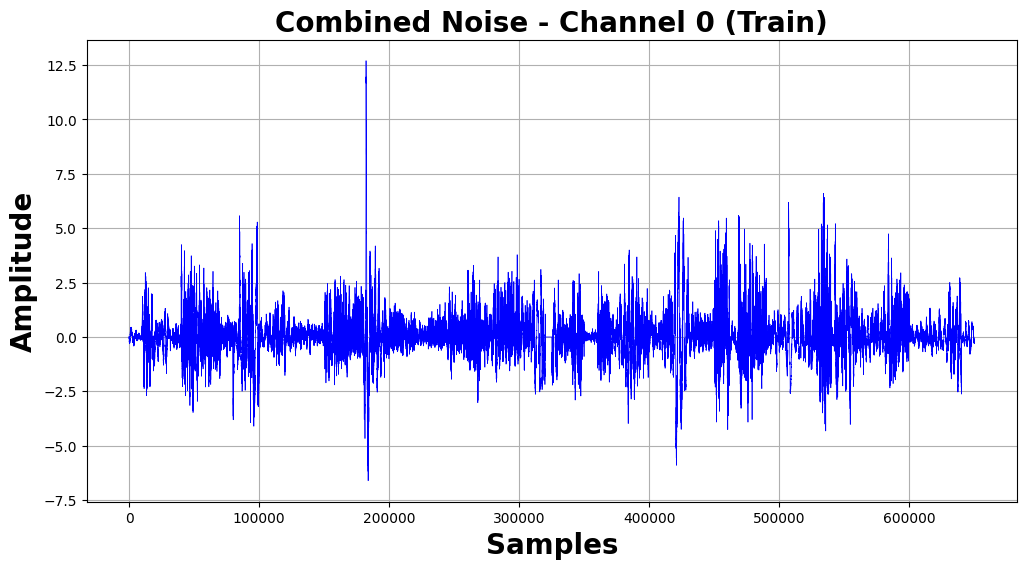

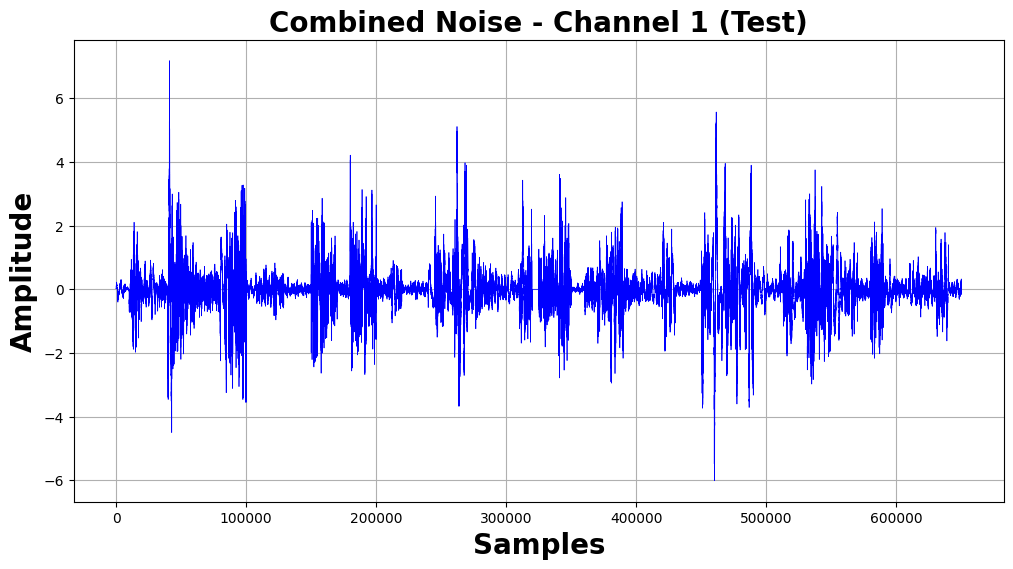

In [36]:
import matplotlib.pyplot as plt

def plot_noise(data, title, xlabel="Samples", ylabel="Amplitude"):
    plt.figure(figsize=(12, 6))
    plt.plot(data, color='blue', linewidth=0.5)
    
    # 제목과 레이블의 글꼴을 80포인트로 하고 굵게 설정
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel(xlabel, fontsize=20, fontweight='bold')
    plt.ylabel(ylabel, fontsize=20, fontweight='bold')
    
    plt.grid(True)
    plt.show()

# combined_channel_0 시각화 (CombinedNoise_Train.pkl)
plot_noise(combined_channel_0, "Combined Noise - Channel 0 (Train)")

# combined_channel_1 시각화 (CombinedNoise_Test.pkl)
plot_noise(combined_channel_1, "Combined Noise - Channel 1 (Test)")

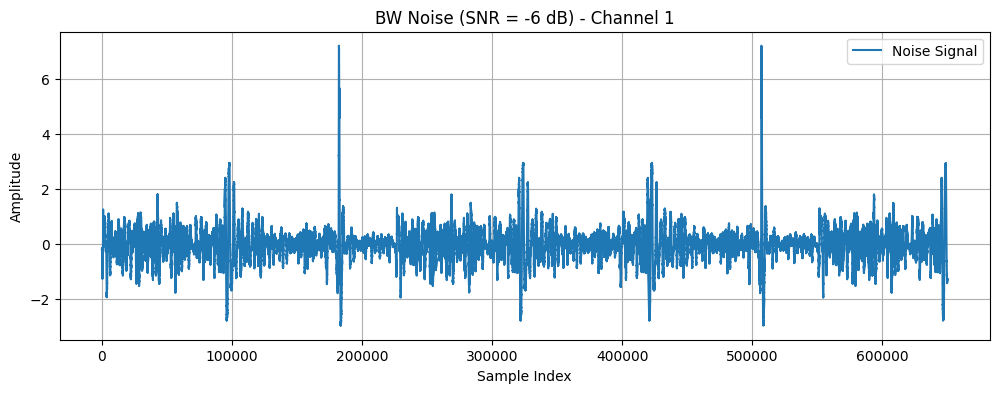

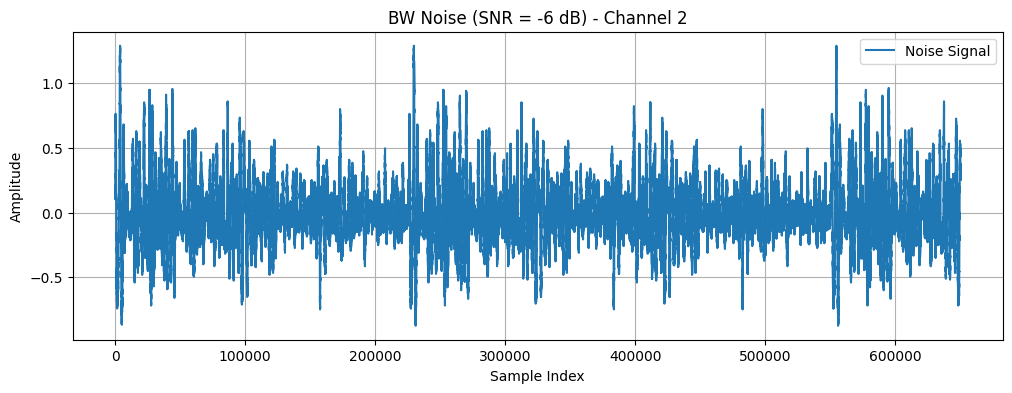

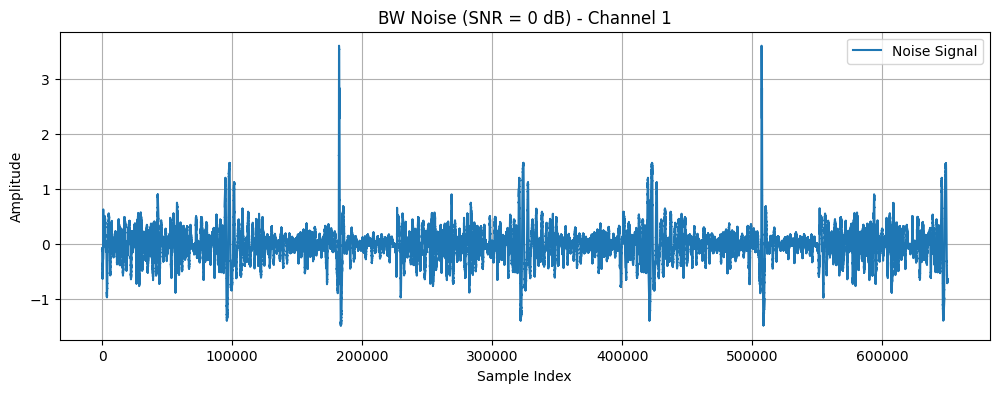

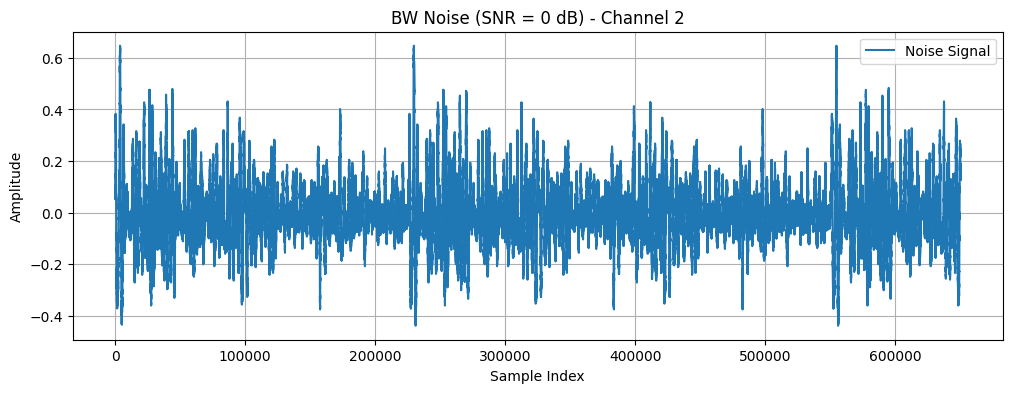

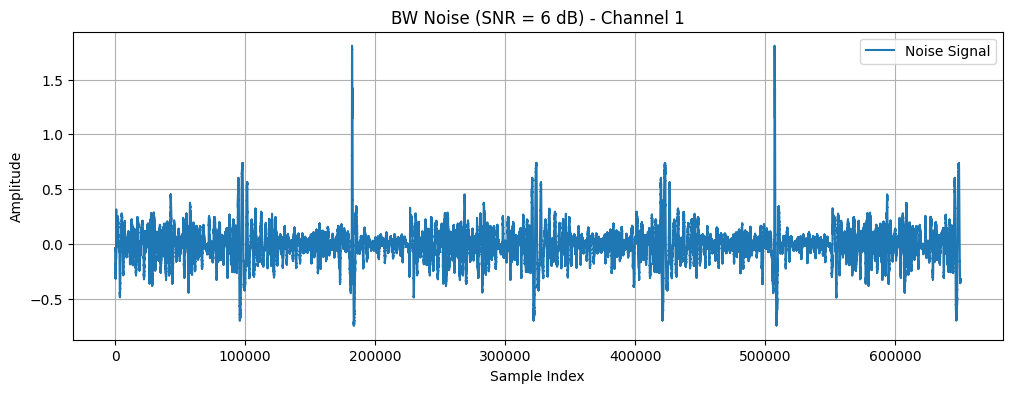

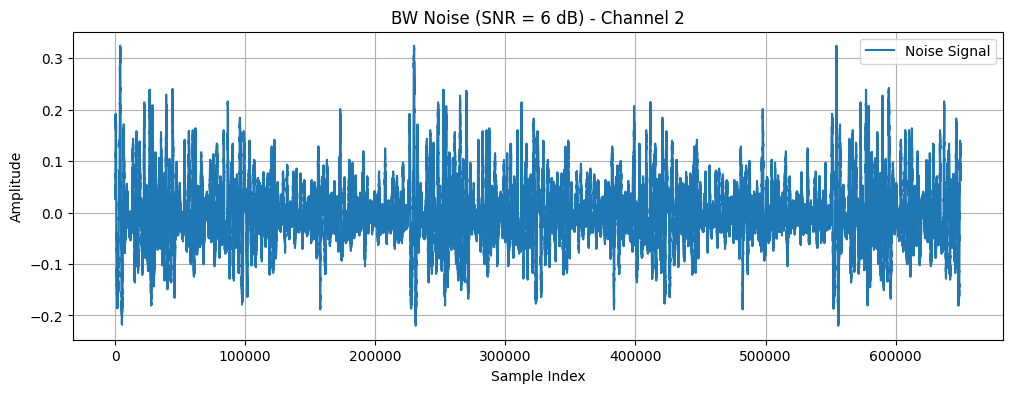

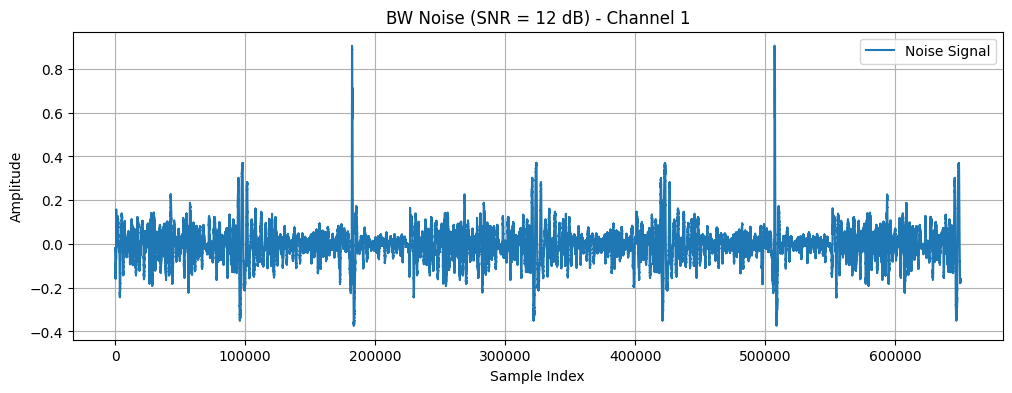

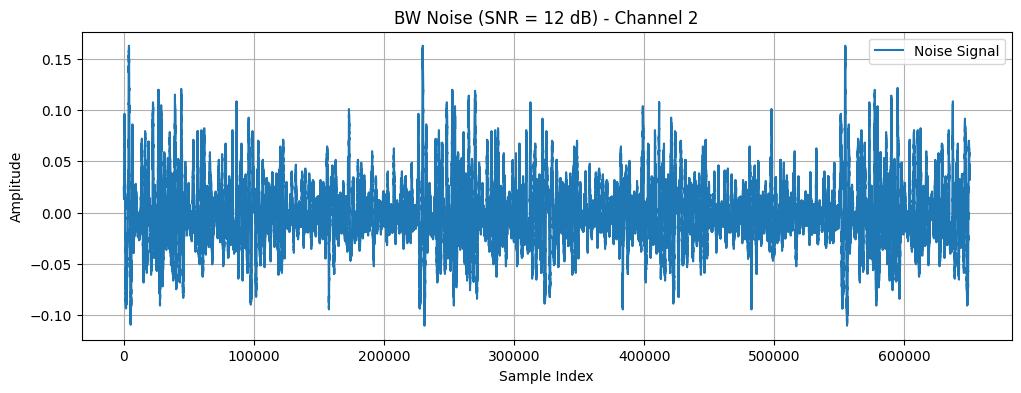

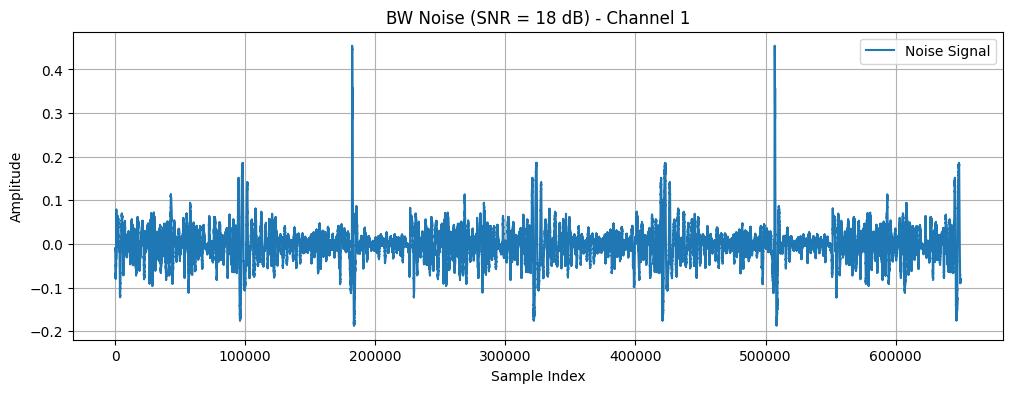

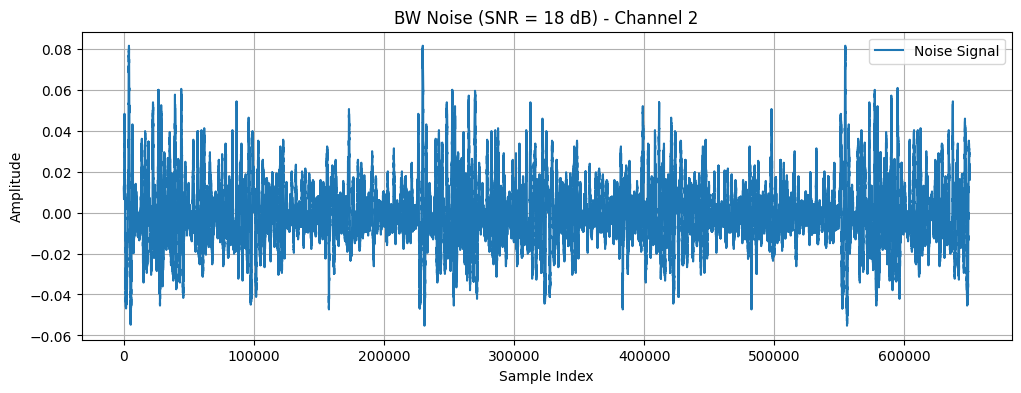

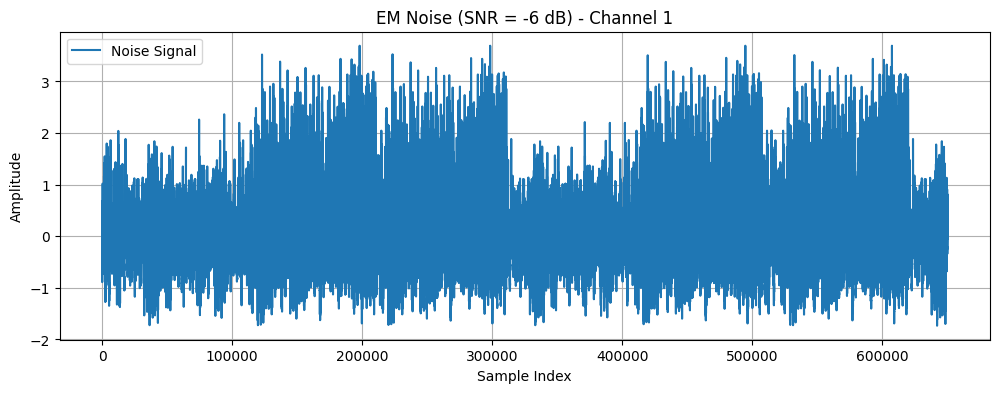

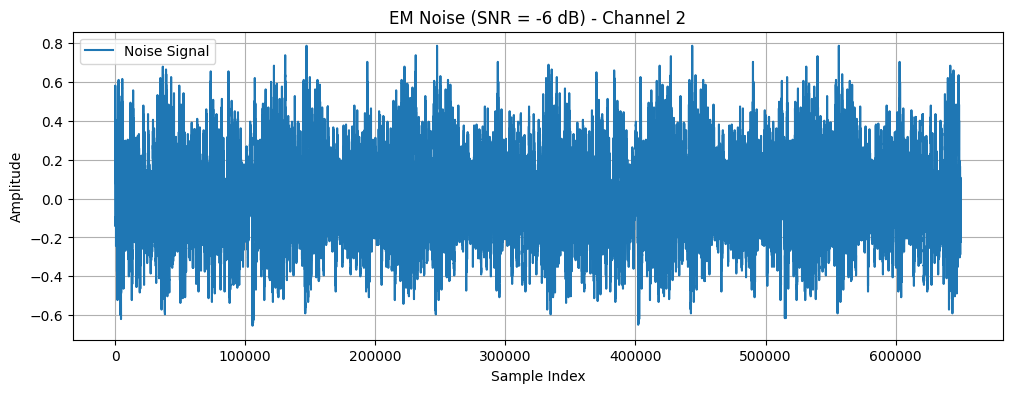

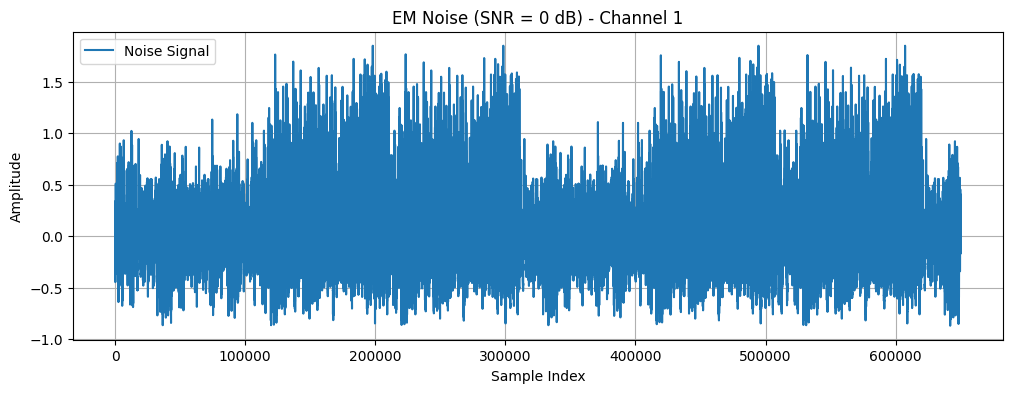

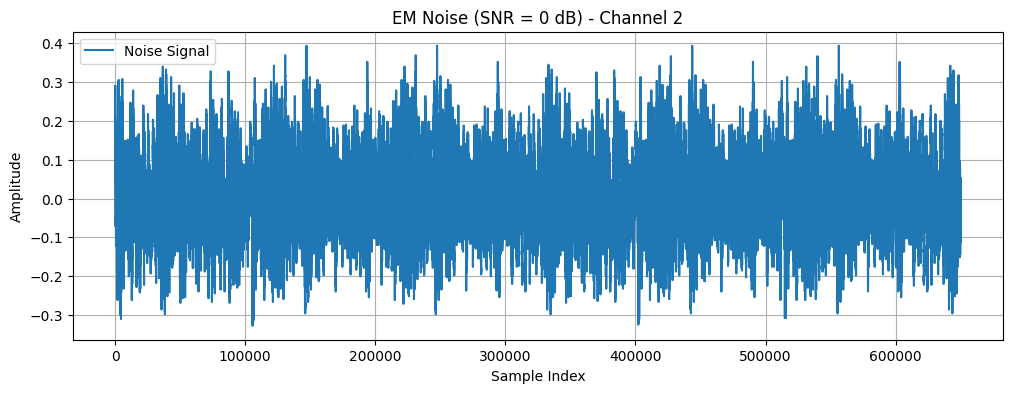

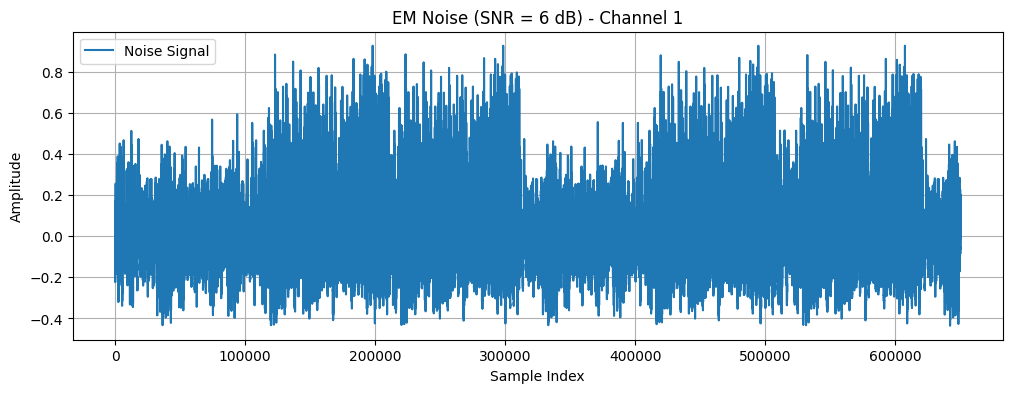

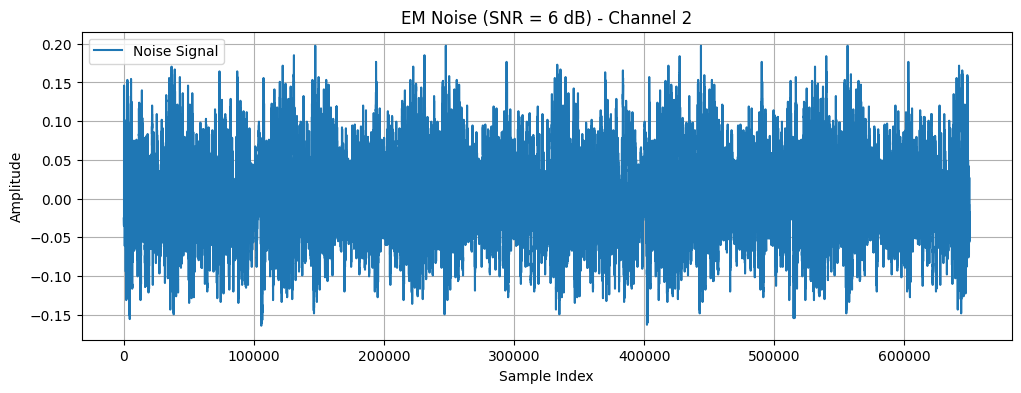

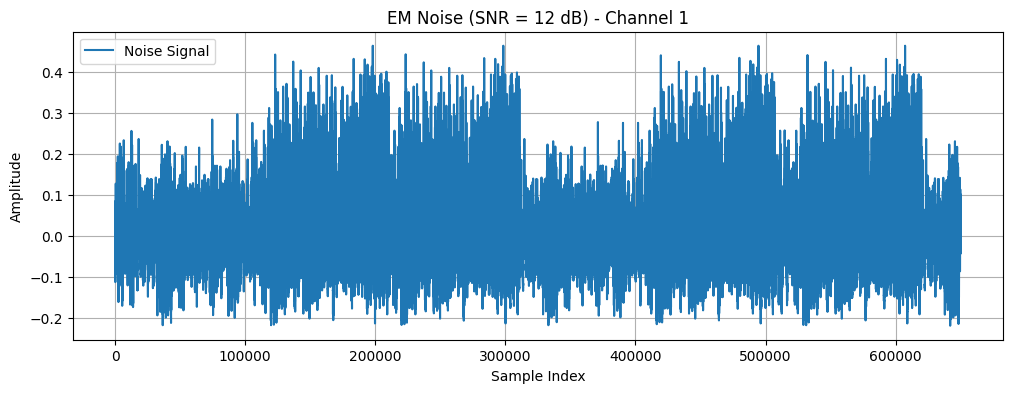

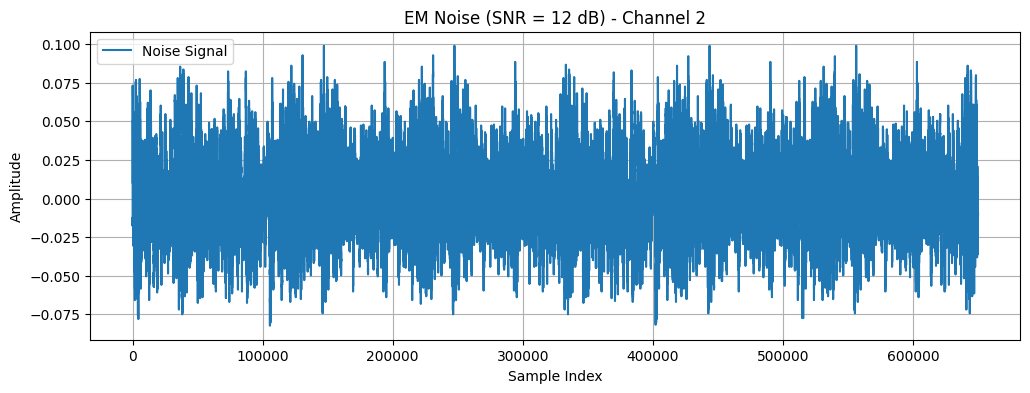

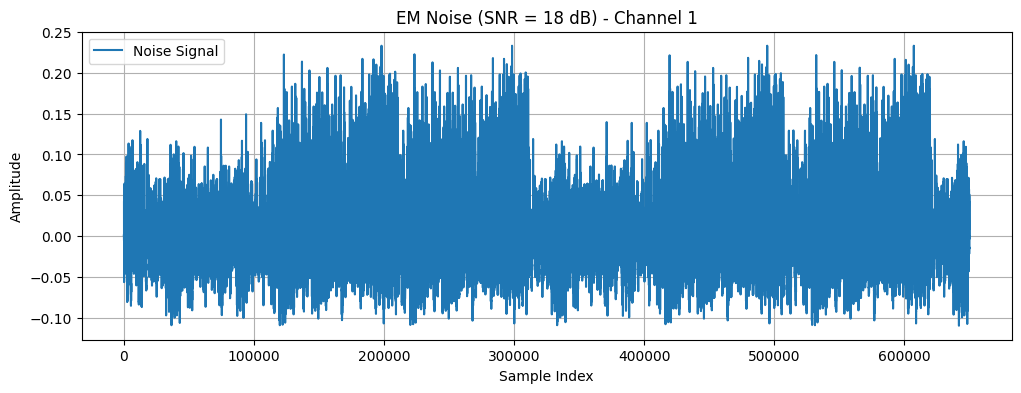

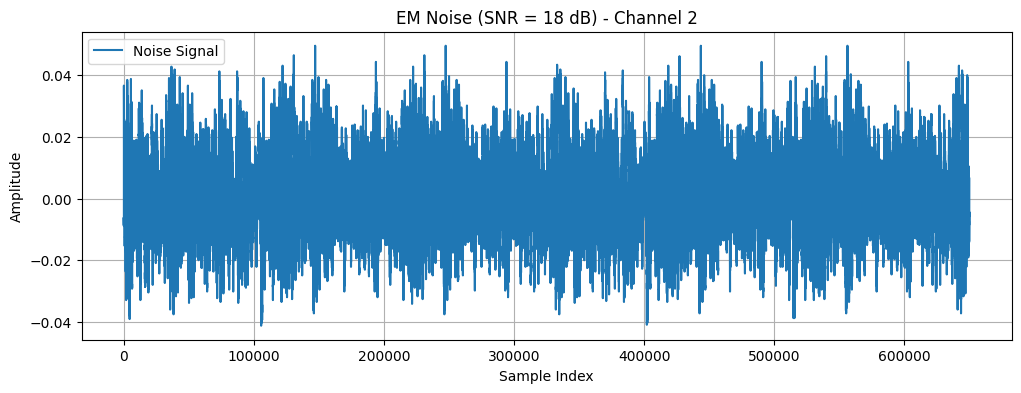

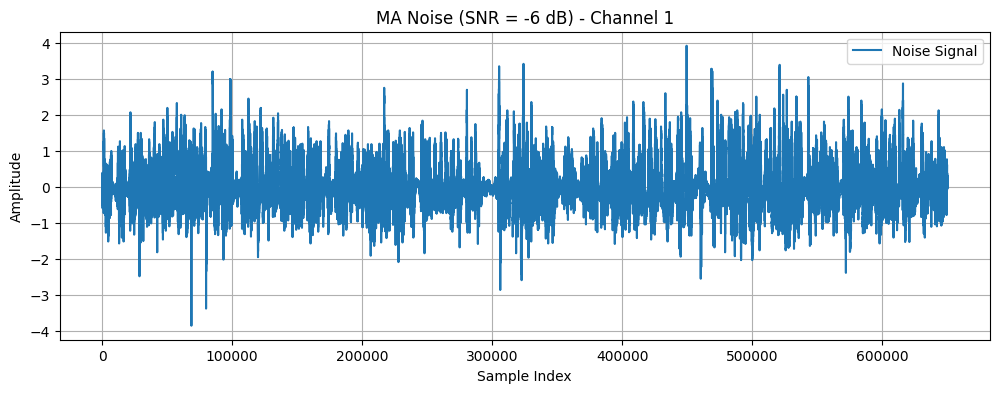

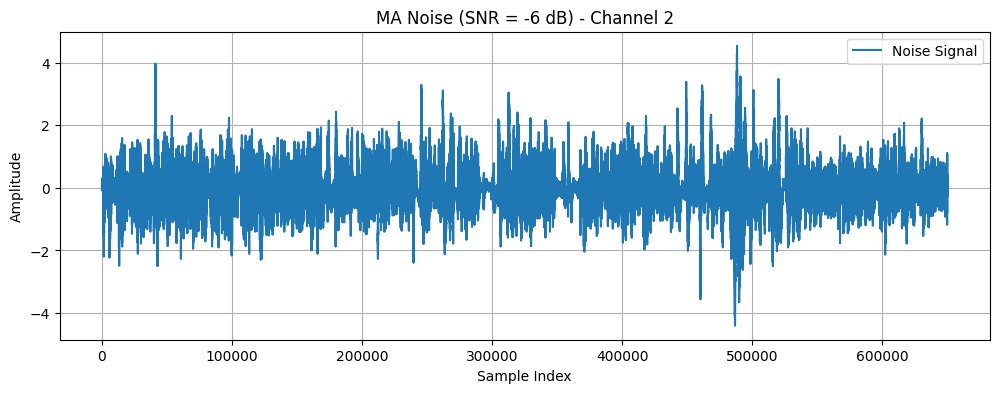

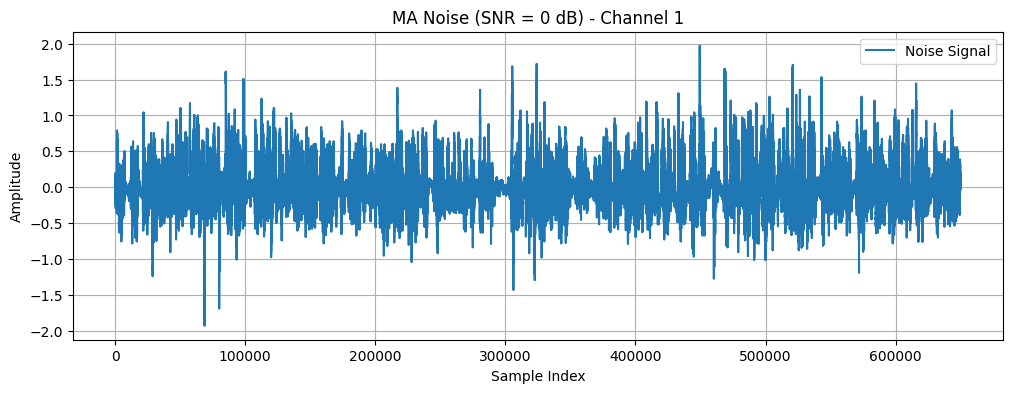

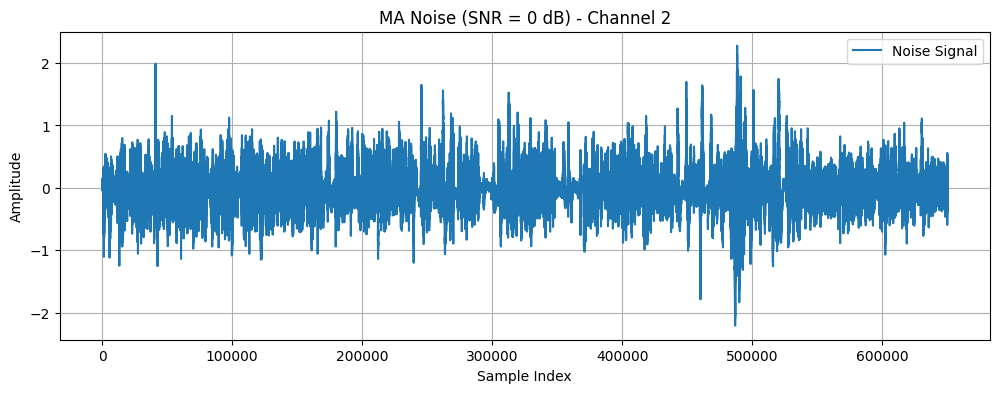

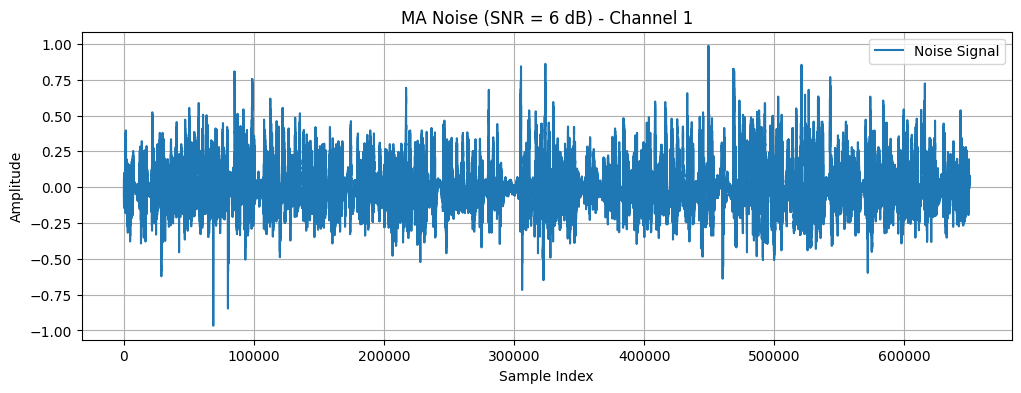

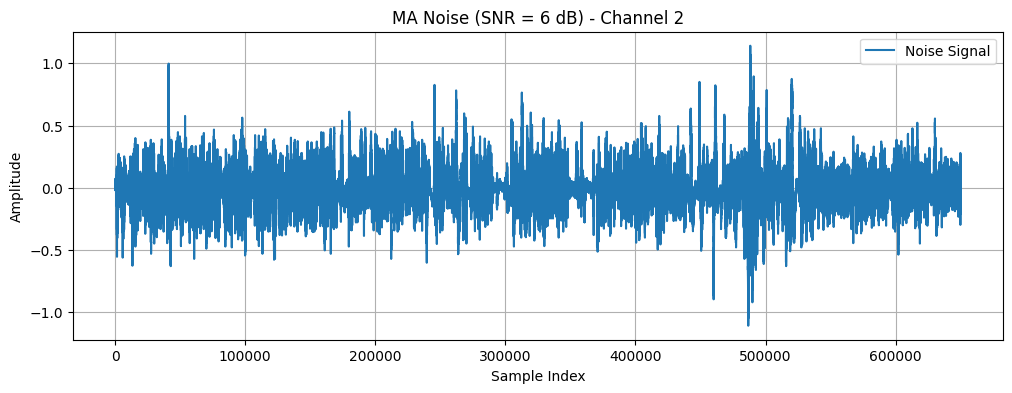

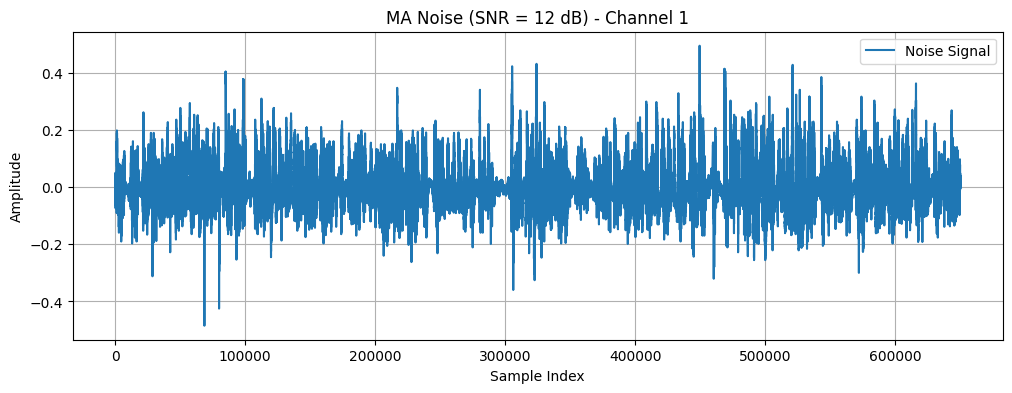

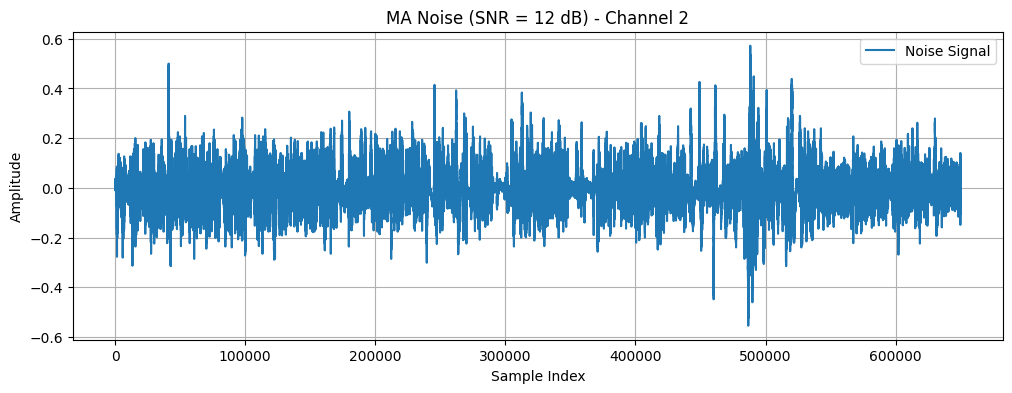

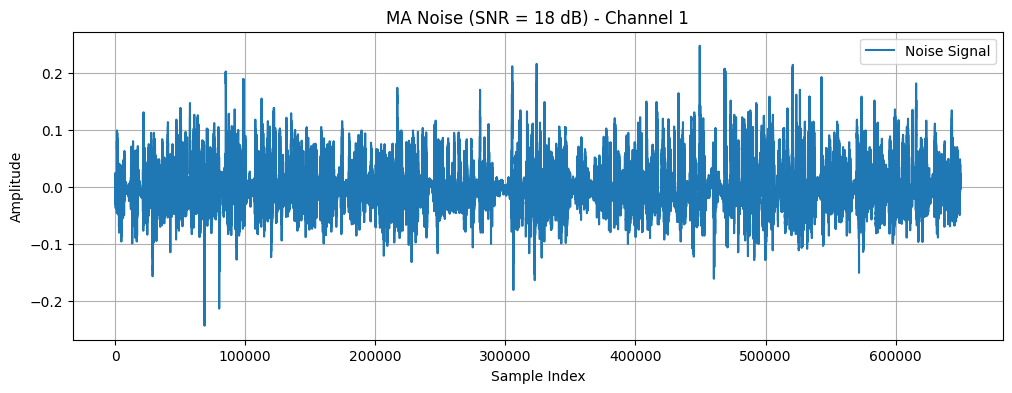

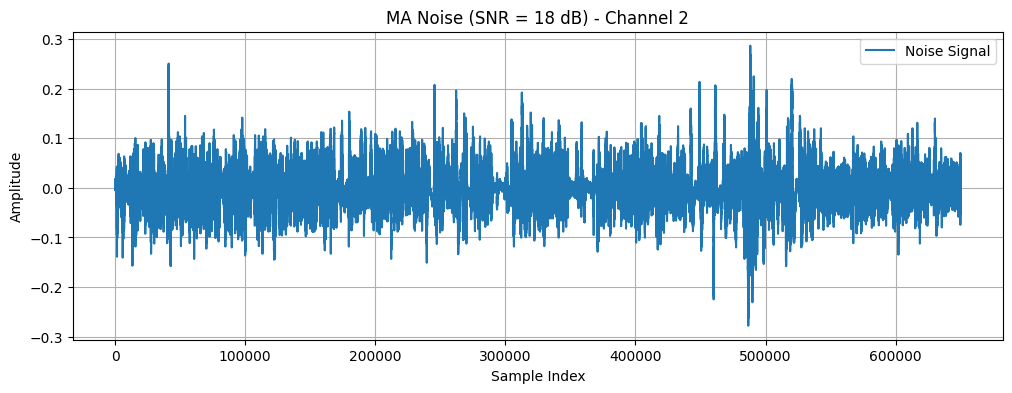

[INFO] 모든 노이즈 시각화 완료!


In [43]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 시각화 함수
def plot_noise_sample(noise, title, sample_range=(0, 650000)):
    """
    특정 범위의 노이즈 신호를 시각화하는 함수
    """
    plt.figure(figsize=(12, 4))
    plt.plot(noise[sample_range[0]:sample_range[1]], label="Noise Signal")
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

# ==============================
# ✅ 15개 개별 노이즈 시각화 (BW, EM, MA 각 5개 SNR)
# ==============================
snr_levels = [-6, 0, 6, 12, 18]
noise_types = ['BW', 'EM', 'MA']

for noise_type in noise_types:
    for snr in snr_levels:
        with open(f'data/{noise_type}_Noise_SNR_{snr}.pkl', 'rb') as f:
            noise_data = pickle.load(f)  # Shape: (2, 650000, 1)

        # 첫 번째 채널 시각화
        plot_noise_sample(noise_data[0, :, 0], f"{noise_type} Noise (SNR = {snr} dB) - Channel 1")

        # 두 번째 채널 시각화
        plot_noise_sample(noise_data[1, :, 0], f"{noise_type} Noise (SNR = {snr} dB) - Channel 2")

print("[INFO] 모든 노이즈 시각화 완료!")


# 기본

In [3]:
import numpy as np
import wfdb
import _pickle as pickle

import pickle
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, UpSampling1D, add, multiply, Flatten, Dropout, Dense
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

2025-03-23 01:36:06.639104: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-23 01:36:06.645574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742661366.653171  389902 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742661366.655491  389902 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 01:36:06.663533: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
# def SSD(y, y_pred):
#     return np.sum(np.square(y - y_pred), axis=1)  # axis 1 is the signal dimension
from sklearn.metrics.pairwise import cosine_similarity

# def MAD(y, y_pred):
#     return np.max(np.abs(y - y_pred), axis=1) # axis 1 is the signal dimension
def RMSE(y, y_pred):
    """
    RMSE (Root Mean Square Error) 계산 (mV 단위)
    - y: 원본 신호
    - y_pred: 예측된 신호
    """
    mse = np.mean(np.square(y - y_pred), axis=1)  # MSE 계산
    rmse = np.sqrt(mse)  # RMSE 변환
    return rmse  # 단위: mV

def PRD(y, y_pred):
    N = np.sum(np.square(y_pred - y), axis=1)
    D = np.sum(np.square(y_pred - np.mean(y)), axis=1)

    PRD = np.sqrt(N/D) * 100

    return PRD

def COS_SIM(y, y_pred):
    cos_sim = []

    y = np.squeeze(y, axis=-1)
    y_pred = np.squeeze(y_pred, axis=-1)

    for idx in range(len(y)):
        kl_temp = cosine_similarity(y[idx].reshape(1, -1), y_pred[idx].reshape(1, -1))
        cos_sim.append(kl_temp)

    cos_sim = np.array(cos_sim)
    return cos_sim

def SNR(y, y_pred):
    signal_power = np.sum(np.square(y), axis=1)
    noise_power = np.sum(np.square(y - y_pred), axis=1)
    
    # 분모가 0이 되는 것을 방지하기 위해 작은 값을 더해줌
    noise_power = np.where(noise_power == 0, 1e-10, noise_power)
    
    snr_value = 10 * np.log10(signal_power / noise_power)
    return snr_value


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from prettytable import PrettyTable

def generate_table(metrics, metric_values, Exp_names):
    # Print tabular results in the console, in a pretty way
    print('\n')

    tb = PrettyTable()
    ind = 0

    for exp_name in Exp_names:

        tb.field_names = ['Model'] + metrics

        tb_row = []
        tb_row.append(exp_name)

        for metric in metric_values:   # metric_values[metric][model][beat]
            m_mean = np.mean(metric[ind])
            m_std = np.std(metric[ind])
            tb_row.append('{:.3f}'.format(m_mean) + ' (' + '{:.3f}'.format(m_std) + ')')

        tb.add_row(tb_row)
        ind += 1

    print(tb)

def generate_table_time(column_names, all_values, Exp_names, gpu=True):
    # Print tabular results in the console, in a pretty way

    # The FIR and IIR are the last on all_values
    # We need circular shift them to the right
    all_values[0] = all_values[0][-2::] + all_values[0][0:-2]
    all_values[1] = all_values[1][-2::] + all_values[1][0:-2]

    print('\n')

    tb = PrettyTable()
    ind = 0

    if gpu:
        device = 'GPU'
    else:
        device = 'CPU'

    for exp_name in Exp_names:
        tb.field_names = ['Method/Model'] + [column_names[0] + '(' + device + ') h:m:s:ms'] + [
            column_names[1] + '(' + device + ') h:m:s:ms']

        tb_row = []
        tb_row.append(exp_name)
        tb_row.append(all_values[0][ind])
        tb_row.append(all_values[1][ind])

        tb.add_row(tb_row)

        ind += 1

    print(tb)

    if gpu:
        print('* For FIR and IIR Filters is CPU since scipy filters are CPU based implementations')

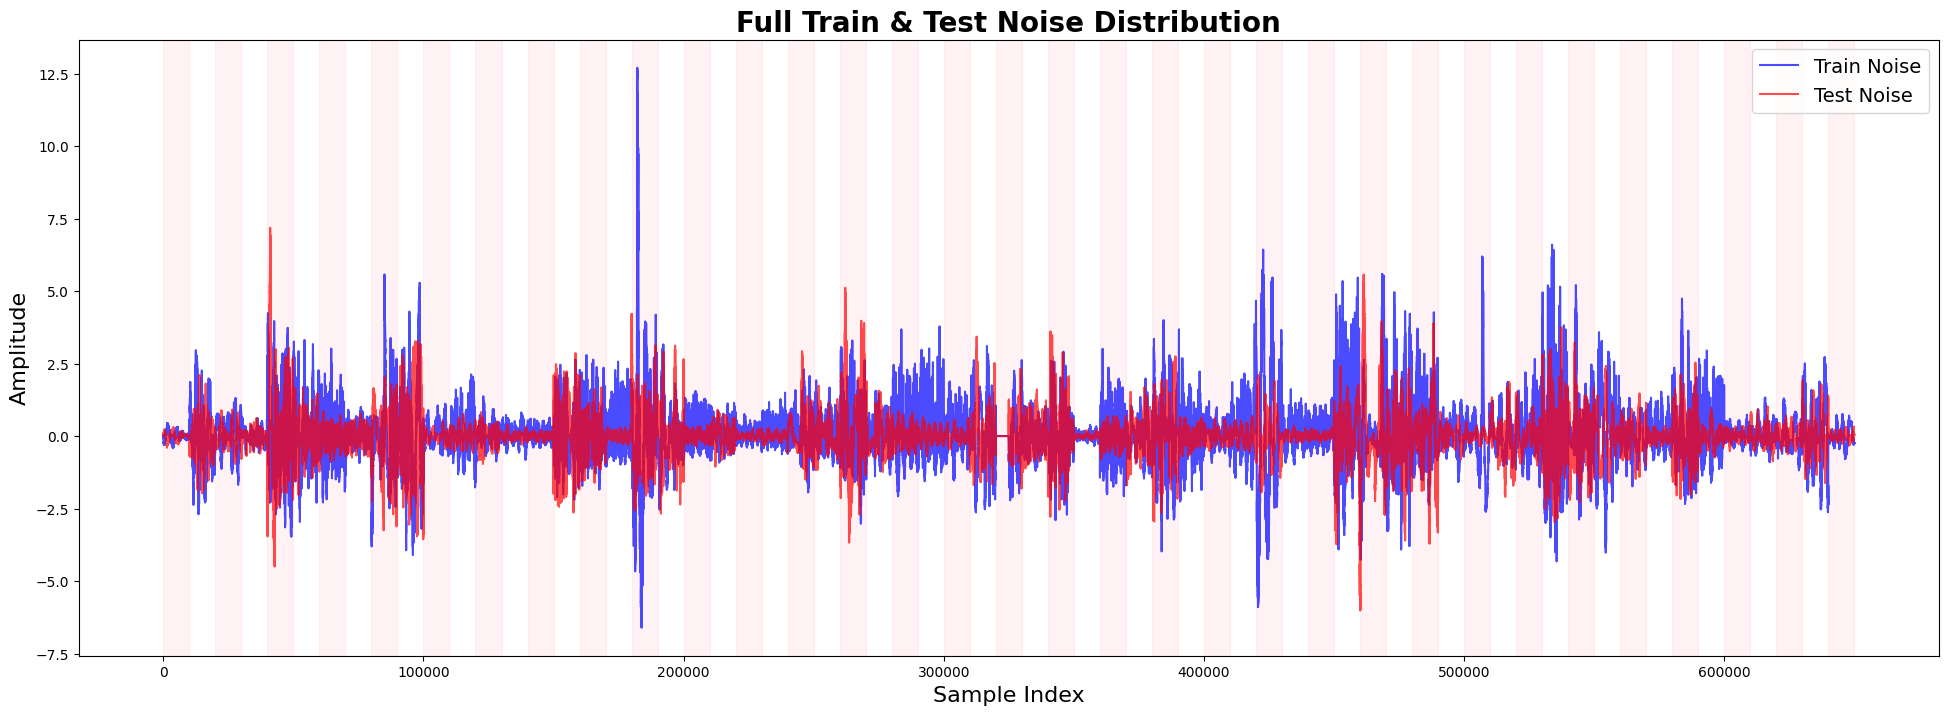

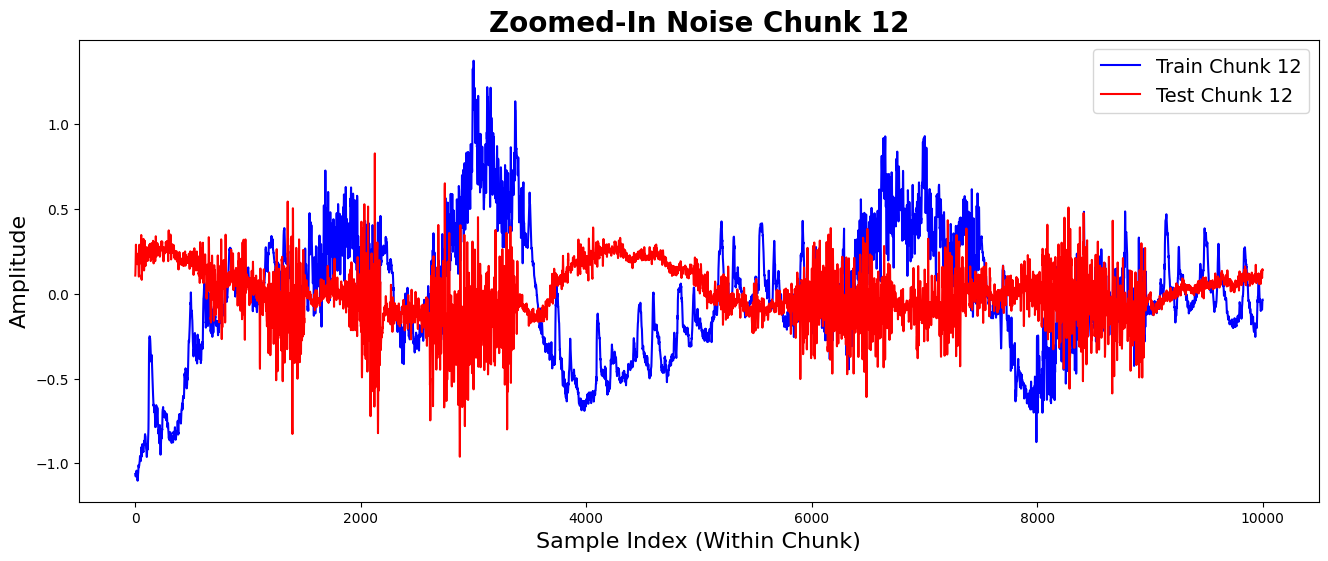

In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load Train and Test Noise
train_noise_path = 'data2/CombinedNoise_Train.pkl'
test_noise_path = 'data2/CombinedNoise_Test.pkl'

with open(train_noise_path, 'rb') as f:
    train_noise = pickle.load(f)  # Shape: (650000, 1)

with open(test_noise_path, 'rb') as f:
    test_noise = pickle.load(f)  # Shape: (650000, 1)


chunk_size = 10000
num_chunks = train_noise.shape[0] // chunk_size
x_full = np.arange(train_noise.shape[0])

# 🚀 **1️⃣ Plot Full Train & Test Noise**
plt.figure(figsize=(24, 8))
plt.plot(x_full, train_noise, label="Train Noise", color="blue", alpha=0.7)
plt.plot(x_full, test_noise, label="Test Noise", color="red", alpha=0.7)

# Highlight alternating chunks
for i in range(num_chunks):
    if i % 2 == 0:
        plt.axvspan(i * chunk_size, (i + 1) * chunk_size, color="pink", alpha=0.2)

plt.title("Full Train & Test Noise Distribution", fontsize=20, fontweight="bold")
plt.xlabel("Sample Index", fontsize=16)
plt.ylabel("Amplitude", fontsize=16)
plt.legend(fontsize=14)
plt.show()

# 🚀 **2️⃣ Zoomed-In View of a Specific Chunk**
zoom_chunk_idx = 12  # Change this to zoom into different chunks
start_idx = zoom_chunk_idx * chunk_size
end_idx = start_idx + chunk_size
x_zoom = np.arange(chunk_size)

plt.figure(figsize=(16, 6))
plt.plot(x_zoom, train_noise[start_idx:end_idx], label=f"Train Chunk {zoom_chunk_idx}", color="blue")
plt.plot(x_zoom, test_noise[start_idx:end_idx], label=f"Test Chunk {zoom_chunk_idx}", color="red")

plt.title(f"Zoomed-In Noise Chunk {zoom_chunk_idx}", fontsize=20, fontweight="bold")
plt.xlabel("Sample Index (Within Chunk)", fontsize=16)
plt.ylabel("Amplitude", fontsize=16)
plt.legend(fontsize=14)
plt.show()

# mit bih Dataset

## MIT-BIH Database SMOTE

In [13]:
import glob
import numpy as np
from scipy.signal import resample_poly
import wfdb
import math
import pandas as pd
import _pickle as pickle
import matplotlib.pyplot as plt
from collections import Counter

# MIT-BIH Database 전처리 및 라벨 추가
def prepare_mitdb_with_labels(mitpath='/home/dhc99/ecg_denoise/data/physionet.org/files/mitdb/1.0.0/'):
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']
    MITDatabaseSignals = dict()
    patient_ids = pd.read_csv(mitpath + 'RECORDS', header=None).squeeze("columns").to_numpy()

    for pid in patient_ids:
        signal, fields = wfdb.rdsamp(mitpath + str(pid))
        ann = wfdb.rdann(mitpath + str(pid), 'atr')
        annSamples = ann.sample
        annLabels = ann.symbol
        auxSig = signal[:, 0]
        beats_with_labels = []

        for i in range(1, len(annSamples) - 1):
            beat = auxSig[max(0, annSamples[i] - 99): min(len(auxSig), annSamples[i] + 201)]
            if len(beat) <= 300 and annLabels[i] in ecgClassSet:
                label = ecgClassSet.index(annLabels[i])
                beat_padded = np.zeros(300)
                beat_padded[:len(beat)] = beat - (beat[0] + beat[-1]) / 2  # Centering
                beats_with_labels.append((beat_padded, label))
        
        MITDatabaseSignals[pid] = beats_with_labels

    with open('data/MITDatabase_with_labels.pkl', 'wb') as output:
        pickle.dump(MITDatabaseSignals, output)
    print('MIT-BIH database with labels saved as pickle file.')


# Load 데이터
with open('data/MITDatabase_with_labels.pkl', 'rb') as input:
    mitdb_with_labels = pickle.load(input)

# 15-class에서 5-class로 그룹핑 함수
def group_to_5class(label):
    if 0 <= label <= 4:
        return 0  # Normal beats
    elif 5 <= label <= 8:
        return 1  # Supraventricular beats
    elif 9 <= label <= 10:
        return 2  # Ventricular beats
    elif label == 11:
        return 3  # Fusion beats
    elif 12 <= label <= 14:
        return 4  # Unknown beats
    else:
        return -1  # 오류 방지용 기본값

# 5-class로 변환된 라벨 저장
all_labels_5class = [group_to_5class(label) for pid in mitdb_with_labels.keys() for _, label in mitdb_with_labels[pid]]
all_labels_5class = [label for label in all_labels_5class if label != -1]  # -1 제거

# 5-class 분포 확인
class_counts_5class = Counter(all_labels_5class)
print("5-Class distribution:", class_counts_5class)


5-Class distribution: Counter({0: 90589, 4: 8039, 2: 7236, 1: 2779, 3: 803})


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import _pickle as pickle

# Load MIT-BIH 데이터 (dict 구조)
with open('data/MITDatabase_with_labels.pkl', 'rb') as input:
    mitdb_with_labels = pickle.load(input)

# 15-class에서 5-class로 그룹핑 함수
def group_to_5class(label):
    if 0 <= label <= 4:
        return 0  # Normal beats
    elif 5 <= label <= 8:
        return 1  # Supraventricular beats
    elif 9 <= label <= 10:
        return 2  # Ventricular beats
    elif label == 11:
        return 3  # Fusion beats
    elif 12 <= label <= 14:
        return 4  # Unknown beats
    else:
        return -1  # 오류 방지용 기본값

# 데이터 변환 및 그룹핑 (dict → X, y 배열로 변환)
X_data = []
y_data = []
beat_dict = {}

for pid in mitdb_with_labels.keys():
    beats = mitdb_with_labels[pid]
    for beat, label in beats:
        grouped_label = group_to_5class(label)
        if grouped_label != -1:
            X_data.append(beat)
            y_data.append(grouped_label)
            if pid not in beat_dict:
                beat_dict[pid] = []
            beat_dict[pid].append((beat, grouped_label))

X_data = np.array(X_data)
y_data = np.array(y_data)

# 클래스 분포 확인 (SMOTE 전)
class_counts_before = Counter(y_data)
print("Before SMOTE - Class Distribution:", class_counts_before)



Before SMOTE - Class Distribution: Counter({0: 90589, 4: 8039, 2: 7236, 1: 2779, 3: 803})


In [8]:
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

In [9]:
# train test split하고 바로해야됨됨
samples = 512  # 목표 샘플 길이
init_padding = 16  # 초기 패딩
max_length = samples - init_padding  # 최대 허용 비트 길이 (512 - 16 = 496)

# 새로운 배열 준비
x_test_padded = np.zeros((21890, samples, 1))  # (21890, 512, 1) 형태
y_test_padded = []  # 스킵된 비트를 제외한 라벨 저장
skip_beats = 0

# 각 비트에 대해 패딩 및 중심화 적용
for i, beat in enumerate(x_test):
    b_sq = np.array(beat)  # 비트 데이터를 배열로 변환
    if b_sq.shape[0] > max_length:  # 길이가 496을 초과하면 스킵
        skip_beats += 1
        continue
    
    # 패딩된 배열 준비
    b_np = np.zeros(samples)
    # 비트 데이터를 패딩하고 중심화
    b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2
    # 3차원으로 저장
    x_test_padded[i - skip_beats, :, 0] = b_np
    # 해당 라벨 저장
    y_test_padded.append(y_test[i])

# 스킵된 비트만큼 크기 조정
x_test_padded = x_test_padded[:21890 - skip_beats]  # 스킵된 만큼 줄임
y_test_padded = np.array(y_test_padded)

# 결과 확인
print("x_test_padded shape:", x_test_padded.shape)
print("y_test_padded shape:", y_test_padded.shape)
print("Skipped beats:", skip_beats)
# x_test.shape, y_test.shape

x_test_padded shape: (21890, 512, 1)
y_test_padded shape: (21890,)
Skipped beats: 0


In [10]:
# wanna find index
y_test_padded[y_test_padded == 1].shape

(550,)

In [11]:
# reshaping for using hstack function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
train_data = np.hstack((x_train, y_train))
test_data = np.hstack((x_test, y_test))

In [12]:
#  converting dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [13]:
train_data

0       1       2       3       4       5       6       7       8    \
0     -0.3200 -0.2950 -0.2950 -0.3050 -0.3000 -0.2850 -0.2700 -0.2750 -0.2950   
1      0.0650  0.0200  0.0350  0.0450  0.0200  0.0050  0.0200  0.0650  0.1300   
2     -0.0325 -0.0175 -0.0125 -0.0025 -0.0075 -0.0025  0.0075 -0.0025 -0.0075   
3     -0.0325 -0.0575 -0.0725 -0.0625 -0.0625 -0.0525 -0.0525 -0.0425 -0.0175   
4      0.2600  0.2300  0.2150  0.2000  0.1700  0.1400  0.1100  0.0750  0.0450   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
87551 -0.0800 -0.0500  0.0350  0.0950  0.1200  0.0950  0.1800  0.3750  0.4850   
87552  0.2200  0.2350  0.2400  0.2350  0.2400  0.2650  0.2900  0.3000  0.3250   
87553 -0.3300 -0.3300 -0.3200 -0.2950 -0.2850 -0.2800 -0.2750 -0.2700 -0.2650   
87554 -0.0725 -0.0675 -0.0875 -0.0875 -0.0525 -0.0475 -0.0525 -0.0625 -0.0625   
87555  0.0000 -0.0100 -0.0050 -0.0050  0.0100  0.0050  0.0000  0.0000 -0.0150   

          9    ...     291     292     293     294     295     296     297  \
0     -0.2950  ...  0.8350  1.1050  1.3600  1.5750  1.6550  1.5000  1.1200   
1      0.1400  ...  0.0000  0.0000  0.0050 -0.0050 -0.0200 -0.0250 -0.0500   
2      0.0025  ...  0.0875  0.0925  0.0675  0.0825  0.0625  0.0575  0.0375   
3     -0.0275  ... -0.0125 -0.0075  0.0025  0.0075  0.0225  0.0425  0.0425   
4      0.0300  ...  2.2050  2.2200  2.0750  1.7900  1.4250  0.9950  0.5500   
...       ...  ...     ...     ...     ...     ...     ...     ...     ...   
87551  0.3450  ...  0.1900  0.2000  0.2350  0.2750  0.2250  0.0900 -0.0350   
87552  0.3400  ... -0.2450 -0.2500 -0.2500 -0.2300 -0.2200 -0.2100 -0.2350   
87553 -0.2300  ...  0.3200  0.3200  0.3150  0.2950  0.2850  0.3050  0.3150   
87554 -0.0625  ...  0.0225  0.0525  0.0725  0.0475  0.0425  0.0525  0.0775   
87555 -0.0050  ...  0.0050  0.0150  0.0050  0.0100  0.0000 -0.0050 -0.0150   

          298     299  300  
0      0.6900  0.3200  0.0  
1     -0.0500 -0.0650  0.0  
2      0.0375  0.0325  0.0  
3      0.0425  0.0325  0.0  
4      0.1200 -0.2600  3.0  
...       ...     ...  ...  
87551 -0.0250  0.0800  2.0  
87552 -0.2200 -0.2200  2.0  
87553  0.3250  0.3300  2.0  
87554  0.0775  0.0725  0.0  
87555  0.0100  0.0000  0.0  

[87556 rows x 301 columns]

300
0.0    72482
4.0     6421
2.0     5787
1.0     2229
3.0      637
Name: count, dtype: int64


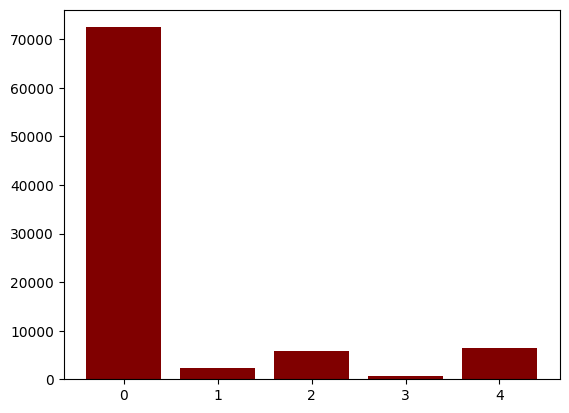

In [14]:
# Imblanced training data graph ploting 
class_data = train_data[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

In [19]:
# extracting class 0 and 4 others class
train_data_0 = train_data.loc[(train_data[300] == 0)]
train_data_1234 = train_data.loc[(train_data[300] != 0)]

In [20]:
# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled=train_data_0.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled = train_data_0_resampled.to_numpy()

In [21]:
# 2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data
# converting from df to np ndarray
train_data_1234_arr = train_data_1234.to_numpy()
X_4cl, y_4cl = train_data_1234_arr[:, :-1], train_data_1234_arr[:, -1]

from imblearn.over_sampling import SMOTE
# transform the dataset
strategy = {1:50000, 2:50000, 3:50000, 4:50000}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X_4cl, y_4cl)

y = y.reshape(-1, 1)
train_data_1234_resampled = np.hstack((X, y))

In [22]:
# Join the class 0 and 1234
train_data_resampled = np.vstack((train_data_0_resampled, train_data_1234_resampled))

# shuffle the data, needed for proper training
np.take(train_data_resampled,np.random.permutation(train_data_resampled.shape[0]),axis=0,out=train_data_resampled)

array([[ 0.095     ,  0.07      ,  0.045     , ..., -0.09      ,
        -0.095     ,  0.        ],
       [-0.17921957, -0.1742009 , -0.16916355, ...,  0.1742009 ,
         0.17921957,  2.        ],
       [ 0.06487966,  0.04361663,  0.04487966, ..., -0.06735361,
        -0.06487966,  4.        ],
       ...,
       [-0.03122197, -0.0300907 , -0.02961577, ...,  0.03122197,
         0.03122197,  1.        ],
       [ 0.05306475,  0.05349643,  0.03349643, ..., -0.04784891,
        -0.05306475,  4.        ],
       [-0.04860685, -0.03457109, -0.02117816, ...,  0.04199979,
         0.04860685,  4.        ]])

300
0.0    50000
2.0    50000
4.0    50000
1.0    50000
3.0    50000
Name: count, dtype: int64


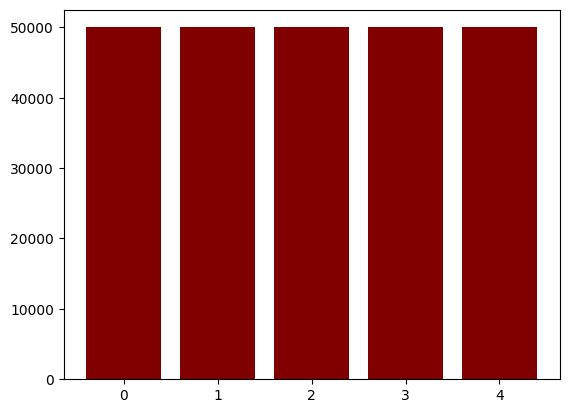

In [23]:
# blanced training data graph ploting 
train_data_r = pd.DataFrame(train_data_resampled)
class_data = train_data_r[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

# save balanced training data
file_name = 'data/MITDatabase_balanced.pkl'
train_data_r.to_pickle(file_name)

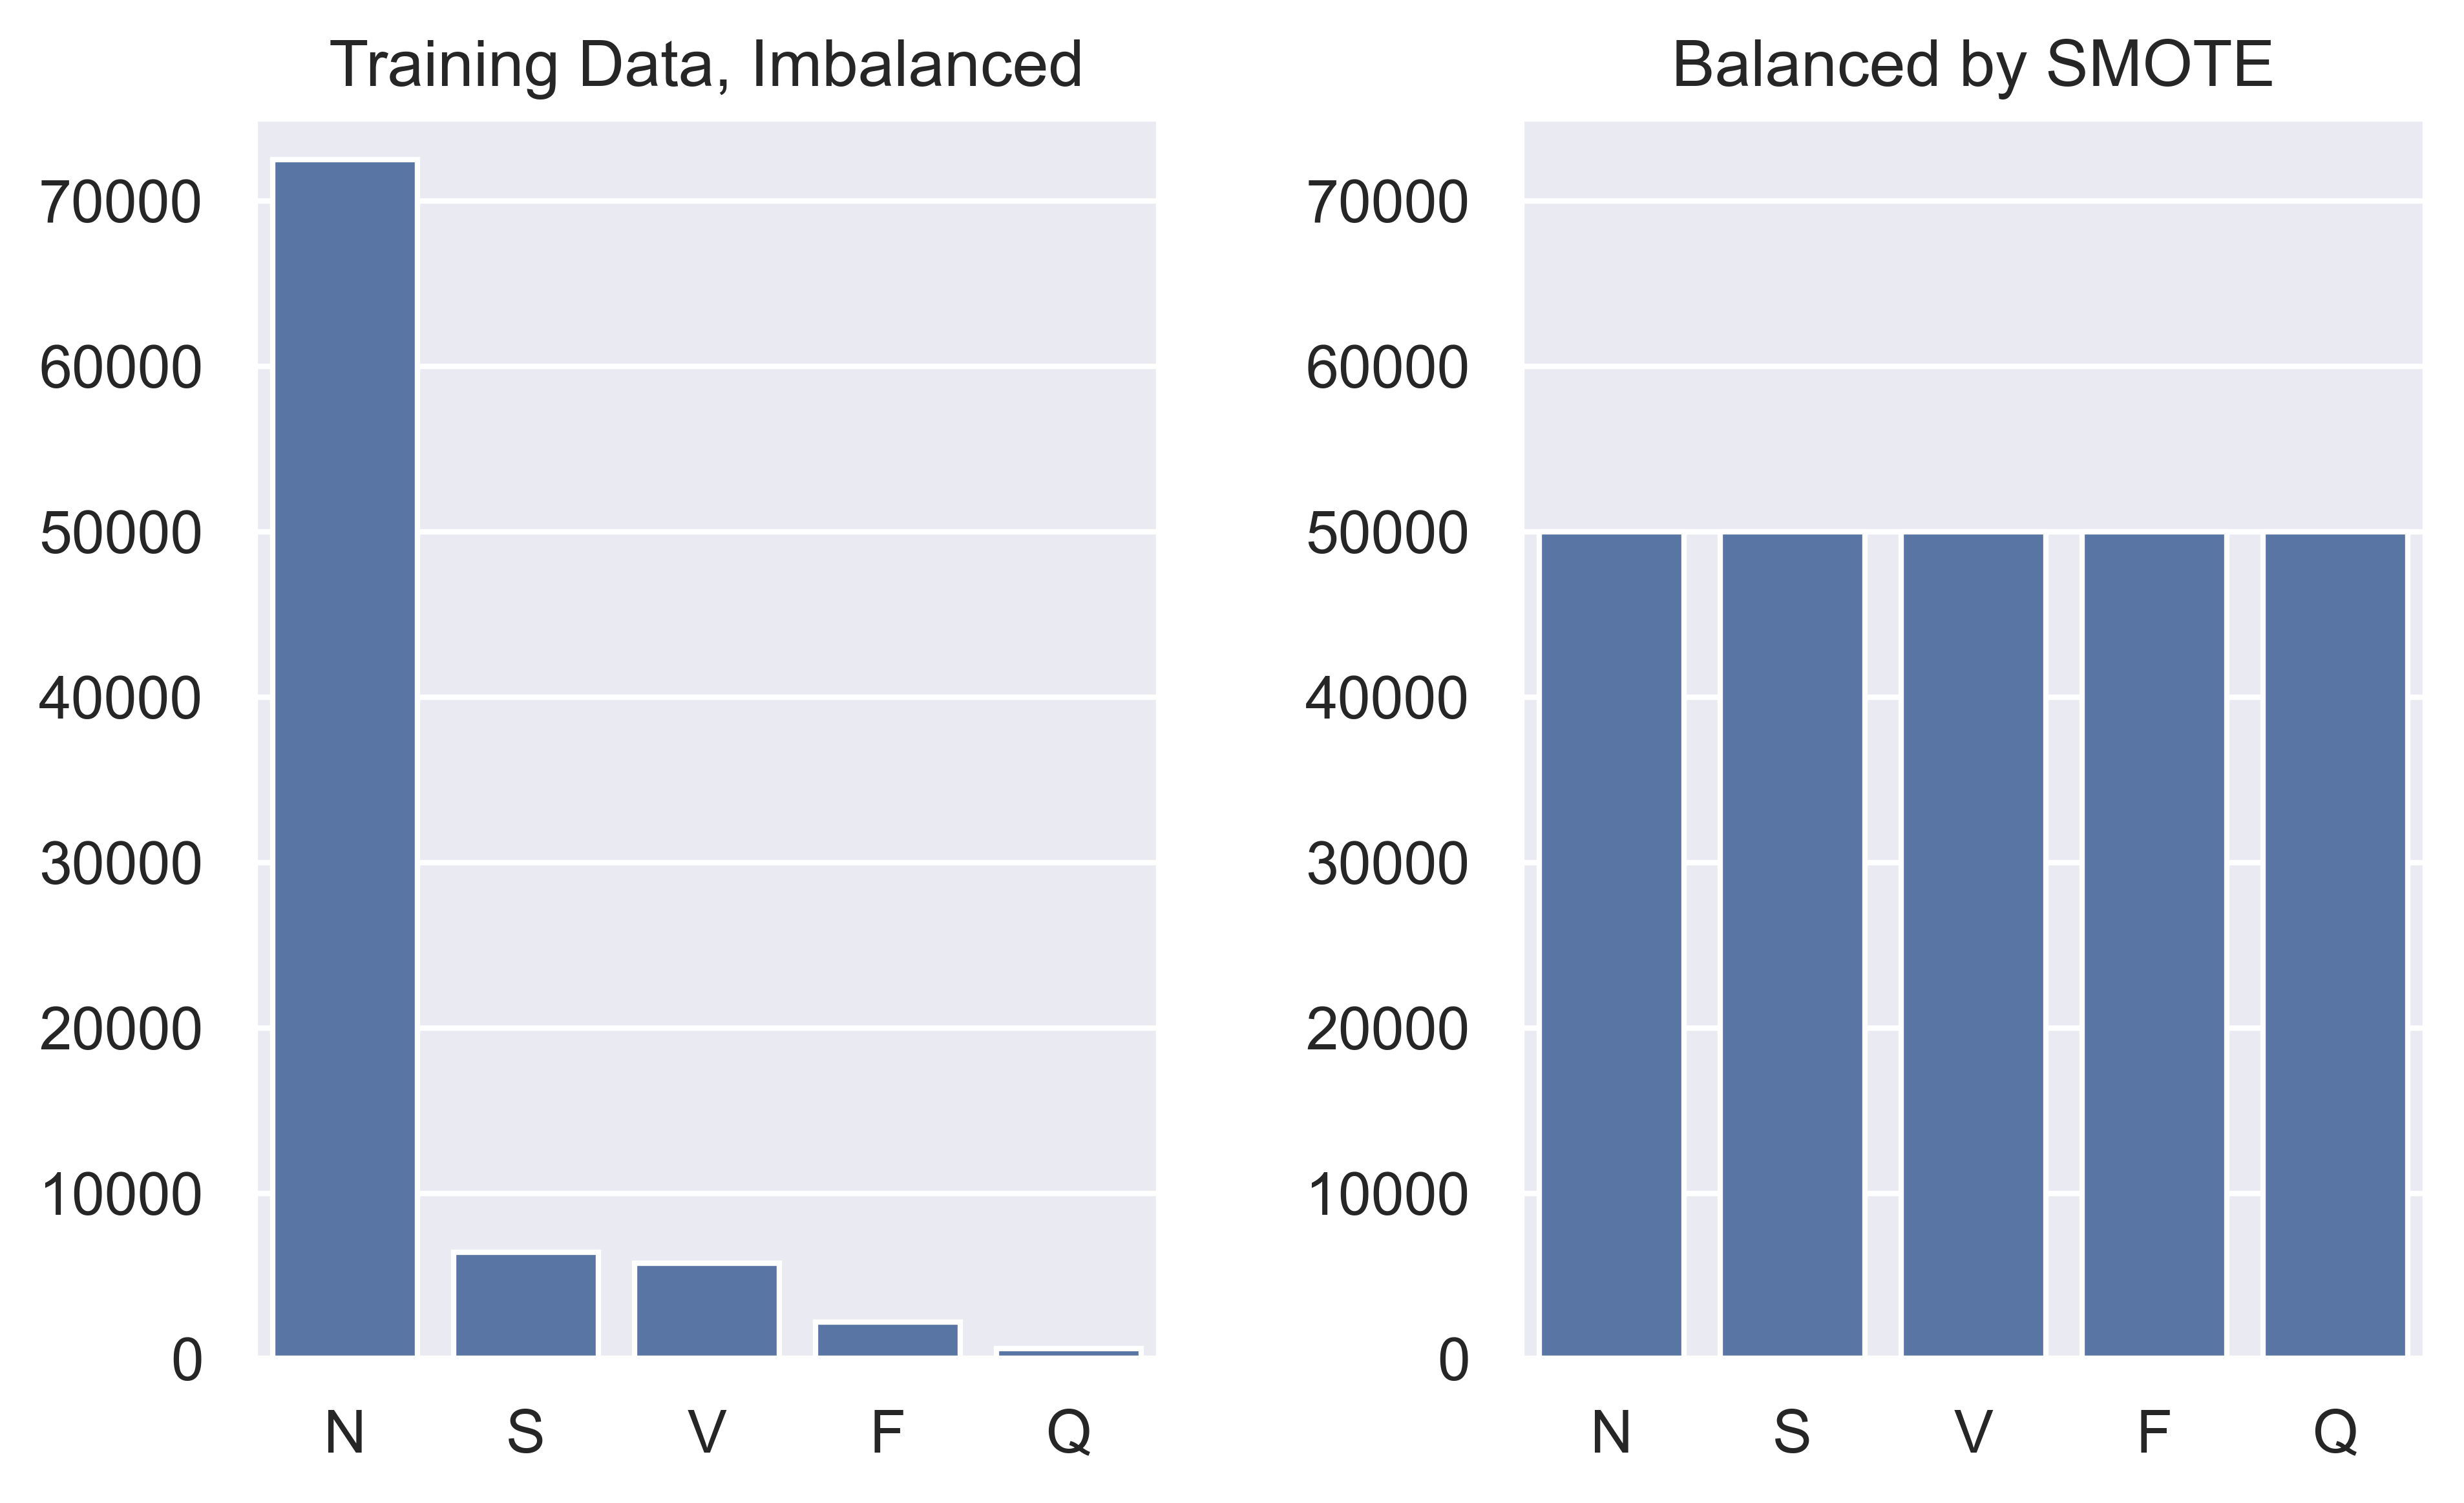

In [17]:
data_bal = np.array(class_data)
data_bal2 = data_bal.reshape(1, 5)
import seaborn as sns
sns.set()
sns.color_palette("hls", 8)

fig = plt.figure(figsize=(7,4), dpi=600)
plt.subplot(121)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = [72482,6421, 5787, 2229, 637])
plt.ylim(0, 75000)
plt.title('Training Data, Imbalanced')

plt.subplot(122)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = class_data.values)
plt.ylim(0, 75000)
plt.title('Balanced by SMOTE')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)

In [18]:
# dict 구조로 변환 (균형 잡힌 데이터를 다시 dict로 저장)
balanced_dict = {}
X_balanced = train_data_resampled[:, :-1]  # 특성 데이터
y_balanced = train_data_resampled[:, -1]   # 라벨 데이터
for i in range(len(X_balanced)):
    pid = f"balanced_{i // 1000}"  # 새로운 환자 ID 형식 (1000개 단위로 그룹화)
    # print(pid)
    if pid not in balanced_dict:
        balanced_dict[pid] = []
    balanced_dict[pid].append((X_balanced[i], y_balanced[i]))

# 데이터 저장 (Balanced 데이터셋)
output_file = 'data/MITDatabase_balanced_20250302.pkl'  # 날짜 추가로 버전 관리
with open(output_file, 'wb') as output:
    pickle.dump(balanced_dict, output)
print(f"Balanced MIT-BIH database saved as pickle file (dict format) at {output_file}")

Balanced MIT-BIH database saved as pickle file (dict format) at data/MITDatabase_balanced_20250302.pkl


In [18]:
X_balanced.shape, y_balanced.shape

((250000, 300), (250000,))

In [9]:
import numpy as np
from scipy.fft import fft
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle

def make_fourier(inputs, n, fs):
    """
    주파수 도메인 정보 추출 및 time-domain과 같은 shape으로 만듦.
    """
    T = n / fs
    k = np.arange(n)
    freq = k / T
    freq = freq[range(int(n / 2))]

    signal_list = []
    for i in range(inputs.shape[0]):
        y = inputs[i, :]
        Y = fft(y) / n  # FFT 수행 후 정규화
        Y = np.abs(Y[range(int(n / 2))])
        Y_full = np.hstack([Y, Y])  # Duplicate to match time-domain size (512)
        signal_list.append(Y_full)
    return np.asarray(signal_list)

def Data_Preparation_with_mitdb(samples=512, fs=360):
    """
    MITDB 데이터셋을 준비하고 Fourier 변환된 주파수 도메인 정보와 함께
    라벨(5-Class)도 반환합니다.
    """
    print('Preparing the MITDB dataset with labels...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)
    with open('data/MITDatabase_balanced_20250302.pkl', 'rb') as input:
        mitdb_with_labels = pickle.load(input)
    print(f"[INFO] Loaded MITDatabase with {len(mitdb_with_labels.keys())} signals")
    beats = []
    labels = []
    fourier_y = []
    X_data = []
    y_data = []
    for signal_name in mitdb_with_labels.keys():
        # pid = int(signal_name)  # signal_name을 정수형 환자 ID로 변환
        for beat, label in mitdb_with_labels[signal_name]:  # 비트와 라벨을 함께 처리
            b_np = np.zeros(samples)
            b_sq = np.array(beat)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):  # 샘플 길이를 초과하는 경우 스킵
                skip_beats += 1
                continue

            # 비트 데이터를 0으로 패딩하고 중심화 (Centering)
            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            # Fourier 변환 수행 (주파수 도메인 정보 생성)
            fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)

            # 데이터 저장
            X_data.append(b_np)
            y_data.append(label)
            beats.append(b_np)  # 비트 데이터
            labels.append(group_to_5class(label))  # 5-Class 라벨 저장
            fourier_y.append(fourier_transformed_y[0])  # Fourier 변환 결과 저장
                
    #####################################
    # Data split (80% train, 20% test)
    #####################################
    beats = np.array(beats)
    labels = np.array(labels)
    fourier_y = np.array(fourier_y)
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
    for train_idx, test_idx in sss.split(X_data, y_data):
        beats_train, beats_test = X_data[train_idx], X_data[test_idx]
        labels_train, labels_test = y_data[train_idx], y_data[test_idx]
        fourier_train_y, fourier_test_y = fourier_y[train_idx], fourier_y[test_idx]        
    print(f"[INFO] beats_train: {len(beats_train)}, beats_test: {len(beats_test)}")

    def add_noise_train(beats,  samples):
        with open('data2/CombinedNoise_Train.pkl', 'rb') as input:
            combined_noise = pickle.load(input)
        total_length = combined_noise.shape[0]  # 650000 samples
        half_length = total_length // 2
        train_noise_1 = combined_noise
        # Test Noise:
        sn = []
        fourier_x = []
        noise_index = 0
        for beat_idx, beat in enumerate(beats):
            noise_source = train_noise_1  # Upper half of channel 1
            noise_segment = noise_source[noise_index:noise_index + samples]
            signal_noise = beat + noise_segment
            sn.append(signal_noise)
            fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
            fourier_x.append(fourier_transformed_x[0])
            noise_index += samples
            if noise_index > (len(noise_source) - samples):
                noise_index = 0
        return sn, fourier_x
    def add_noise_test(beats, samples):
        with open('data2/CombinedNoise_Test.pkl', 'rb') as input:
            static_noise = pickle.load(input)
        test_noise_1 = static_noise
        sn = []
        fourier_x = []
        noise_index = 0
        for beat_idx, beat in enumerate(beats):
            noise_source = test_noise_1  # Lower half of channel 1
            noise_segment = noise_source[noise_index:noise_index + samples]
            signal_noise = beat + noise_segment
            sn.append(signal_noise)
            fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
            fourier_x.append(fourier_transformed_x[0])
            noise_index += samples
            if noise_index > (len(noise_source) - samples):
                noise_index = 0
        return sn, fourier_x

    # Add noise to train and test sets
    sn_train, fourier_train_x = add_noise_train(beats_train,  samples)
    sn_test, fourier_test_x = add_noise_test(beats_test, samples)

    #####################################
    # Convert to NumPy arrays and reshape
    #####################################
    X_train = np.expand_dims(np.array(sn_train), axis=2)
    y_train = np.expand_dims(np.array(beats_train), axis=2)
    X_test = np.expand_dims(np.array(sn_test), axis=2)
    y_test = np.expand_dims(np.array(beats_test), axis=2)
    F_train_x = np.expand_dims(np.array(fourier_train_x), axis=2)
    F_train_y = np.expand_dims(np.array(fourier_train_y), axis=2)
    F_test_x = np.expand_dims(np.array(fourier_test_x), axis=2)
    F_test_y = np.expand_dims(np.array(fourier_test_y), axis=2)

    y_train_label = np.array(labels_train)  # 라벨 반환
    y_test_label = np.array(labels_test)

    Dataset = [X_train, y_train, X_test, y_test, y_train_label, y_test_label]

    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Labels -> y_train_label: {y_train_label.shape}, y_test_label: {y_test_label.shape}")
    print('Dataset ready to use.')

    return Dataset

In [10]:
def Data_Preparation_with_Fourier_mitdb(samples=512, fs=360):
    """
    MITDB 데이터셋을 준비하고 Fourier 변환된 주파수 도메인 정보와 함께
    라벨(5-Class)도 반환합니다.
    """
    print('Preparing the MITDB dataset with labels...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)
    with open('data/MITDatabase_balanced_20250302.pkl', 'rb') as input:
        mitdb_with_labels = pickle.load(input)
    print(f"[INFO] Loaded MITDatabase with {len(mitdb_with_labels.keys())} signals")
    beats = []
    labels = []
    fourier_y = []
    X_data = []
    y_data = []
    for signal_name in mitdb_with_labels.keys():
        # pid = int(signal_name)  # signal_name을 정수형 환자 ID로 변환
        for beat, label in mitdb_with_labels[signal_name]:  # 비트와 라벨을 함께 처리
            b_np = np.zeros(samples)
            b_sq = np.array(beat)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):  # 샘플 길이를 초과하는 경우 스킵
                skip_beats += 1
                continue

            # 비트 데이터를 0으로 패딩하고 중심화 (Centering)
            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            # Fourier 변환 수행 (주파수 도메인 정보 생성)
            fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)

            # 데이터 저장
            X_data.append(b_np)
            y_data.append(label)
            beats.append(b_np)  # 비트 데이터
            labels.append(group_to_5class(label))  # 5-Class 라벨 저장
            fourier_y.append(fourier_transformed_y[0])  # Fourier 변환 결과 저장
                
    #####################################
    # Data split (80% train, 20% test)
    #####################################
    beats = np.array(beats)
    labels = np.array(labels)
    fourier_y = np.array(fourier_y)
    X_data = np.array(X_data)
    y_data = np.array(y_data)

    from sklearn.model_selection import StratifiedShuffleSplit

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
    for train_idx, test_idx in sss.split(X_data, y_data):
        beats_train, beats_test = X_data[train_idx], X_data[test_idx]
        labels_train, labels_test = y_data[train_idx], y_data[test_idx]
        fourier_train_y, fourier_test_y = fourier_y[train_idx], fourier_y[test_idx]
        
    print(f"[INFO] beats_train: {len(beats_train)}, beats_test: {len(beats_test)}")

    #####################################
    # Adding noise to train and test sets
    #####################################
    print(f"[INFO] Adding noise to train and test sets")

    def add_noise_train(beats,  samples):
        with open('data2/CombinedNoise_Train.pkl', 'rb') as input:
            combined_noise = pickle.load(input)
        total_length = combined_noise.shape[0]  # 650000 samples
        half_length = total_length // 2
        train_noise_1 = combined_noise
        # Test Noise:
        sn = []
        fourier_x = []
        noise_index = 0
        for beat_idx, beat in enumerate(beats):
            noise_source = train_noise_1  # Upper half of channel 1
            noise_segment = noise_source[noise_index:noise_index + samples]
            signal_noise = beat + noise_segment
            sn.append(signal_noise)
            fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
            fourier_x.append(fourier_transformed_x[0])
            noise_index += samples
            if noise_index > (len(noise_source) - samples):
                noise_index = 0
        return sn, fourier_x
    def add_noise_test(beats, samples):
        with open('data2/CombinedNoise_Test.pkl', 'rb') as input:
            static_noise = pickle.load(input)
        test_noise_1 = static_noise
        sn = []
        fourier_x = []
        noise_index = 0
        for beat_idx, beat in enumerate(beats):
            noise_source = test_noise_1  # Lower half of channel 1
            noise_segment = noise_source[noise_index:noise_index + samples]
            signal_noise = beat + noise_segment
            sn.append(signal_noise)
            fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
            fourier_x.append(fourier_transformed_x[0])
            noise_index += samples
            if noise_index > (len(noise_source) - samples):
                noise_index = 0
        return sn, fourier_x

    # Add noise to train and test sets
    sn_train, fourier_train_x = add_noise_train(beats_train, samples)
    sn_test, fourier_test_x = add_noise_test(beats_test, samples)

    #####################################
    # Convert to NumPy arrays and reshape
    #####################################
    X_train = np.expand_dims(np.array(sn_train), axis=2)
    y_train = np.expand_dims(np.array(beats_train), axis=2)
    X_test = np.expand_dims(np.array(sn_test), axis=2)
    y_test = np.expand_dims(np.array(beats_test), axis=2)
    F_train_x = np.expand_dims(np.array(fourier_train_x), axis=2)
    F_train_y = np.expand_dims(np.array(fourier_train_y), axis=2)
    F_test_x = np.expand_dims(np.array(fourier_test_x), axis=2)
    F_test_y = np.expand_dims(np.array(fourier_test_y), axis=2)

    y_train_label = np.array(labels_train)  # 라벨 반환
    y_test_label = np.array(labels_test)

    Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label]

    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Labels -> y_train_label: {y_train_label.shape}, y_test_label: {y_test_label.shape}")
    print('Dataset ready to use.')

    return Dataset

In [15]:
# Unpack the dataset
Dataset = Data_Preparation_with_Fourier_mitdb(samples=512, fs=360)
X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label = Dataset


# Print dataset shapes for confirmation
print(f"Time domain train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Frequency domain train shapes: F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}")
print(f"Time domain test shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Frequency domain test shapes: F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")

Preparing the MITDB dataset with labels...
[INFO] Loaded MITDatabase with 250 signals
[INFO] beats_train: 200000, beats_test: 50000
[INFO] Adding noise to train and test sets
[INFO] Final shapes -> X_train: (200000, 512, 1), y_train: (200000, 512, 1), X_test: (50000, 512, 1), y_test: (50000, 512, 1)
[INFO] Labels -> y_train_label: (200000,), y_test_label: (50000,)
Dataset ready to use.
Time domain train shapes: X_train: (200000, 512, 1), y_train: (200000, 512, 1)
Frequency domain train shapes: F_train_x: (200000, 512, 1), F_train_y: (200000, 512, 1)
Time domain test shapes: X_test: (50000, 512, 1), y_test: (50000, 512, 1)
Frequency domain test shapes: F_test_x: (50000, 512, 1), F_test_y: (50000, 512, 1)


In [ ]:
clean_ecg = np.concatenate([y_train, y_test], axis=0)  # (250000, 512, 1)
print(f"[INFO] Clean ECG shape: {clean_ecg.shape}")

import numpy as np
px_value_mit = np.mean(clean_ecg**2)

print(px_value_mit)


[INFO] Clean ECG shape: (250000, 512, 1)
0.19572994830994553


In [20]:
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras import losses
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import tensorflow as tf 
from datetime import datetime
from deepFilter.dl_models import *
import os
import shap
current_date = datetime.now().strftime('%m%d')
# Custom loss SSD
import tensorflow as tf

def ssd_loss(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_pred - y_true), axis=-2)

# Combined loss SSD + MSE
def combined_ssd_mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred), axis=-2) * 500 + tf.reduce_sum(tf.square(y_true - y_pred), axis=-2)

def combined_ssd_mad_loss(y_true, y_pred):
    return tf.reduce_max(tf.square(y_true - y_pred), axis=-2) * 50 + tf.reduce_sum(tf.square(y_true - y_pred), axis=-2)

# Custom loss SAD
def sad_loss(y_true, y_pred):
    return tf.reduce_sum(tf.sqrt(tf.square(y_pred - y_true)), axis=-2)

# Custom loss MAD
def mad_loss(y_true, y_pred):
    return tf.reduce_max(tf.square(y_pred - y_true), axis=-2)

def train_dl(Dataset, experiment):

    print('Deep Learning pipeline: Training the model for exp ' + str(experiment))
    
    if experiment in ['Dual_FreqDAE']:
        [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label] = Dataset

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)
        F_train_x, F_val_x, F_train_y, F_val_y = train_test_split(F_train_x, F_train_y, test_size=0.3, shuffle=True, random_state=1)
    else:
        [X_train, y_train, X_test, y_test, y_train_label, y_test_label] = Dataset
        # 일반 모델들을 위한 데이터 분할
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)
            
    # ==================
    # LOAD THE DL MODEL
    # ==================
    if experiment == 'CNN_DAE':
        # FCN_DAE
        model = CNN_DAE()
        model_label = 'CNN_DAE'
        
    if experiment == 'FCN_DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'DeepFilter':
        # Inception-like linear and non linear dilated
        model = deep_filter_model_I_LANL_dilated()
        model_label = 'DeepFilter'
        
    if experiment == 'AttentionSkipDAE':
        # Inception-like linear and non linear dilated
        model = AttentionSkipDAE()
        model_label = 'AttentionSkipDAE'
    
    if experiment == 'Transformer_DAE':
        # Transformer_FDAE
        model = Transformer_DAE()
        model_label = 'Transformer_DAE'
        
    if experiment == 'Dual_FreqDAE':
        model = Dual_FreqDAE()
        model_label = 'Dual_FreqDAE'
        
    print('\n ' + model_label + '\n ')

    model.summary()
    epochs = int(1e5)  # 100000
    batch_size = 128  #128

    lr = 1e-3
    # lr = 1e-4
    minimum_lr = 1e-10

    # Loss function selection according to method implementation
    if experiment == 'DRNN' or experiment == 'AttentionSkipDAE':
        criterion = keras.losses.mean_squared_error

    # elif experiment == 'FCN_DAE':
    #     criterion = ssd_loss

    else:
        criterion = combined_ssd_mad_loss

    model.compile(loss=criterion,
                  optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])

    # Keras Callbacks

    # 체크포인트 파일 경로 설정
    model_dir = current_date
    model_filepath = os.path.join(model_dir, f"mitdb_{model_label}_weights.best.weights.h5")

    # 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    checkpoint = ModelCheckpoint(model_filepath,
                                 monitor="val_loss",
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',  # on acc has to go max
                                 save_weights_only=True)

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.5,
                                  min_delta=0.05,
                                  mode='min',  # on acc has to go max
                                  patience=2,
                                  min_lr=minimum_lr,
                                  verbose=1)

    early_stop = EarlyStopping(monitor="val_loss",  # "val_loss"
                               min_delta=0.05,
                               mode='min',  # on acc has to go max
                               patience=10,
                               verbose=1)

    tb_log_dir = './runs_mitdb_' + current_date +'/' + model_label
    # 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(tb_log_dir):
        os.makedirs(tb_log_dir)
    tboard = TensorBoard(log_dir=tb_log_dir, histogram_freq=0,
                         write_graph=False, 
                         write_images=False, embeddings_freq=0,
                        #  embeddings_layer_names=None,
                         embeddings_metadata=None)

    # To run the tensor board
    # tensorboard --logdir=./runs_new

    if experiment in ['Dual_FreqDAE']:
        model.fit(x=[X_train, F_train_x], y=y_train,
                validation_data=([X_val, F_val_x], y_val),
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                callbacks=[early_stop,
                            reduce_lr,
                            checkpoint,
                            tboard])
    else:
        model.fit(x=X_train, y=y_train,
                validation_data=(X_val, y_val),
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                callbacks=[early_stop,
                            reduce_lr,
                            checkpoint,
                            tboard])
    K.clear_session()



def test_dl(Dataset, experiment):

    print('Deep Learning pipeline: Testing the model')
# 여기선 x_test, y_test만 사용됨
    if experiment in ['Dual_FreqDAE']:
        [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label] = Dataset

    else:
        [X_train, y_train, X_test, y_test, y_train_label, y_test_label] = Dataset
        # 일반 모델들을 위한 데이터 분할
    batch_size = 128

    if experiment == 'CNN_DAE':
        # FCN_DAE
        model = CNN_DAE()
        model_label = 'CNN_DAE'
    if experiment == 'FCN_DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'DeepFilter':
        # Inception-like linear and non linear dilated
        model = deep_filter_model_I_LANL_dilated()
        model_label = 'DeepFilter'

    if experiment == 'AttentionSkipDAE':
        # Inception-like linear and non linear dilated
        model = AttentionSkipDAE()
        model_label = 'AttentionSkipDAE'
        
    if experiment == 'Transformer_DAE':
        model = Transformer_DAE()
        model_label = 'Transformer_DAE'
        
    if experiment == 'Dual_FreqDAE':
        model = Dual_FreqDAE()
        model_label = 'Dual_FreqDAE'
            
    print('\n ' + model_label + '\n ')

    model.summary()

    # Loss function selection according to method implementation

    if experiment == 'DRNN' or experiment ==  'CNN_DAE' or experiment == 'FCN_DAE' or experiment == 'AttentionSkipDAE':
        criterion = keras.losses.mean_squared_error

    # elif experiment == 'FCN_DAE':
    #     criterion = ssd_loss
    else:
        criterion = combined_ssd_mad_loss
        # criterion = combined_huber_freq_loss

    model.compile(loss=criterion,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])
    model_dir = current_date
    model_filepath = os.path.join(model_dir, f"mitdb_{model_label}_weights.best.weights.h5")

    # 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    # load weights
    model.load_weights(model_filepath)
    
    if experiment in ['Dual_FreqDAE']:
        # Test score
        y_pred = model.predict([X_test, F_test_x], batch_size=batch_size, verbose=1)

    else:
        # Test score
        y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
        
    K.clear_session()

    return [X_test, y_test, y_pred]

In [ ]:
# from deepFilter.dl_pipeline import train_dl, test_dl
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np
import os

dl_experiments = ['AttentionSkipDAE']
# dl_experiments = ['Dual_FreqDAE']
train_time_list = []
test_time_list = []
    
    # Get the current date in 'MMDD' format
current_date = datetime.now().strftime('%m%d')
for experiment in dl_experiments:
    # 데이터 준비 단계
    if experiment in ['Dual_FreqDAE']:
        Dataset = Data_Preparation_with_Fourier_mitdb(samples=512, fs=360)
        X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label = Dataset         
    else:
        Dataset = Data_Preparation_with_mitdb(samples=512)
        X_train, y_train, X_test, y_test, y_train_label, y_test_label = Dataset
    # 훈련 시간 측정 및 모델 훈련
    start_train = datetime.now()
    train_dl(Dataset, experiment)
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)
    # 테스트 시간 측정 및 모델 테스트
    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, experiment)
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)
    # 시각화 및 결과 저장
    save_dir = current_date 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    test_results = [X_test, y_test, y_pred]
    with open(os.path.join(save_dir,'mitdb_test_results_' + experiment + '.pkl'), 'wb') as output:
        pickle.dump(test_results, output)
    print('Results from experiment ' + experiment + ' saved')

In [1]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = [ 'DRNN', 'DeepFilter','CNN_DAE','FCN_DAE','AttentionSkipDAE','Transformer_DAE','Dual_FreqDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']

In [7]:
with open('0301_final/mitdb_test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
with open('0301_final/mitdb_test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
with open('0301_final/mitdb_test_results_' + dl_experiments[2] + '.pkl', 'rb') as input:
    test_CNN_DAE = pickle.load(input)
with open('0301_final/mitdb_test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0301_final/mitdb_test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0301_final/mitdb_test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0301_final/mitdb_test_results_'  + dl_experiments[6] + '.pkl', 'rb') as input:
    test_Dual_FreqDAE = pickle.load(input)
            
print('Calculating metrics ...')
# DL Metrics
# Exp DRNN
[X_test, y_test, y_pred] = test_DRNN
RMSE_values_DL_DRNN = RMSE(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)
# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
RMSE_values_DL_exp_1 = RMSE(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

[X_test, y_test, y_pred] = test_CNN_DAE
RMSE_values_DL_CNN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_CNN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_CNN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_CNN_DAE = SNR(y_test, y_pred)


# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
RMSE_values_DL_exp_2 = RMSE(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
RMSE_values_DL_exp_3 = RMSE(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Dual_FreqDAE
RMSE_values_DL_exp_4 = RMSE(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

RMSE_all = [RMSE_values_DL_DRNN, RMSE_values_DL_exp_1,
            RMSE_values_DL_CNN_DAE,
            RMSE_values_DL_FCN_DAE,
            RMSE_values_DL_exp_2,
            RMSE_values_DL_exp_3,
            RMSE_values_DL_exp_4]

PRD_all = [PRD_values_DL_DRNN, PRD_values_DL_exp_1,
            PRD_values_DL_CNN_DAE,
            PRD_values_DL_FCN_DAE,
            PRD_values_DL_exp_2,
            PRD_values_DL_exp_3,
            PRD_values_DL_exp_4]
CORR_all = [COS_SIM_values_DL_DRNN,COS_SIM_values_DL_exp_1,COS_SIM_values_DL_CNN_DAE,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4]
SNR_all = [SNR_values_DL_DRNN,SNR_values_DL_exp_1,SNR_values_DL_CNN_DAE,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = dl_experiments
metrics = ['RMSE', 'PRD', 'COS_SIM', 'SNR']
metric_values = [RMSE_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+------------------+---------------+-----------------+---------------+----------------+
|      Model       |      RMSE     |       PRD       |    COS_SIM    |      SNR       |
+------------------+---------------+-----------------+---------------+----------------+
|       DRNN       | 0.138 (0.090) | 57.266 (43.688) | 0.869 (0.154) | 8.221 (4.851)  |
|    DeepFilter    | 0.133 (0.110) | 45.940 (34.106) | 0.872 (0.184) | 9.252 (6.240)  |
|     CNN_DAE      | 0.098 (0.066) | 36.209 (28.443) | 0.916 (0.140) | 11.252 (6.283) |
|     FCN_DAE      | 0.100 (0.066) | 39.165 (30.310) | 0.911 (0.146) | 10.915 (6.082) |
| AttentionSkipDAE | 0.092 (0.078) | 31.150 (25.723) | 0.919 (0.154) | 12.515 (7.672) |
| Transformer_DAE  | 0.088 (0.070) | 29.268 (24.205) | 0.926 (0.141) | 12.906 (7.708) |
|   Dual_FreqDAE   | 0.084 (0.066) | 28.922 (23.829) | 0.926 (0.137) | 13.223 (8.172) |
+------------------+---------------+-----------------+---------------+----------------+


In [ ]:
[X_test,y_test, y_pred] = test_Transformer_DAE
y_test.shape, y_pred.shape
def calculate_snr(signal, noise):
    """
    SNR 계산 (dB 단위)
    Parameters:
    signal: 원본 신호
    noise: 노이즈 신호
    
    Returns:
    SNR 값 (dB)
    """
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# SNR 계산 및 개선율 출력
snr_input = calculate_snr(y_test, X_test - y_test)
snr_output = calculate_snr(y_test, y_pred - y_test)
snr_improvement = snr_output - snr_input

print(f"SNR 입력: {snr_input:.2f} dB")
print(f"SNR 출력: {snr_output:.2f} dB")
print(f"SNR 개선: {snr_improvement:.2f} dB")


## R PEAK

In [7]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def select_midrange_indices(y_test, y_pred, num_samples=5):
    """
    Transformer_DAE 기준으로 중간 정도 디노이징된 샘플 선택
    """
    errors = np.mean(np.abs(y_test - y_pred), axis=1)  # MAE 기반 오류 측정
    midrange_indices = np.argsort(errors)[:num_samples]  # 중간 오류 샘플 선택
    return midrange_indices

def ecg_view_comparison(ecg_segments, ecg_blw_segments, ecg_dl_segments, model_name,
                        save_dir='view_comparison', num_segments=5):
    ensure_directory(save_dir)

    # Concatenate segments for plotting
    ecg_concat = np.concatenate([np.squeeze(seg) for seg in ecg_segments[:num_segments]])
    ecg_blw_concat = np.concatenate([np.squeeze(seg) for seg in ecg_blw_segments[:num_segments]])
    ecg_dl_concat = np.concatenate([np.squeeze(seg) for seg in ecg_dl_segments[:num_segments]])

    # Plot comparison
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.plot(ecg_concat, 'k-', label='Original ECG', lw=1.5)  # 원본 (검은색)
    ax.plot(ecg_blw_concat, 'b--', label='Noisy ECG', lw=1.2, alpha=0.6)  # 노이즈 추가된 ECG (파란 점선)
    ax.plot(ecg_dl_concat, 'r-', label=f'{model_name} Filtered ECG', lw=1.5)  # 모델이 복원한 신호 (빨간색)
    
    # Grid, labels, and legend
    ax.grid(True, linestyle='--', linewidth=1)
    ax.set_xlabel('Samples (N)', fontsize=32)
    ax.set_ylabel('Amplitude (au)', fontsize=32)
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.legend(loc='upper right', fontsize=22, frameon=False)
    
    # Save the figure
    filename = f"Comparison_{model_name}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {filepath}")

model_results = {}
dl_experiments = [ 'DRNN', 'DeepFilter','CNN_DAE','FCN_DAE','AttentionSkipDAE','Transformer_DAE','Dual_FreqDAE']
# dl_experiments = ['Transformer_COMBDAE']

for model_name in dl_experiments:
    file_path = f"0301_final/mitdb_test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)


# === Transformer_DAE 기준으로 중간 정도의 성능을 보이는 샘플 선택 === #
X_test_tdae, y_test_tdae, y_pred_tdae = model_results["Transformer_DAE"]
best_indices = select_midrange_indices(np.squeeze(y_test_tdae), np.squeeze(y_pred_tdae), num_samples=3)

# === 모든 모델에서 동일한 샘플 인덱스 사용 === #
for model_name, (X_test, y_test, y_pred) in model_results.items():
    X_test = np.squeeze(X_test)  # (13316, 512, 1) → (13316, 512)
    y_test = np.squeeze(y_test)  # (13316, 512, 1) → (13316, 512)
    y_pred = np.squeeze(y_pred)  # (13316, 512, 1) → (13316, 512)

    ecgbl_signals2plot = [X_test[i] for i in best_indices]
    ecg_signals2plot = [y_test[i] for i in best_indices]
    dl_signals2plot = [y_pred[i] for i in best_indices]

    ecg_view_comparison(ecg_segments=ecg_signals2plot,
                        ecg_blw_segments=ecgbl_signals2plot,
                        ecg_dl_segments=dl_signals2plot,
                        model_name=model_name,
                        save_dir='fig19',
                        num_segments=len(best_indices))

Saved: fig19/Comparison_DRNN_Segments_3.png
Saved: fig19/Comparison_DeepFilter_Segments_3.png
Saved: fig19/Comparison_CNN_DAE_Segments_3.png
Saved: fig19/Comparison_FCN_DAE_Segments_3.png
Saved: fig19/Comparison_AttentionSkipDAE_Segments_3.png
Saved: fig19/Comparison_Transformer_DAE_Segments_3.png
Saved: fig19/Comparison_Dual_FreqDAE_Segments_3.png


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
from vg_beat_detectors import FastNVG

def filter_peaks(peaks, min_distance=256):
    """최소 간격을 유지하며 R-peak를 필터링하는 함수"""
    if len(peaks) == 0:
        return np.array([])
    filtered_peaks = [peaks[0]]
    for i in range(1, len(peaks)):
        if peaks[i] - filtered_peaks[-1] > min_distance:
            filtered_peaks.append(peaks[i])
    return np.array(filtered_peaks)

def classify_peaks(gt_peaks, model_peaks, tolerance=20, sample_length=512):
    """R-peak 검출 결과를 TP, FP, FN으로 분류 (각 512 샘플 길이당 하나만 유지)"""
    sample_results = {}  # 512 샘플 단위로 TP, FP, FN 중 하나만 저장

    for model_peak in model_peaks:
        sample_idx = int(model_peak // sample_length)  # 샘플 번호 계산 (정수 변환)
        if sample_idx not in sample_results:
            closest_gt_idx = np.argmin(np.abs(gt_peaks - model_peak))
            if np.abs(gt_peaks[closest_gt_idx] - model_peak) <= tolerance:
                sample_results[sample_idx] = ("TP", int(model_peak))
            else:
                sample_results[sample_idx] = ("FP", int(model_peak))

    for gt_peak in gt_peaks:
        sample_idx = int(gt_peak // sample_length)  # 샘플 번호 계산 (정수 변환)
        if sample_idx not in sample_results:
            sample_results[sample_idx] = ("FN", int(gt_peak))

    # 결과 분리
    tp_indices = np.array([val for key, (cls, val) in sample_results.items() if cls == "TP"], dtype=int)
    fp_indices = np.array([val for key, (cls, val) in sample_results.items() if cls == "FP"], dtype=int)
    fn_indices = np.array([val for key, (cls, val) in sample_results.items() if cls == "FN"], dtype=int)

    return tp_indices, fp_indices, fn_indices

def find_fp_fn_segments(y_test, detector, num_segments=4, max_figures=50, max_index=400000):
    """FP 또는 FN이 포함된 여러 개의 512 샘플 * num_segments(4)개의 연속된 구간을 슬라이딩 윈도우 방식으로 찾음"""
    found_segments = []
    
    for i in range(y_test.shape[0] - num_segments):  # 기존에는 num_segments만큼 점프 → 이제 1씩 증가
        if len(found_segments) >= max_figures or i * 512 > max_index:
            break  # 최대 개수 도달 또는 index 1000 초과 시 종료

        segment = np.concatenate(y_test[i : i + num_segments].squeeze(), axis=0)  # (2048,)
        gt_peaks = detector.find_peaks(segment)
        gt_peaks = filter_peaks(gt_peaks, min_distance=256)

        if len(gt_peaks) == 0:
            continue  # R-peak가 없는 구간은 무시

        # 'Transformer_DAE' 모델 결과 확인
        y_pred_trans = np.concatenate(model_results["Transformer_DAE"][2][i : i + num_segments].squeeze(), axis=0)  # (2048,)
        trans_peaks = detector.find_peaks(y_pred_trans)
        trans_peaks = filter_peaks(trans_peaks, min_distance=256)

        _, fp_indices, fn_indices = classify_peaks(gt_peaks, trans_peaks)

        if len(fp_indices) > 0 or len(fn_indices) > 0:
            found_segments.append((i, i + num_segments))  # 기존처럼 저장

    return found_segments  # 여러 개의 구간 반환

import numpy as np
import matplotlib.pyplot as plt
import os
from vg_beat_detectors import FastNVG

def plot_r_peak_detection(y_test, y_pred, model_name, tp_indices, fp_indices, fn_indices, gt_peaks, fig_num, save_dir="fig16"):
    """여러 개의 Figure를 생성하여 R-peak 검출 결과를 시각화 (Ground Truth R-peak에 세로 점선 추가)"""
    os.makedirs(save_dir, exist_ok=True)

    # 인덱스를 정수형으로 변환
    tp_indices = np.array(tp_indices, dtype=int)
    fp_indices = np.array(fp_indices, dtype=int)
    fn_indices = np.array(fn_indices, dtype=int)

    plt.figure(figsize=(27, 6))
    plt.plot(y_test, label="Ground Truth Signal", color="black", linewidth=3, alpha=0.5)
    plt.plot(y_pred, label="Denoised Signal", color="red", linewidth=3, alpha=0.8)

    # TP (True Positives) - 초록색 원 (y_pred 위에 표시)
    plt.scatter(tp_indices, y_pred[tp_indices], color="green", label="True Positives (TP)", s=200, marker="o", edgecolors="black", linewidths=2)

    # FP (False Positives) - 검은색 X (y_pred 위에 표시)
    plt.scatter(fp_indices, y_pred[fp_indices], color="black", label="False Positives (FP)", s=200, marker="x", linewidths=3)

    # FN (False Negatives) - 보라색 삼각형 (y_pred 위에 표시)
    plt.scatter(fn_indices, y_pred[fn_indices], color="purple", label="False Negatives (FN)", s=200, marker="^", edgecolors="black", linewidths=2)

    # Ground Truth R-peak 위치에 세로 파란색 점선 추가
    for peak in gt_peaks:
        plt.axvline(x=peak, color="blue", linestyle="dashed", alpha=0.7, linewidth=2)

    # 제목 추가 (굵고 크게)
    plt.title(f"R-Peak Detection - {model_name}", fontsize=28, fontweight="bold")

    # x축, y축 레이블 (굵고 크게)
    plt.xlabel("Samples (N)", fontsize=24, fontweight="bold")
    plt.ylabel("Amplitude", fontsize=24, fontweight="bold")

    # 범례 (크고 굵게 설정)
    plt.legend(prop={'size': 16, 'weight': 'bold'}, loc='upper right')

    # 격자 추가
    plt.grid(True, linestyle="--", alpha=0.7)

    # 저장
    save_path = os.path.join(save_dir, f"{model_name}_R_Peak_Detection_fig{fig_num}.png")
    plt.savefig(save_path, bbox_inches="tight")
    plt.close()
    print(f"Saved R-peak detection plot {fig_num} for {model_name}: {save_path}")

# 데이터 및 모델 비교 실행
sampling_rate = 360  # 데이터셋 샘플링 레이트
save_dir = "fig16"

# R-peak 검출기 초기화
detector = FastNVG(sampling_frequency=sampling_rate)

# 1. 여러 개의 FP/FN이 있는 구간을 자동으로 찾기
found_segments = find_fp_fn_segments(y_test, detector)

if len(found_segments) == 0:
    print("FP 또는 FN이 있는 적절한 구간을 찾지 못했습니다.")
else:
    for fig_num, (start, end) in enumerate(found_segments, 1):
        y_test_concat = np.concatenate(y_test[start:end].squeeze(), axis=0)  # (2048,)
        gt_peaks = detector.find_peaks(y_test_concat)
        gt_peaks = filter_peaks(gt_peaks, min_distance=256)

        # Transformer_DAE 모델 처리
        y_pred_trans = np.concatenate(model_results["Transformer_DAE"][2][start:end].squeeze(), axis=0)  # (2048,)
        trans_peaks = detector.find_peaks(y_pred_trans)
        trans_peaks = filter_peaks(trans_peaks, min_distance=256)

        tp_indices, fp_indices, fn_indices = classify_peaks(gt_peaks, trans_peaks)
        plot_r_peak_detection(y_test_concat, y_pred_trans, "Transformer_DAE", tp_indices, fp_indices, fn_indices, gt_peaks, fig_num)

        # Dual_FreqDAE 모델 처리
        y_pred_dual = np.concatenate(model_results["Dual_FreqDAE"][2][start:end].squeeze(), axis=0)  # (2048,)
        dual_peaks = detector.find_peaks(y_pred_dual)
        dual_peaks = filter_peaks(dual_peaks, min_distance=256)

        tp_indices_dual, fp_indices_dual, fn_indices_dual = classify_peaks(gt_peaks, dual_peaks)
        plot_r_peak_detection(y_test_concat, y_pred_dual, "Dual_FreqDAE", tp_indices_dual, fp_indices_dual, fn_indices_dual, gt_peaks, fig_num)




Saved R-peak detection plot 1 for Transformer_DAE: fig16/Transformer_DAE_R_Peak_Detection_fig1.png
Saved R-peak detection plot 1 for Dual_FreqDAE: fig16/Dual_FreqDAE_R_Peak_Detection_fig1.png
Saved R-peak detection plot 2 for Transformer_DAE: fig16/Transformer_DAE_R_Peak_Detection_fig2.png
Saved R-peak detection plot 2 for Dual_FreqDAE: fig16/Dual_FreqDAE_R_Peak_Detection_fig2.png
Saved R-peak detection plot 3 for Transformer_DAE: fig16/Transformer_DAE_R_Peak_Detection_fig3.png
Saved R-peak detection plot 3 for Dual_FreqDAE: fig16/Dual_FreqDAE_R_Peak_Detection_fig3.png
Saved R-peak detection plot 4 for Transformer_DAE: fig16/Transformer_DAE_R_Peak_Detection_fig4.png
Saved R-peak detection plot 4 for Dual_FreqDAE: fig16/Dual_FreqDAE_R_Peak_Detection_fig4.png
Saved R-peak detection plot 5 for Transformer_DAE: fig16/Transformer_DAE_R_Peak_Detection_fig5.png
Saved R-peak detection plot 5 for Dual_FreqDAE: fig16/Dual_FreqDAE_R_Peak_Detection_fig5.png
Saved R-peak detection plot 6 for Transf

In [54]:
def calculate_peak_detection_metrics(y_test, y_pred, sampling_rate=360, tolerance=0.03):
    """
    Calculate Peak Detection Metrics (Precision, Recall, F1-score) using FastNVG.
    - y_test: Ground truth ECG signals.
    - y_pred: Denoised ECG signals.
    - sampling_rate: ECG sampling rate (default: 360 Hz).
    - tolerance: Matching window for peak detection (in seconds).
    Returns:
    - Precision, Recall, F1-score.
    """
    detector = FastNVG(sampling_frequency=sampling_rate)
    tp, fp, fn = 0, 0, 0

    for ground_truth, denoised in zip(y_test, y_pred):
        ground_truth = ground_truth.flatten()
        denoised = denoised.flatten()

        # Detect R-peaks
        gt_peaks = detector.find_peaks(ground_truth)
        denoised_peaks = detector.find_peaks(denoised)

        # Apply filtering to remove excessive peaks
        gt_peaks = filter_peaks(gt_peaks, min_distance=256)
        denoised_peaks = filter_peaks(denoised_peaks, min_distance=256)

        gt_times = np.array(gt_peaks) / sampling_rate
        denoised_times = np.array(denoised_peaks) / sampling_rate

        matched_gt = set()
        for den_time in denoised_times:
            if len(gt_times) > 0:
                closest_gt_idx = np.argmin(np.abs(gt_times - den_time))
                if np.abs(gt_times[closest_gt_idx] - den_time) <= tolerance:
                    tp += 1
                    matched_gt.add(closest_gt_idx)
                else:
                    fp += 1
            else:
                fp += 1

        fn += len(gt_times) - len(matched_gt)  # GT 중 매칭되지 않은 것 (False Negative)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
    }
# 모델별 성능 평가 수행
model_metrics = {}

for model_name, test_model in model_results.items():
    y_test, y_pred = test_model[1], test_model[2]

    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], -1)
    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)

    # Calculate metrics
    metrics = calculate_peak_detection_metrics(y_test, y_pred)
    model_metrics[model_name] = metrics
    print(f"Model: {model_name}\nMetrics: {metrics}\n")


Model: DRNN
Metrics: {'Precision': 0.9543075783757097, 'Recall': 0.9647384707526453, 'F1-Score': 0.9594946762304236}

Model: DeepFilter
Metrics: {'Precision': 0.8718155248199204, 'Recall': 0.9453733280095827, 'F1-Score': 0.9071056569889254}

Model: CNN_DAE
Metrics: {'Precision': 0.9567924293363218, 'Recall': 0.9587742064284288, 'F1-Score': 0.9577822927443379}

Model: FCN_DAE
Metrics: {'Precision': 0.960373599003736, 'Recall': 0.962242962667199, 'F1-Score': 0.9613073720425818}

Model: AttentionSkipDAE
Metrics: {'Precision': 0.9572913041316562, 'Recall': 0.9609702535436215, 'F1-Score': 0.9591272509900621}

Model: Transformer_DAE
Metrics: {'Precision': 0.9593799446202531, 'Recall': 0.9683819125573967, 'F1-Score': 0.9638599105812221}

Model: Dual_FreqDAE
Metrics: {'Precision': 0.9650472904202766, 'Recall': 0.9701287682172091, 'F1-Score': 0.9675813577250949}



## Arrhythmia Classification

In [ ]:
import os

# 폴더 생성 함수
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
# ------------------------
# 데이터 준비
# ------------------------
# def prepare_data(X_test, y_test_label):
#     X = X_test.squeeze()  # (21890, 512, 1) → (21890, 512)
#     y = y_test_label  # 5-Class 라벨 (0~4)

#     # Train/Test Split (80:20)
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)
#     X_train = np.expand_dims(X_train, axis=2)  # (samples, 512) → (samples, 512, 1)
#     X_val = np.expand_dims(X_val, axis=2)

#     print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
#     print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    
#     return X_train, X_val, y_train, y_val

# ------------------------
# RTA-CNN 모델 정의
# ------------------------
def conv_block(in_x, nb_filter, kernel_size):
    x = Conv1D(nb_filter, kernel_size, padding='same')(in_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def attention_branch(in_x, nb_filter, kernel_size):
    x1 = conv_block(in_x, nb_filter, kernel_size)
    x = MaxPooling1D(2)(x1)
    x = conv_block(x, nb_filter, kernel_size)
    x = UpSampling1D(size=2)(x)
    x2 = conv_block(x, nb_filter, kernel_size)
    
    if x1.shape != x2.shape:
        x2 = tf.keras.layers.ZeroPadding1D(1)(x2)
        x2 = tf.keras.layers.Cropping1D((1, 0))(x2)
    
    x = add([x1, x2])
    x = conv_block(x, nb_filter, kernel_size)
    x = Conv1D(nb_filter, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    return x

def RTA_block(in_x, nb_filter, kernel_size):
    x1 = conv_block(in_x, nb_filter, kernel_size)
    x2 = conv_block(x1, nb_filter, kernel_size)
    attention_map = attention_branch(x1, nb_filter, kernel_size)
    x = multiply([x2, attention_map])
    x = add([x, x1])
    out = conv_block(x, nb_filter, kernel_size)
    return out

def build_RTA_CNN(input_shape=(512, 1), num_classes=5):
    inputs = Input(input_shape)
    x = RTA_block(inputs, 16, 32)
    x = MaxPooling1D(4)(x)
    x = RTA_block(x, 32, 16)
    x = MaxPooling1D(4)(x)
    x = RTA_block(x, 64, 9)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.6)(x)
    x = RTA_block(x, 128, 3)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dropout(0.7)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.7)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def original_evaluate_model(x_train, x_test, y_train, y_test, model_name):
    print(f"\nEvaluating Model: {model_name}")
    # 모델 생성 및 학습
    model = build_RTA_CNN(input_shape=(300, 1), num_classes=5)
    history = model.fit(x_train, y_train, epochs=60, batch_size=32, verbose=1)

    # 예측 및 성능 평가
    y_pred_val = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(y_test, y_pred_val)

    # 결과 저장 경로 설정
    result_dir = f"evaluation_results_mitdb_real_real/{model_name.replace(' ', '_')}/"
    create_dir(result_dir)

    # 개선된 Confusion Matrix 시각화 및 저장
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, 
                annot=True, 
                fmt="d", 
                cmap="YlOrRd",  # 더 선명한 컬러맵으로 변경
                xticklabels=["N", "S", "V", "F", "Q"], 
                yticklabels=["N", "S", "V", "F", "Q"],
                annot_kws={"size": 12, "weight": "bold"},  # 숫자 크기와 굵기 조정
                cbar_kws={'label': 'Count'})  # 컬러바 라벨 추가

    # 제목과 라벨 스타일링
    plt.title(f"Confusion Matrix - {model_name}", 
            fontsize=16, 
            pad=20, 
            fontweight='bold')
    plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
    plt.ylabel("True Label", fontsize=12, labelpad=10)

    # 틱 라벨 스타일링
    plt.tick_params(axis='both', labelsize=10)

    # 레이아웃 조정
    plt.tight_layout()

    # 고해상도로 저장
    plt.savefig(os.path.join(result_dir, "confusion_matrix.png"), 
                dpi=300, 
                bbox_inches='tight')
    plt.close()

    # Classification Report 저장 (소수점 두 자리까지 표시)
    report = classification_report(y_test, y_pred_val, digits=2)
    accuracy = accuracy_score(y_test, y_pred_val)
    with open(os.path.join(result_dir, "evaluation_report.txt"), "w") as file:
        file.write(f"Model: {model_name}\n\n")
        file.write("Classification Report:\n")
        file.write(report + "\n")
        file.write(f"Accuracy: {accuracy:.4f}\n")  # 소수점 두 자리까지 표시

    print(f"Results saved to {result_dir}")
# already done
# original_evaluate_model(x_train, x_test, y_train, y_test, "Original Data")

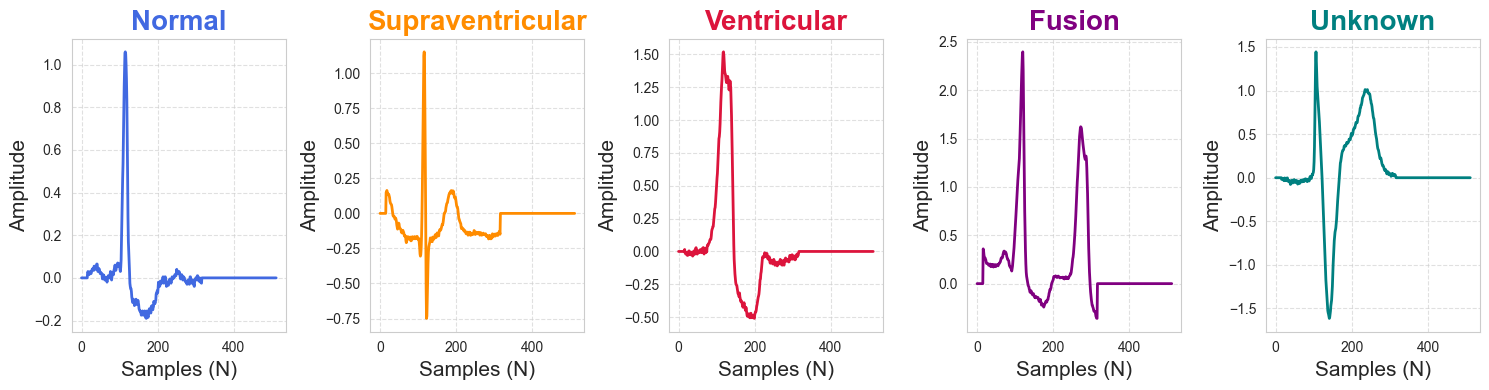

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Seaborn 스타일 적용
sns.set_style("whitegrid")

# 5-Class 라벨 정의 및 색상 설정
label_names = ["Normal", "Supraventricular", "Ventricular", "Fusion", "Unknown"]
colors = ["royalblue", "darkorange", "crimson", "purple", "teal"]

def visualize_ecg_samples_horizontal(y_test, y_test_label):
    """
    각 클래스에서 하나씩 선택하여 가로로 ECG 비트를 시각화합니다.
    
    Parameters:
    y_test: 테스트 데이터셋 (ECG 비트, shape: (num_samples, 512, 1))
    y_test_label: 테스트 데이터셋의 라벨 (5-Class)
    """
    plt.figure(figsize=(15, 4))  # 가로로 배열할 수 있도록 크기 조정

    for class_id in range(5):
        # 해당 클래스에 속하는 인덱스 선택
        class_indices = np.where(y_test_label == class_id)[0]
        if len(class_indices) == 0:
            continue  # 해당 클래스가 없으면 건너뜀

        # 첫 번째 샘플 선택
        idx = class_indices[678]

        # 그래프 그리기
        plt.subplot(1, 5, class_id + 1)  # 한 줄에 5개 배치
        plt.plot(y_test[idx].squeeze(), color=colors[class_id], linewidth=2)
        plt.title(f"{label_names[class_id]}", fontsize=20, fontweight='bold', color=colors[class_id])
        plt.xlabel("Samples (N)", fontsize=15)
        plt.ylabel("Amplitude", fontsize=15)
        plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

# 시각화 실행
visualize_ecg_samples_horizontal(y_test, y_test_label)


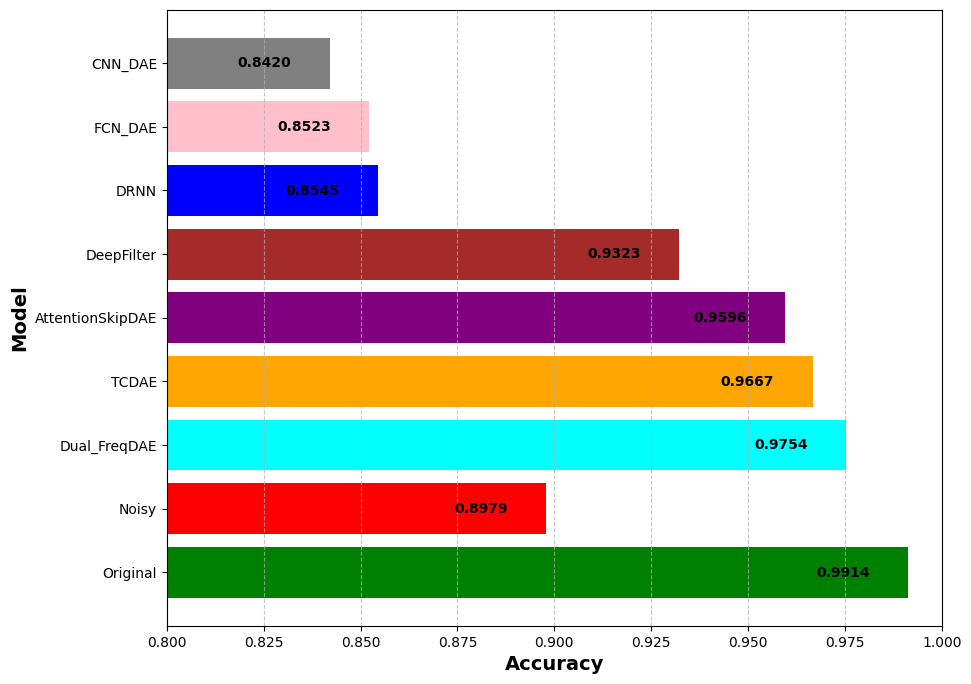

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 모델별 정확도 데이터
models = ["Original", "Noisy", "Dual_FreqDAE", "TCDAE", "AttentionSkipDAE", "DeepFilter", "DRNN", "FCN_DAE", "CNN_DAE"]
accuracies = [0.9914, 0.8979, 0.9754, 0.9667, 0.9596, 0.9323, 0.8545, 0.8523, 0.8420]

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(models, accuracies, color=['green', 'red', 'cyan', 'orange', 'purple', 'brown', 'blue', 'pink', 'gray'])
plt.xlabel("Accuracy",  fontsize=14, fontweight='bold')
plt.ylabel("Model", fontsize=14, fontweight='bold')
# plt.title("Comparison of Classification Accuracy for Different Models", fontsize=14, fontweight='bold')
plt.xlim(0.8, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 정확도 값 표시
for index, value in enumerate(accuracies):
    plt.text(value - 0.01, index, f"{value:.4f}", va='center', ha='right', fontsize=10, color='black', fontweight='bold')

plt.show()

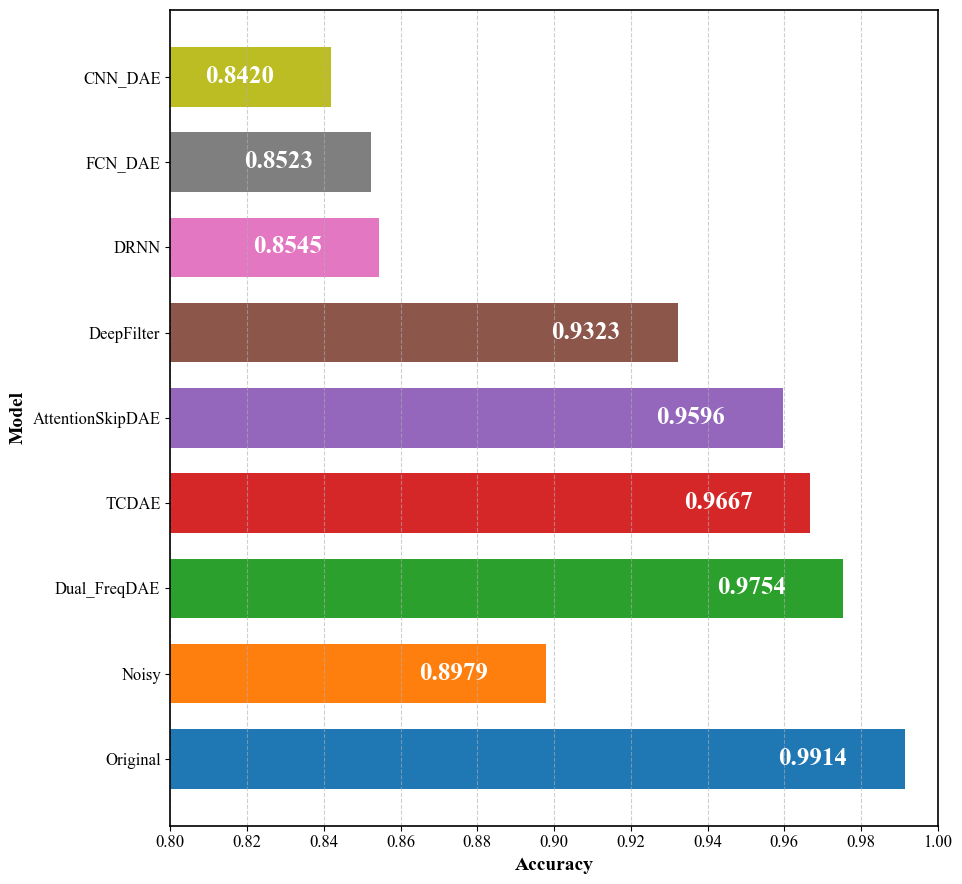

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 모델별 정확도 데이터
models = ["Original", "Noisy", "Dual_FreqDAE", "TCDAE", "AttentionSkipDAE", 
          "DeepFilter", "DRNN", "FCN_DAE", "CNN_DAE"]
accuracies = [0.9914, 0.8979, 0.9754, 0.9667, 0.9596, 
              0.9323, 0.8545, 0.8523, 0.8420]

# 색상 설정 (그레이스케일)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']

# 시각화 설정
plt.figure(figsize=(10, 9))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# 바 차트 생성
bars = plt.barh(models, accuracies, color=colors, height=0.7)

# 축 및 그리드 설정
plt.xlabel("Accuracy", fontsize=14, fontweight='bold')
plt.ylabel("Model", fontsize=14, fontweight='bold')
plt.xlim(0.8, 1.0)
plt.xticks(np.arange(0.8, 1.01, 0.02))
plt.grid(axis='x', linestyle='--', alpha=0.6, linewidth=0.8)

# 정확도 값 표시 (굵게 + 안쪽으로 이동)
for bar, value in zip(bars, accuracies):
    width = bar.get_width()
    plt.text(width - 0.015,  # 숫자를 바 안쪽으로 이동
             bar.get_y() + bar.get_height()/2, 
             f'{value:.4f}', 
             va='center', ha='right',  # 오른쪽 정렬
             fontsize=18, 
             fontweight='bold',  # 굵게 처리
             color='white')  # 흰색으로 가독성 향상

# 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(left=0.2)

# 그래프 표시
plt.show()

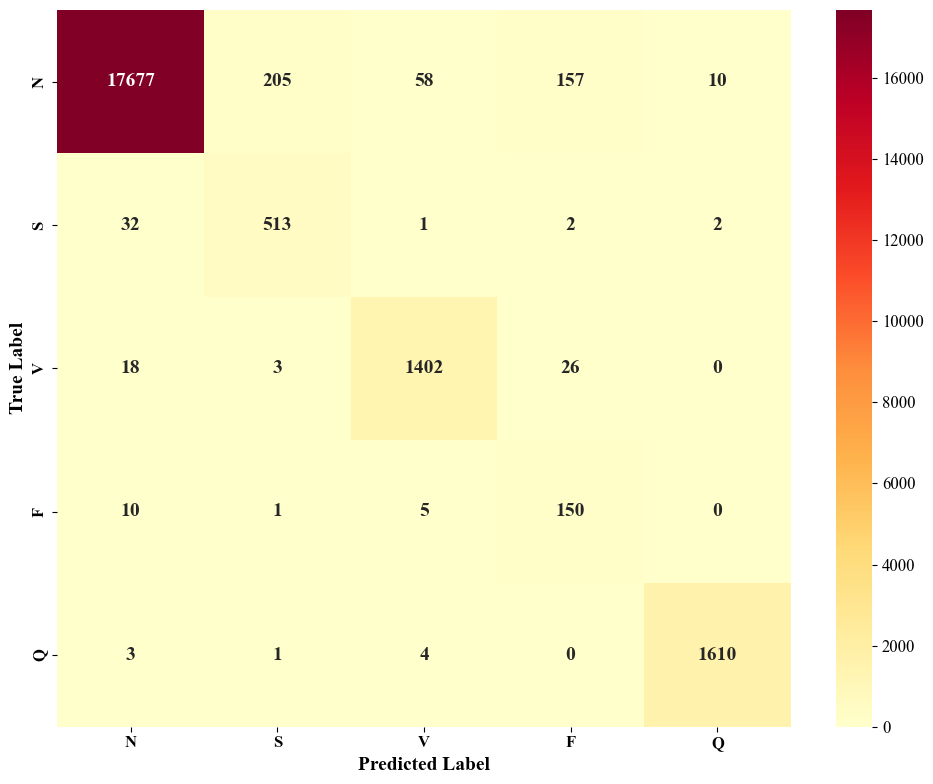

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix 데이터 (Dual_FreqDAE)
conf_matrix = np.array([
    [17677, 205, 58, 157, 10],
    [32, 513, 1, 2, 2],
    [18, 3, 1402, 26, 0],
    [10, 1, 5, 150, 0],
    [3, 1, 4, 0, 1610]
])

# 클래스 라벨
class_labels = ["N", "S", "V", "F", "Q"]

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlOrRd", 
            xticklabels=class_labels, yticklabels=class_labels, 
            annot_kws={"size": 14, "weight": "bold"})  # 숫자 크기 및 강조

# 제목과 축 스타일 조정
# plt.title("Confusion Matrix - Dual_FreqDAE (Denoised Data)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Predicted Label", fontsize=14, fontweight='bold')
plt.ylabel("True Label", fontsize=14, fontweight='bold')

# 눈금 스타일 조정
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# 그래프 표시
plt.tight_layout()
plt.show()


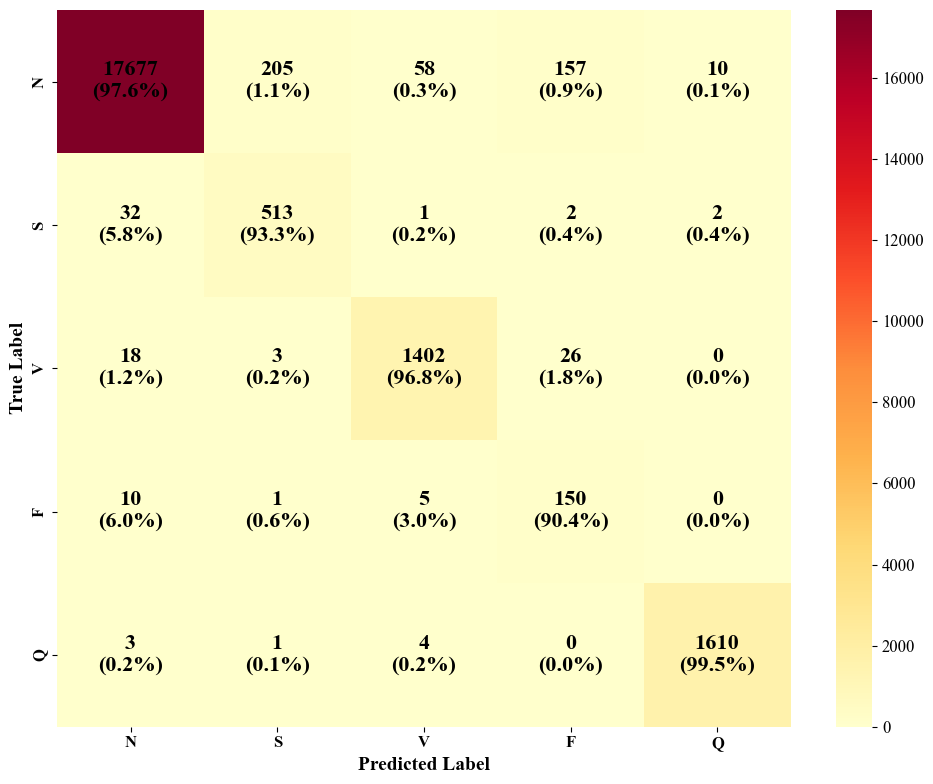

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix 데이터 (Dual_FreqDAE)
conf_matrix = np.array([
    [17677, 205, 58, 157, 10],
    [32, 513, 1, 2, 2],
    [18, 3, 1402, 26, 0],
    [10, 1, 5, 150, 0],
    [3, 1, 4, 0, 1610]
])

# 클래스 라벨
class_labels = ["N", "S", "V", "F", "Q"]

# 각 클래스의 전체 샘플 수
class_totals = np.array([18107, 550, 1449, 166, 1618])

# 백분율로 변환
conf_matrix_percent = conf_matrix / class_totals[:, np.newaxis] * 100

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="YlOrRd", 
            xticklabels=class_labels, yticklabels=class_labels, 
            annot_kws={"size": 14, "weight": "bold"})  # 숫자 크기 및 강조

# 백분율 텍스트 추가
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = f"{conf_matrix[i, j]}\n({conf_matrix_percent[i, j]:.1f}%)"
        plt.text(j + 0.5, i + 0.5, text, 
                 ha="center", va="center", 
                 fontsize=16, fontweight='bold', 
                 color="black")

# 제목과 축 스타일 조정
# plt.title("Confusion Matrix - Dual_FreqDAE (Denoised Data)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Predicted Label", fontsize=14, fontweight='bold')
plt.ylabel("True Label", fontsize=14, fontweight='bold')

# 눈금 스타일 조정
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# 그래프 표시
plt.tight_layout()
plt.show()

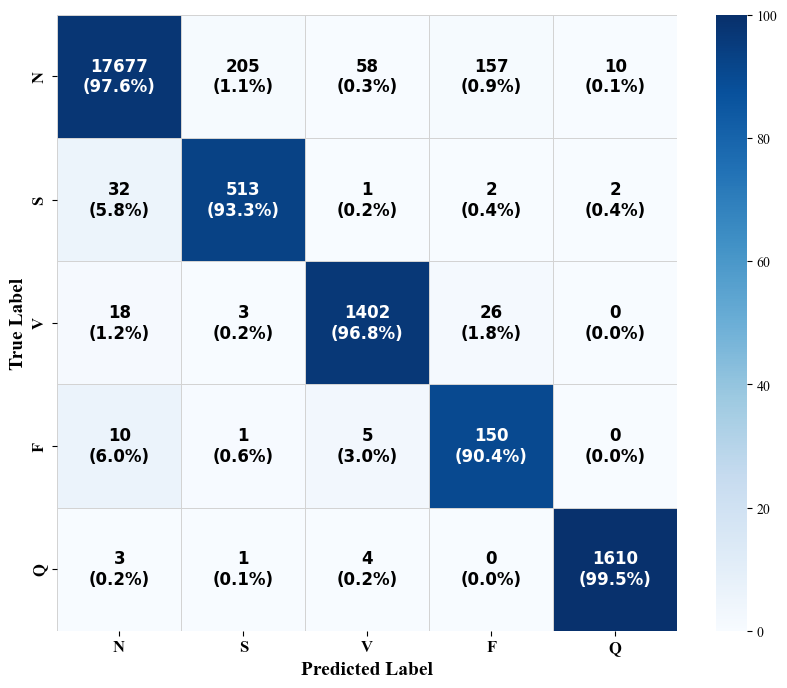

<Figure size 640x480 with 0 Axes>

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# LaTeX 비활성화 + 수학 폰트 설정
plt.rcParams.update({
    "text.usetex": False,  # LaTeX 사용 안 함 (기본값)
    "font.family": "serif",  # 세리프 폰트 (Times New Roman 등)
    "mathtext.fontset": "cm",  # Computer Modern 수학 기호
    "mathtext.it": "serif:italic",  # 기울임체 스타일
})

# Confusion Matrix 데이터
conf_matrix = np.array([
    [17677, 205, 58, 157, 10],
    [32, 513, 1, 2, 2],
    [18, 3, 1402, 26, 0],
    [10, 1, 5, 150, 0],
    [3, 1, 4, 0, 1610]
])

# 클래스 라벨
class_labels = ["N", "S", "V", "F", "Q"]

# 백분율 계산
class_totals = np.array([18107, 550, 1449, 166, 1618])
conf_matrix_percent = conf_matrix / class_totals[:, np.newaxis] * 100

# 시각화 설정
plt.figure(figsize=(10, 8))

# 1. 색상맵 변경 (Blues, Greens, Purples, OrRd, magma, viridis 등 시도해보세요)
cmap = "Blues"  # 깔끔한 파란색 계열 (대각선 강조됨)
# cmap = "viridis"  # 명확한 구분 가능
# cmap = "YlGnBu"  # 밝은 계열 (가시성 좋음)

# 2. Heatmap 생성 (annot=False로 설정하고, 텍스트는 별도로 추가)
ax = sns.heatmap(
    conf_matrix_percent,
    annot=False,
    fmt=".1f",
    cmap=cmap,
    xticklabels=class_labels,
    yticklabels=class_labels,
    vmin=0,
    vmax=100,
    linewidths=0.5,  # 셀 경계선 추가 (가시성 향상)
    linecolor="lightgray",  # 경계선 색상
)

# 3. 텍스트 추가 (원래 글씨체 유지 + 가독성 향상)
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = f"{conf_matrix[i, j]}\n({conf_matrix_percent[i, j]:.1f}%)"
        ax.text(
            j + 0.5,
            i + 0.5,
            text,
            ha="center",
            va="center",
            fontsize=12,  # 원하는 크기로 조정
            fontfamily="DejaVu Sans",  # 기본 글꼴 유지 (맑은 고딕 등 원하는 폰트 지정 가능)
            fontweight="bold",
            color="black" if conf_matrix_percent[i, j] < 70 else "white",  # 배경색 대비되는 글자색
        )

# 4. 축 및 레이아웃 설정
plt.xlabel("Predicted Label", fontsize=14, fontweight="bold")
plt.ylabel("True Label", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")

plt.show()
# 5. 색상바 설정
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

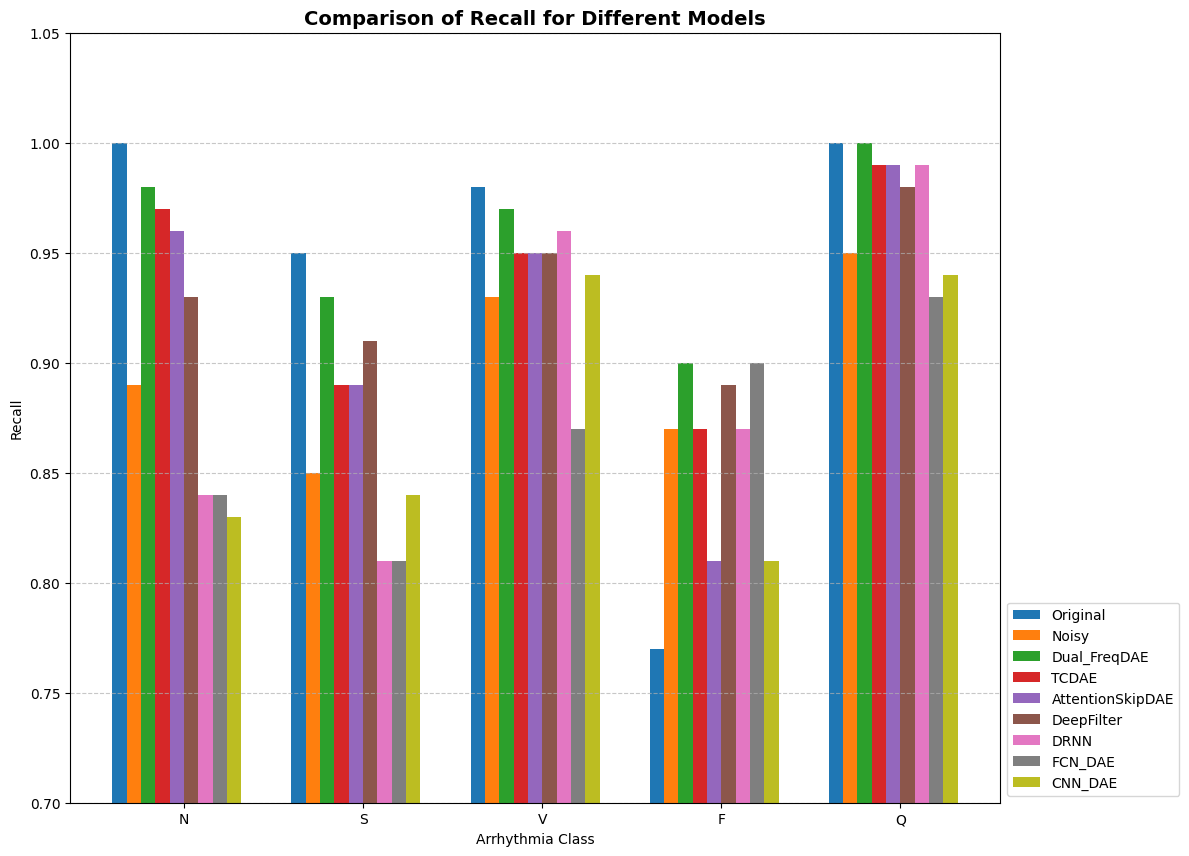

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# 클래스별 Recall 데이터 (각 모델에 대해)
recall_values = {
    "Original": [1.00, 0.95, 0.98, 0.77, 1.00],
    "Noisy": [0.89, 0.85, 0.93, 0.87, 0.95],
    "Dual_FreqDAE": [0.98, 0.93, 0.97, 0.90, 1.00],
    "TCDAE": [0.97, 0.89, 0.95, 0.87, 0.99],
    "AttentionSkipDAE": [0.96, 0.89, 0.95, 0.81, 0.99],
    "DeepFilter": [0.93, 0.91, 0.95, 0.89, 0.98],
    "DRNN": [0.84, 0.81, 0.96, 0.87, 0.99],
    "FCN_DAE": [0.84, 0.81, 0.87, 0.90, 0.93],
    "CNN_DAE": [0.83, 0.84, 0.94, 0.81, 0.94]
}

# 클래스 이름
class_labels = ["N", "S", "V", "F", "Q"]

# 모델 리스트
models = list(recall_values.keys())

# 시각화
x = np.arange(len(class_labels))  # X축 위치
width = 0.08  # 막대 너비

plt.figure(figsize=(12,10))

# 각 모델의 Recall 값 막대 그래프 추가
for i, model in enumerate(models):
    plt.bar(x + i * width, recall_values[model], width, label=model)

# X축 설정
plt.xlabel("Arrhythmia Class")
plt.ylabel("Recall")
plt.title("Comparison of Recall for Different Models", fontsize=14, fontweight='bold')
plt.xticks(x + width * (len(models) / 2), class_labels)
plt.ylim(0.7, 1.05)  # 범위 조정
plt.legend(loc="lower left", bbox_to_anchor=(1, 0))

# 그래프 표시
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


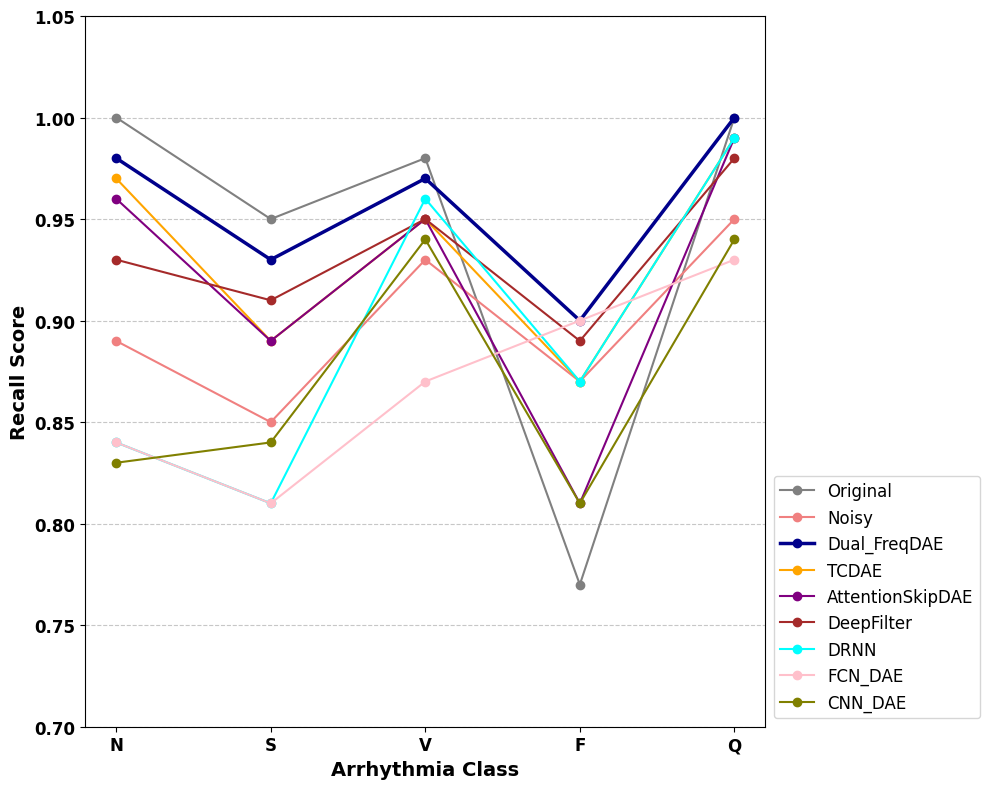

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# 클래스별 Recall 데이터
recall_values = {
    "Original": [1.00, 0.95, 0.98, 0.77, 1.00],
    "Noisy": [0.89, 0.85, 0.93, 0.87, 0.95],
    "Dual_FreqDAE": [0.98, 0.93, 0.97, 0.90, 1.00],  # Dual_FreqDAE 강조
    "TCDAE": [0.97, 0.89, 0.95, 0.87, 0.99],
    "AttentionSkipDAE": [0.96, 0.89, 0.95, 0.81, 0.99],
    "DeepFilter": [0.93, 0.91, 0.95, 0.89, 0.98],
    "DRNN": [0.84, 0.81, 0.96, 0.87, 0.99],
    "FCN_DAE": [0.84, 0.81, 0.87, 0.90, 0.93],
    "CNN_DAE": [0.83, 0.84, 0.94, 0.81, 0.94]
}

# 클래스 이름
class_labels = ["N", "S", "V", "F", "Q"]

# 모델 리스트
models = list(recall_values.keys())

# 색상 지정 (Dual_FreqDAE 강조)
colors = ["gray", "lightcoral", "royalblue", "orange", "purple", "brown", "cyan", "pink", "olive"]
highlight_color = "darkblue"  # Dual_FreqDAE 강조 색상

plt.figure(figsize=(10, 8))

# 각 모델의 Recall 값 막대 그래프 추가
for i, model in enumerate(models):
    color = highlight_color if model == "Dual_FreqDAE" else colors[i % len(colors)]
    plt.plot(class_labels, recall_values[model], marker="o", linestyle="-", label=model, color=color, linewidth=2.5 if model == "Dual_FreqDAE" else 1.5)

# X, Y축 설정
plt.xlabel("Arrhythmia Class", fontsize=14, fontweight='bold')
plt.ylabel("Recall Score", fontsize=14, fontweight='bold')
# plt.title("ECG Arrhythmia Classification Recall Across Models", fontsize=16, fontweight='bold', pad=15)
plt.ylim(0.7, 1.05)

# 범례 설정
plt.legend(loc="lower left", bbox_to_anchor=(1, 0), fontsize=12)

# 눈금 스타일 조정
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# 격자 추가
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()


In [27]:
y_test_padded.shape

(21890,)

In [37]:
def evaluate_model(X, y, model_name):
    print(f"\nEvaluating Model: {model_name}")
    
    # 데이터 분할
    X_train, X_val, y_train, y_val = X, x_test_padded, y, y_test_padded
    X_val = np.expand_dims(X_val, axis=2)

    # 모델 생성 및 학습
    model = build_RTA_CNN(input_shape=(512, 1), num_classes=5)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=60, batch_size=32, verbose=1)

    # 예측 및 성능 평가
    y_pred_val = np.argmax(model.predict(X_val), axis=1)
    cm = confusion_matrix(y_val, y_pred_val)

    # 결과 저장 경로 설정
    result_dir = f"evaluation_results_mitdb_real_real/{model_name.replace(' ', '_')}/"
    create_dir(result_dir)

    # 개선된 Confusion Matrix 시각화 및 저장
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, 
                annot=True, 
                fmt="d", 
                cmap="YlOrRd",  # 더 선명한 컬러맵으로 변경
                xticklabels=["N", "S", "V", "F", "Q"], 
                yticklabels=["N", "S", "V", "F", "Q"],
                annot_kws={"size": 12, "weight": "bold"},  # 숫자 크기와 굵기 조정
                cbar_kws={'label': 'Count'})  # 컬러바 라벨 추가

    # 제목과 라벨 스타일링
    plt.title(f"Confusion Matrix - {model_name}", 
            fontsize=16, 
            pad=20, 
            fontweight='bold')
    plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
    plt.ylabel("True Label", fontsize=12, labelpad=10)

    # 틱 라벨 스타일링
    plt.tick_params(axis='both', labelsize=10)

    # 레이아웃 조정
    plt.tight_layout()

    # 고해상도로 저장
    plt.savefig(os.path.join(result_dir, "confusion_matrix.png"), 
                dpi=300, 
                bbox_inches='tight')
    plt.close()

    # Classification Report 저장 (소수점 두 자리까지 표시)
    report = classification_report(y_val, y_pred_val, digits=2)
    accuracy = accuracy_score(y_val, y_pred_val)
    with open(os.path.join(result_dir, "evaluation_report.txt"), "w") as file:
        file.write(f"Model: {model_name}\n\n")
        file.write("Classification Report:\n")
        file.write(report + "\n")
        file.write(f"Accuracy: {accuracy:.4f}\n")  # 소수점 두 자리까지 표시

    print(f"Results saved to {result_dir}")
    
# [X_test, _, y_pred] = test_DRNN
# evaluate_model(y_pred.squeeze(), y_test_label, "DRNN (Denoised Data)")

# [X_test, _, y_pred] = test_DeepFilter
# evaluate_model(y_pred.squeeze(), y_test_label, "DeepFilter (Denoised Data)")

# [X_test, _, y_pred] = test_CNN_DAE
# evaluate_model(y_pred.squeeze(), y_test_label, "CNN_DAE (Denoised Data)")

# [X_test, _, y_pred] = test_FCN_DAE
# evaluate_model(y_pred.squeeze(), y_test_label, "FCN_DAE (Denoised Data)")

# [X_test, _, y_pred] = test_AttentionSkipDAE
# evaluate_model(y_pred.squeeze(), y_test_label, "AttentionSkipDAE (Denoised Data)")

# [X_test, _, y_pred] = test_Transformer_DAE
# evaluate_model(y_pred.squeeze(), y_test_label, "Transformer_DAE (Denoised Data)")

# Transformer_COMBDAE 평가
[X_test, _, y_pred] = test_Dual_FreqDAE
# evaluate_model(X_test.squeeze(), y_test_label, "Dual_FreqDAE (Noisy Data)")
evaluate_model(y_pred.squeeze(), y_test_label, "Dual_FreqDAE (Denoised Data)")


Evaluating Model: Dual_FreqDAE (Denoised Data)
Epoch 1/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.4608 - loss: 1.3543 - val_accuracy: 0.8751 - val_loss: 0.5395
Epoch 2/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8303 - loss: 0.5145 - val_accuracy: 0.8836 - val_loss: 0.4534
Epoch 3/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8706 - loss: 0.3915 - val_accuracy: 0.8897 - val_loss: 0.4704
Epoch 4/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8883 - loss: 0.3475 - val_accuracy: 0.9359 - val_loss: 0.2140
Epoch 5/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8961 - loss: 0.3186 - val_accuracy: 0.8888 - val_loss: 0.3178
Epoch 6/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9071 - loss: 0.2906 - val_accuracy: 0.9608 - val_loss: 0.1787
Epoch 7/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9104 - loss: 0.2644 - val_accuracy: 0.9569 - val_loss: 0.1429
Epoch 8/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━

In [38]:
import pandas as pd

# y_test_padded를 pandas Series로 변환
y_test_series = pd.Series(y_test_padded)

# 각 레이블의 개수 확인
label_counts = y_test_series.value_counts()

# 결과 출력
print(label_counts)

0    18107
4     1618
2     1449
1      550
3      166
Name: count, dtype: int64


In [58]:
y_test.shape

(40000, 512, 1)

# 폐기처리코드

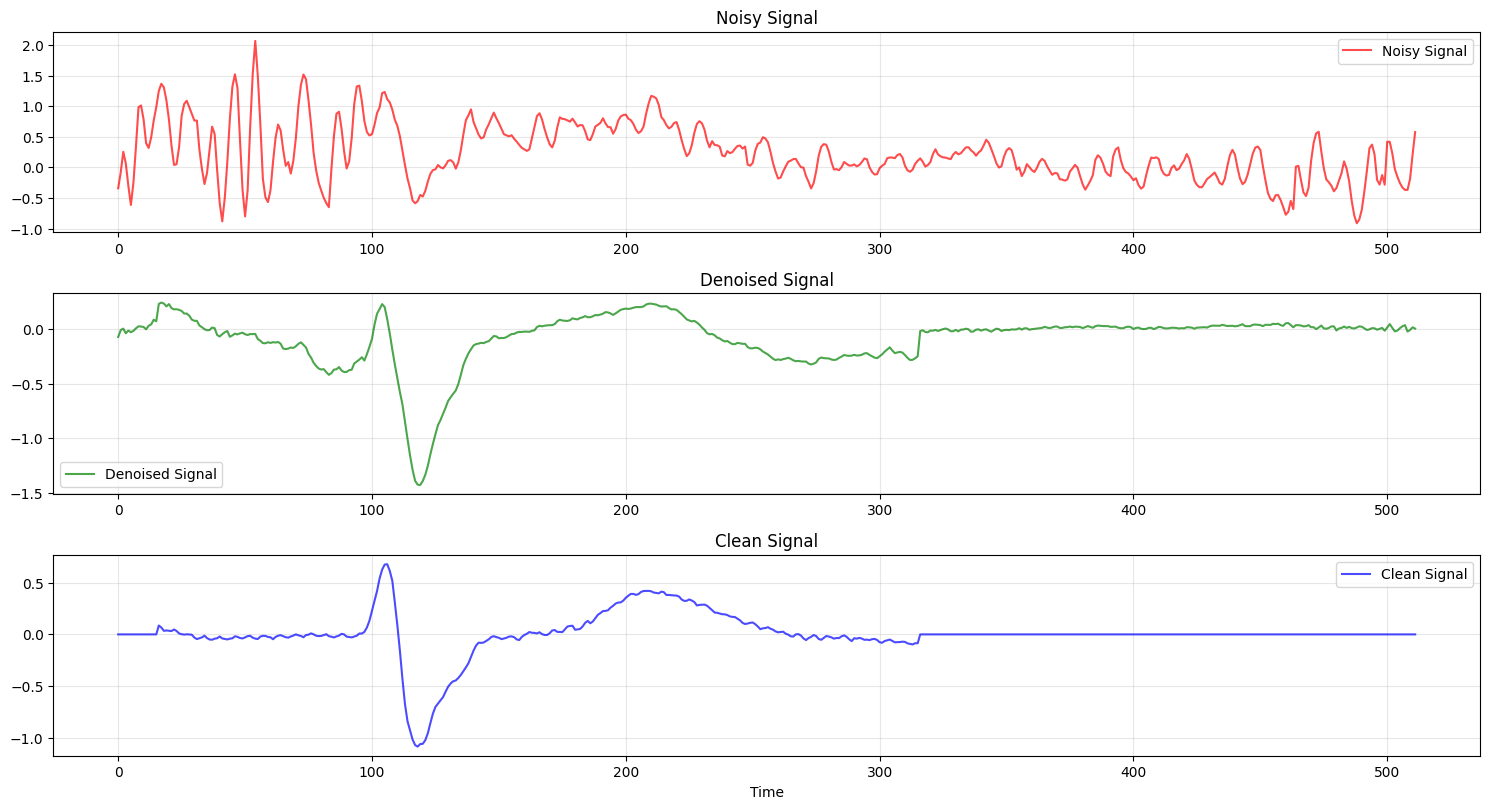

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
[X_test, y_test, y_pred] = test_Dual_FreqDAE

# 시각화 함수 정의
def plot_signal_comparison(X_test, y_test, y_pred, sample_idx=100):
    # 데이터 squeeze
    noisy = X_test.squeeze()[sample_idx]
    clean = y_test.squeeze()[sample_idx]
    denoised = y_pred.squeeze()[sample_idx]
    
    # 시간 축 생성 (샘플 길이에 따라)
    time = np.arange(len(noisy))
    
    # Figure 생성
    plt.figure(figsize=(15, 8))
    
    # 3개의 서브플롯 생성
    plt.subplot(3, 1, 1)
    plt.plot(time, noisy, 'r-', label='Noisy Signal', alpha=0.7)
    plt.title('Noisy Signal')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(time, denoised, 'g-', label='Denoised Signal', alpha=0.7)
    plt.title('Denoised Signal')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(3, 1, 3)
    plt.plot(time, clean, 'b-', label='Clean Signal', alpha=0.7)
    plt.title('Clean Signal')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 레이아웃 조정
    plt.tight_layout()
    
    # 라벨 설정
    plt.xlabel('Time')
    
    # 저장 (필요시)
    plt.savefig('signal_comparison.png', dpi=300)
    plt.show()

# 첫 번째 샘플로 시각화 실행
plot_signal_comparison(X_test, y_test, y_pred, sample_idx=356)



In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from vg_beat_detectors import FastNVG

# def filter_peaks(peaks, min_distance=256):
#     """
#     Too many R-peaks can be problematic. 
#     This function removes peaks that are too close together.
#     min_distance: Minimum number of samples between consecutive peaks.
#     """
#     if len(peaks) == 0:
#         return np.array([])
    
#     filtered_peaks = [peaks[0]]
#     for i in range(1, len(peaks)):
#         if peaks[i] - filtered_peaks[-1] > min_distance:
#             filtered_peaks.append(peaks[i])
#     return np.array(filtered_peaks)

# def calculate_peak_detection_accuracy(y_test, y_pred, sampling_rate=360, tolerance=0.03):
#     """
#     Calculate Peak Detection Accuracy using FastNVG.
#     - y_test: Ground truth ECG signals.
#     - y_pred: Denoised ECG signals.
#     - sampling_rate: ECG sampling rate (default: 360 Hz).
#     - tolerance: Matching window for peak detection (in seconds).
#     Returns:
#     - Accuracy, Precision, Recall, F1-score.
#     """
#     detector = FastNVG(sampling_frequency=sampling_rate)
#     tp, fp, fn = 0, 0, 0

#     for ground_truth, denoised in zip(y_test, y_pred):
#         ground_truth = ground_truth.flatten()
#         denoised = denoised.flatten()

#         # Detect R-peaks
#         gt_peaks = detector.find_peaks(ground_truth)
#         denoised_peaks = detector.find_peaks(denoised)

#         # Apply filtering to remove excessive peaks
#         gt_peaks = filter_peaks(gt_peaks, min_distance=256)
#         denoised_peaks = filter_peaks(denoised_peaks, min_distance=256)

#         # Ensure GT peaks are not greater than the sample length
#         if len(gt_peaks) > len(ground_truth):
#             gt_peaks = gt_peaks[:len(ground_truth)]

#         gt_times = np.array(gt_peaks) / sampling_rate
#         denoised_times = np.array(denoised_peaks) / sampling_rate

#         matched_gt = set()
#         for den_time in denoised_times:
#             if len(gt_times) > 0:
#                 closest_gt_idx = np.argmin(np.abs(gt_times - den_time))
#                 if np.abs(gt_times[closest_gt_idx] - den_time) <= tolerance:
#                     tp += 1
#                     matched_gt.add(closest_gt_idx)
#                 else:
#                     fp += 1
#             else:
#                 fp += 1

#         fn += len(gt_times) - len(matched_gt)  # GT 중 매칭되지 않은 것 (False Negative)

#     precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#     f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
#     accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

#     return {
#         "Accuracy": accuracy,
#         "Precision": precision,
#         "Recall": recall,
#         "F1-Score": f1_score,
#     }

# # def plot_r_peak_detection(y_test, y_pred, model_name, sampling_rate=360, save_dir="fig8", max_samples=8):
# #     """
# #     Plot R-peak detection results using FastNVG.
# #     - TP: Green circles
# #     - FP: Black crosses
# #     - FN: Purple triangles
# #     """
# #     os.makedirs(save_dir, exist_ok=True)

# #     # Concatenate a limited number of samples
# #     y_test_concat = np.concatenate([y.flatten() for y in y_test[500:500+max_samples]])
# #     y_pred_concat = np.concatenate([y.flatten() for y in y_pred[500:500+max_samples]])

# #     # Detect R-peaks using FastNVG
# #     detector = FastNVG(sampling_frequency=sampling_rate)
# #     gt_peaks = detector.find_peaks(y_test_concat)
# #     denoised_peaks = detector.find_peaks(y_pred_concat)

# #     # Apply filtering to remove excessive peaks
# #     gt_peaks = filter_peaks(gt_peaks, min_distance=256)
# #     denoised_peaks = filter_peaks(denoised_peaks, min_distance=256)

# #     gt_times = np.array(gt_peaks) / sampling_rate
# #     denoised_times = np.array(denoised_peaks) / sampling_rate

# #     tp_indices, fp_indices, fn_indices = [], [], []

# #     matched_gt = set()
# #     tolerance = 0.03

# #     for den_time in denoised_times:
# #         if len(gt_times) > 0:
# #             closest_gt_idx = np.argmin(np.abs(gt_times - den_time))
# #             if np.abs(gt_times[closest_gt_idx] - den_time) <= tolerance:
# #                 tp_indices.append(closest_gt_idx)
# #                 matched_gt.add(closest_gt_idx)
# #             else:
# #                 fp_indices.append(den_time)

# #     fn_indices = sorted(set(range(len(gt_times))) - matched_gt)

# #     # Plot the signals and detected peaks
# #     plt.figure(figsize=(30, 15))
# #     plt.plot(y_test_concat, label="Ground Truth Signal", color="blue", linewidth=3)
# #     plt.plot(y_pred_concat, label="Denoised Signal", color="red", linewidth=3)

# #     # TP: Green circles
# #     plt.scatter(
# #         gt_peaks[tp_indices],
# #         y_test_concat[gt_peaks[tp_indices]],
# #         color="green",
# #         label="True Positives (TP)",
# #         s=200,
# #         marker="o",
# #         edgecolors="black",
# #         linewidths=2
# #     )

# #     # FP: Black crosses
# #     plt.scatter(
# #         fp_indices,
# #         y_pred_concat[[int(idx * sampling_rate) for idx in fp_indices]],
# #         color="black",
# #         label="False Positives (FP)",
# #         s=200,
# #         marker="x",
# #         linewidths=3
# #     )

# #     # FN: Purple triangles
# #     plt.scatter(
# #         gt_peaks[fn_indices],
# #         y_test_concat[gt_peaks[fn_indices]],
# #         color="purple",
# #         label="False Negatives (FN)",
# #         s=200,
# #         marker="^",
# #         edgecolors="black",
# #         linewidths=2
# #     )

# #     plt.title(f"R-Peak Detection - {model_name}", fontsize=40)
# #     plt.xlabel("Samples", fontsize=30)
# #     plt.ylabel("Amplitude", fontsize=30)
# #     plt.legend(fontsize=20)
# #     plt.grid(True, linestyle="--", alpha=0.7)

# #     save_path = os.path.join(save_dir, f"{model_name}_R_Peak_Detection.png")
# #     plt.savefig(save_path, bbox_inches="tight")
# #     plt.close()
# #     print(f"Saved R-peak detection plot for {model_name}: {save_path}")



# # Loop through each model and calculate metrics
# for model_name, test_model in model_results.items():
#     y_test, y_pred = test_model[1], test_model[2]

#     y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], -1)
#     y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)

#     # Calculate metrics
#     metrics = calculate_peak_detection_accuracy(y_test, y_pred)
#     print(f"Model: {model_name}\nMetrics: {metrics}\n")

#     # # Plot TP, FP, FN
#     # plot_r_peak_detection(y_test, y_pred, model_name)

NameError: name 'model_results' is not defined

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from vg_beat_detectors import FastNVG

# def filter_peaks(peaks, min_distance=256):
#     """
#     Too many R-peaks can be problematic. 
#     This function removes peaks that are too close together.
#     min_distance: Minimum number of samples between consecutive peaks.
#     """
#     if len(peaks) == 0:
#         return np.array([])
    
#     filtered_peaks = [peaks[0]]
#     for i in range(1, len(peaks)):
#         if peaks[i] - filtered_peaks[-1] > min_distance:
#             filtered_peaks.append(peaks[i])
#     return np.array(filtered_peaks)

# def plot_r_peak_detection(y_test, y_pred, model_name, sampling_rate=360, save_dir="fig16", max_samples=6):
#     """
#     Plot R-peak detection results using FastNVG.
#     - TP: Green circles
#     - FP: Black crosses
#     - FN: Purple triangles
#     """
#     os.makedirs(save_dir, exist_ok=True)

#     # Concatenate a limited number of samples
#     y_test_concat = np.concatenate([y.flatten() for y in y_test[500:500+max_samples]])
#     y_pred_concat = np.concatenate([y.flatten() for y in y_pred[500:500+max_samples]])

#     # Detect R-peaks using FastNVG
#     detector = FastNVG(sampling_frequency=sampling_rate)
#     gt_peaks = detector.find_peaks(y_test_concat)
#     denoised_peaks = detector.find_peaks(y_pred_concat)

#     # Apply filtering to remove excessive peaks
#     gt_peaks = filter_peaks(gt_peaks, min_distance=256)
#     denoised_peaks = filter_peaks(denoised_peaks, min_distance=256)

#     gt_times = np.array(gt_peaks) / sampling_rate
#     denoised_times = np.array(denoised_peaks) / sampling_rate

#     tp_indices, fp_indices, fn_indices = [], [], []

#     matched_gt = set()
#     tolerance = 0.03

#     for den_time in denoised_times:
#         if len(gt_times) > 0:
#             closest_gt_idx = np.argmin(np.abs(gt_times - den_time))
#             if np.abs(gt_times[closest_gt_idx] - den_time) <= tolerance:
#                 tp_indices.append(closest_gt_idx)
#                 matched_gt.add(closest_gt_idx)
#             else:
#                 fp_indices.append(den_time)

#     fn_indices = sorted(set(range(len(gt_times))) - matched_gt)

#     # Plot the signals and detected peaks
#     plt.figure(figsize=(30, 15))
#     plt.plot(y_test_concat, label="Ground Truth Signal", color="blue", linewidth=3)
#     plt.plot(y_pred_concat, label="Denoised Signal", color="red", linewidth=3)

#     # TP: Green circles
#     plt.scatter(
#         gt_peaks[tp_indices],
#         y_test_concat[gt_peaks[tp_indices]],
#         color="green",
#         label="True Positives (TP)",
#         s=200,
#         marker="o",
#         edgecolors="black",
#         linewidths=2
#     )

#     # FP: Black crosses
#     plt.scatter(
#         fp_indices,
#         y_pred_concat[[int(idx * sampling_rate) for idx in fp_indices]],
#         color="black",
#         label="False Positives (FP)",
#         s=200,
#         marker="x",
#         linewidths=3
#     )

#     # FN: Purple triangles
#     plt.scatter(
#         gt_peaks[fn_indices],
#         y_test_concat[gt_peaks[fn_indices]],
#         color="purple",
#         label="False Negatives (FN)",
#         s=200,
#         marker="^",
#         edgecolors="black",
#         linewidths=2
#     )

#     plt.title(f"R-Peak Detection - {model_name}", fontsize=40)
#     plt.xlabel("Samples", fontsize=30)
#     plt.ylabel("Amplitude", fontsize=30)
#     plt.legend(fontsize=20)
#     plt.grid(True, linestyle="--", alpha=0.7)

#     save_path = os.path.join(save_dir, f"{model_name}_R_Peak_Detection.png")
#     plt.savefig(save_path, bbox_inches="tight")
#     plt.close()
#     print(f"Saved R-peak detection plot for {model_name}: {save_path}")



# # Loop through each model and calculate metrics
# for model_name, test_model in model_results.items():
#     y_test, y_pred = test_model[1], test_model[2]
#     y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], -1)
#     y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)
#     # Plot TP, FP, FN
#     plot_r_peak_detection(y_test, y_pred, model_name)

Saved R-peak detection plot for Dual_FreqDAE: fig8/Dual_FreqDAE_R_Peak_Detection.png


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# import pickle
# from vg_beat_detectors import FastNVG
# # 모델 결과 로드
# model_results = {}
# dl_experiments = ['DRNN', 'DeepFilter', 'CNN_DAE', 'FCN_DAE', 'AttentionSkipDAE', 'Transformer_DAE', 'Dual_FreqDAE']

# for model_name in dl_experiments:
#     file_path = f"0302/mitdb_test_results_{model_name}.pkl"
#     with open(file_path, 'rb') as input_file:
#         model_results[model_name] = pickle.load(input_file)

# def filter_peaks(peaks, min_distance=256):
#     """ Removes peaks that are too close together. """
#     if len(peaks) == 0:
#         return np.array([])
    
#     filtered_peaks = [peaks[0]]
#     for i in range(1, len(peaks)):
#         if peaks[i] - filtered_peaks[-1] > min_distance:
#             filtered_peaks.append(peaks[i])
#     return np.array(filtered_peaks)

# def detect_r_peaks(y_test, y_pred, sampling_rate=360, tolerance=0.05):
#     """
#     Detect R-peaks and classify them as TP, FP, FN.
#     """
#     detector = FastNVG(sampling_frequency=sampling_rate)

#     gt_peaks = detector.find_peaks(y_test.flatten())
#     pred_peaks = detector.find_peaks(y_pred.flatten())

#     # Apply filtering
#     gt_peaks = filter_peaks(gt_peaks, min_distance=256)
#     pred_peaks = filter_peaks(pred_peaks, min_distance=256)

#     gt_times = np.array(gt_peaks) / sampling_rate
#     pred_times = np.array(pred_peaks) / sampling_rate

#     tp_indices = set()
#     fp_indices = []
#     fn_indices = []

#     for pred_time in pred_times:
#         if len(gt_times) > 0:
#             closest_gt_idx = np.argmin(np.abs(gt_times - pred_time))
#             if np.abs(gt_times[closest_gt_idx] - pred_time) <= tolerance:
#                 tp_indices.add(gt_times[closest_gt_idx])
#             else:
#                 fp_indices.append(pred_time)
#         else:
#             fp_indices.append(pred_time)

#     fn_indices = [gt_times[i] for i in range(len(gt_times)) if gt_times[i] not in tp_indices]

#     return list(tp_indices), fp_indices, fn_indices

# def compare_all_samples(model_results, sampling_rate=360, save_dir="full_comparison"):
#     """
#     Compare Transformer_COMBDAE TP with other models and visualize FP/FN for all samples.
#     """
#     os.makedirs(save_dir, exist_ok=True)

#     # Get Transformer_COMBDAE TP indices for all samples
#     combdae_tp_samples = {}

#     for i, (y_test, y_pred) in enumerate(zip(model_results["Dual_FreqDAE"][1], model_results["Dual_FreqDAE"][2])):
#         tp_indices, _, _ = detect_r_peaks(y_test, y_pred, sampling_rate)
#         combdae_tp_samples[i] = tp_indices  # 저장

#     # Compare all models
#     for model_name, test_model in model_results.items():
#         if model_name == "Dual_FreqDAE":
#             continue  # Skip Transformer_COMBDAE

#         all_fp = []
#         all_fn = []

#         for i, (y_test, y_pred) in enumerate(zip(test_model[1], test_model[2])):
#             _, fp_indices, fn_indices = detect_r_peaks(y_test, y_pred, sampling_rate)

#             # TP 인덱스를 Transformer_COMBDAE 기준으로 비교
#             tp_combdae = combdae_tp_samples.get(i, [])
#             if not tp_combdae:
#                 continue  # Transformer_COMBDAE에서 TP가 없는 경우 스킵

#             for tp in tp_combdae:
#                 if tp in fp_indices:
#                     all_fp.append(tp)
#                 if tp in fn_indices:
#                     all_fn.append(tp)

#         # 시각화
#         plt.figure(figsize=(15, 8))

#         if len(all_fp) > 0 or len(all_fn) > 0:
#             plt.hist(all_fp, bins=20, alpha=0.6, label="False Positives (FP)", color="black")
#             plt.hist(all_fn, bins=20, alpha=0.6, label="False Negatives (FN)", color="purple")
#         else:
#             plt.text(0.5, 0.5, "No FP/FN detected", fontsize=18, ha='center')

#         plt.xlabel("Sample Index")
#         plt.ylabel("Count")
#         plt.title(f"FP/FN Distribution for {model_name}")
#         plt.legend()
#         plt.grid(True, linestyle="--", alpha=0.7)

#         save_path = os.path.join(save_dir, f"FP_FN_Distribution_{model_name}.png")
#         plt.savefig(save_path, bbox_inches="tight")
#         plt.close()
#         print(f"Saved FP/FN distribution for {model_name}: {save_path}")

# # 실행
# compare_all_samples(model_results)




Saved FP/FN distribution for DRNN: full_comparison/FP_FN_Distribution_DRNN.png
Saved FP/FN distribution for DeepFilter: full_comparison/FP_FN_Distribution_DeepFilter.png
Saved FP/FN distribution for CNN_DAE: full_comparison/FP_FN_Distribution_CNN_DAE.png
Saved FP/FN distribution for FCN_DAE: full_comparison/FP_FN_Distribution_FCN_DAE.png
Saved FP/FN distribution for AttentionSkipDAE: full_comparison/FP_FN_Distribution_AttentionSkipDAE.png
Saved FP/FN distribution for Transformer_DAE: full_comparison/FP_FN_Distribution_Transformer_DAE.png


In [ ]:
# # ------------------------
# # SMOTE 적용 (Class 1~4는 각각 50000개로 oversample, Class 0도 50000개로 맞춤)
# # ------------------------
# X_class0 = X_data[y_data == 0]
# X_class_others = X_data[y_data != 0]
# y_class0 = y_data[y_data == 0]
# y_class_others = y_data[y_data != 0]

# # Class 0에서 50000개 랜덤 샘플링
# X_class0_resampled, y_class0_resampled = resample(X_class0, y_class0, n_samples=40000, random_state=42)

# # SMOTE로 Class 1~4를 각각 50000개로 oversample
# smote_strategy = {1: 40000, 2: 40000, 3: 40000, 4: 40000}
# smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
# X_oversampled, y_oversampled = smote.fit_resample(X_class_others, y_class_others)

# # Resampled 데이터 합치기
# X_balanced = np.vstack((X_class0_resampled, X_oversampled))
# y_balanced = np.hstack((y_class0_resampled, y_oversampled))

# # 클래스 분포 확인 (SMOTE 후)
# class_counts_after = Counter(y_balanced)
# print("After SMOTE - Class Distribution:", class_counts_after)

# # ------------------------
# # dict 구조로 변환 (균형 잡힌 데이터를 다시 dict로 저장)
# # ------------------------
# balanced_dict = {}
# for i in range(len(X_balanced)):
#     pid = f"balanced_{i // 1000}"  # 새로운 환자 ID 형식
#     if pid not in balanced_dict:
#         balanced_dict[pid] = []
#     balanced_dict[pid].append((X_balanced[i], y_balanced[i]))

# # ------------------------
# # 데이터 저장 (Balanced 데이터셋)
# # ------------------------
# with open('data/MITDatabase_balanced.pkl', 'wb') as output:
#     pickle.dump(balanced_dict, output)
# print("Balanced MIT-BIH database saved as pickle file (dict format).")

# # ------------------------
# # 클래스 분포 시각화
# # ------------------------
# plt.bar(class_counts_after.keys(), class_counts_after.values(), color='maroon')
# plt.xticks(range(5), ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
# plt.xlabel("Class")
# plt.ylabel("Frequency")
# plt.title("Balanced Class Distribution after SMOTE")
# plt.show()


데이터 타입: <class 'dict'>


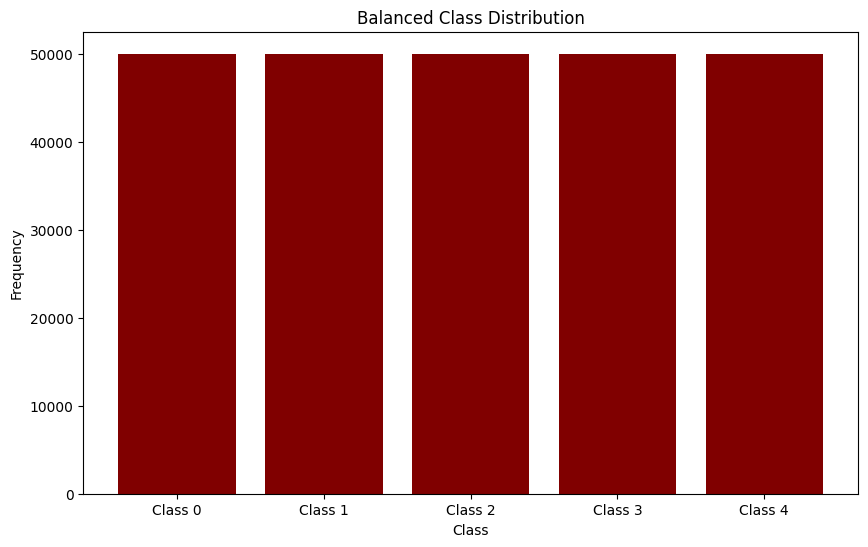

Class Distribution: Counter({4.0: 50000, 0.0: 50000, 2.0: 50000, 3.0: 50000, 1.0: 50000})


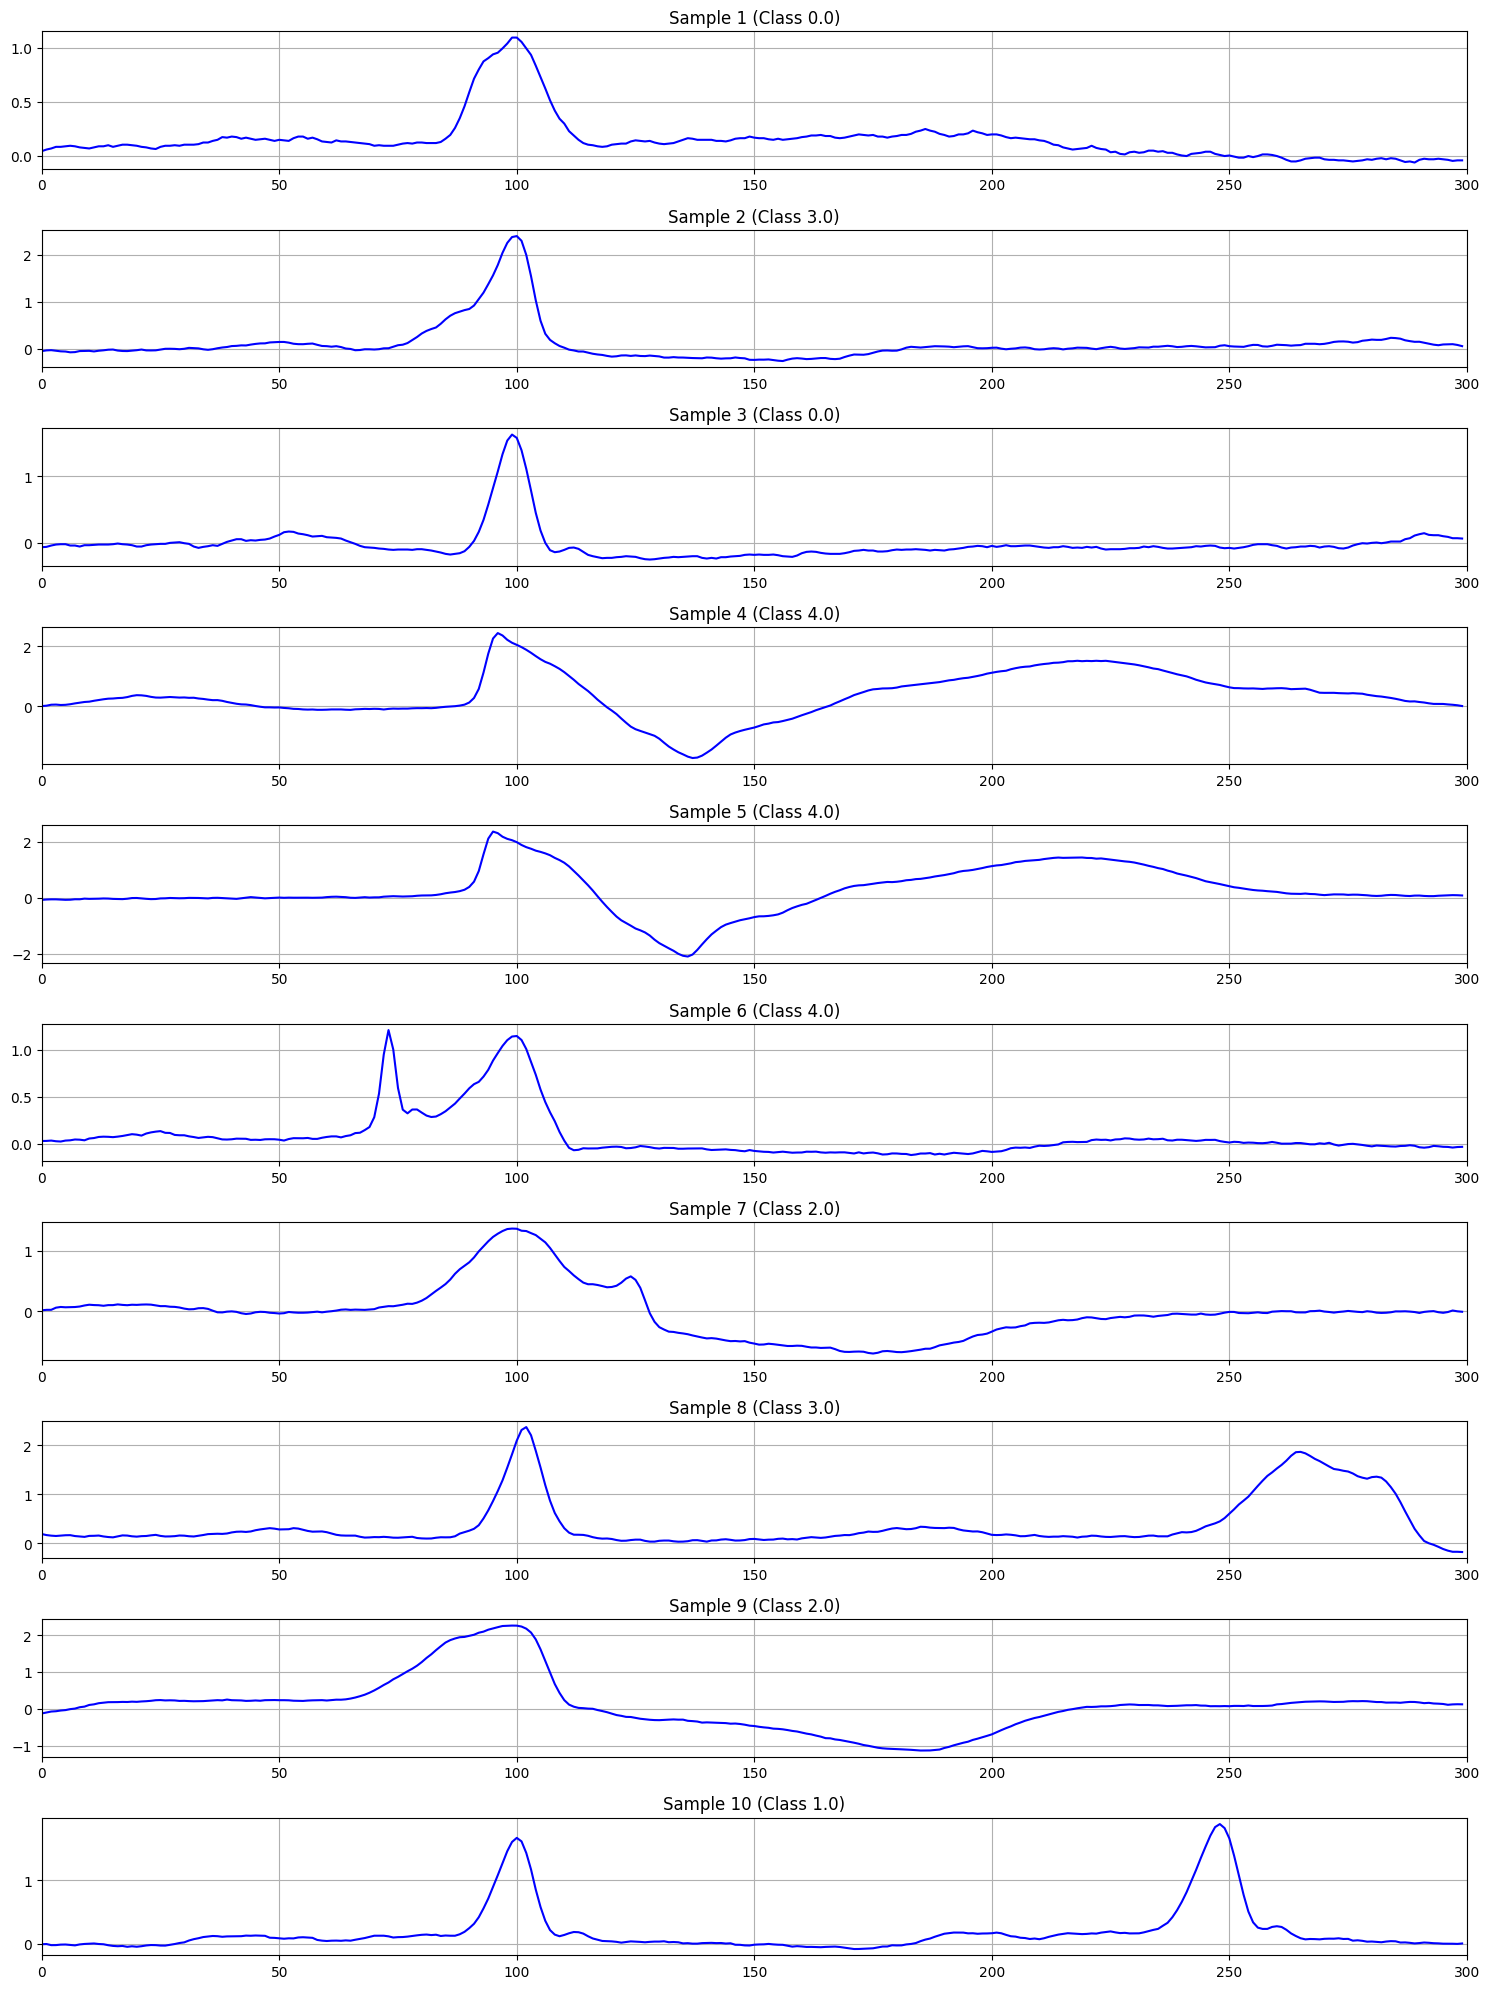

In [ ]:
# import matplotlib.pyplot as plt
# import random
# from collections import Counter
# import _pickle as pickle

# # pickle 파일 열기
# with open('data/MITDatabase_balanced_20250302.pkl', 'rb') as file:
#     data = pickle.load(file)

# # 데이터 타입과 구조 확인
# print("데이터 타입:", type(data))

# # ------------------------
# # 클래스 분포 시각화 함수
# # ------------------------
# def plot_class_distribution(data_dict):
#     all_labels = [label for beats in data_dict.values() for _, label in beats]
#     class_counts = Counter(all_labels)
    
#     plt.figure(figsize=(10, 6))
#     plt.bar(class_counts.keys(), class_counts.values(), color='maroon')
#     plt.xticks(range(5), ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
#     plt.xlabel("Class")
#     plt.ylabel("Frequency")
#     plt.title("Balanced Class Distribution")
#     plt.show()
    
#     print("Class Distribution:", class_counts)

# # ------------------------
# # 랜덤 ECG 샘플 시각화 함수
# # ------------------------
# def plot_random_ecg_samples(data_dict, num_samples=10):
#     samples = []
#     for beats in data_dict.values():
#         samples.extend(beats)
    
#     # 랜덤으로 num_samples만큼 샘플 추출
#     random_samples = random.sample(samples, num_samples)
    
#     fig, axes = plt.subplots(num_samples, 1, figsize=(15, num_samples * 2))
#     for i, (ecg, label) in enumerate(random_samples):
#         axes[i].plot(ecg, color='blue')
#         axes[i].set_title(f"Sample {i+1} (Class {label})")
#         axes[i].set_xlim(0, 300)
#         axes[i].grid(True)
    
#     plt.tight_layout()
#     plt.show()

# # ------------------------
# # 시각화 실행
# # ------------------------
# plot_class_distribution(data)
# plot_random_ecg_samples(data, num_samples=10)


In [ ]:
import _pickle as pickle

# 파일 로드
file_path = 'data/MITDatabase_balanced_20250302.pkl'
with open(file_path, 'rb') as input_file:
    balanced_dict = pickle.load(input_file)

# 1. Keys 확인
print("=== Dictionary Keys (Patient IDs) ===")
keys = list(balanced_dict.keys())
print("Total number of keys:", len(keys))
print("First 5 keys:", keys[:5])
print("Last 5 keys:", keys[-5:])
print()

# 2. Values 확인 (샘플로 몇 개만 출력)
print("=== Sample Values (Beats and Labels) ===")
# 처음 3개 환자 ID의 값에서 각각 2개씩 샘플 출력
for pid in keys[:3]:
    print(f"Patient ID: {pid}")
    values = balanced_dict[pid][:2]  # 처음 2개만 확인
    for beat, label in values:
        print(f"  - Beat Shape: {beat.shape}, Label: {label}")
    print()

=== Dictionary Keys (Patient IDs) ===
Total number of keys: 250
First 5 keys: ['balanced_0', 'balanced_1', 'balanced_2', 'balanced_3', 'balanced_4']
Last 5 keys: ['balanced_245', 'balanced_246', 'balanced_247', 'balanced_248', 'balanced_249']

=== Sample Values (Beats and Labels) ===
Patient ID: balanced_0
  - Beat Shape: (300,), Label: 4.0
  - Beat Shape: (300,), Label: 1.0

Patient ID: balanced_1
  - Beat Shape: (300,), Label: 3.0
  - Beat Shape: (300,), Label: 0.0

Patient ID: balanced_2
  - Beat Shape: (300,), Label: 2.0
  - Beat Shape: (300,), Label: 4.0



In [ ]:
def evaluate_model(X, y, model_name):
    print(f"\nEvaluating Model: {model_name}")
    
    # 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)
    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)

    # 모델 생성 및 학습
    model = build_RTA_CNN(input_shape=(512, 1), num_classes=5)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=32, verbose=1)

    # X_test 변환 (300 샘플 -> 512 샘플로 패딩 및 중심화)
    if X_test is not None and y_test is not None:
        samples = 512
        init_padding = 16
        x_test_processed = np.zeros((X_test.shape[0], samples))  # (None, 512) 크기 배열 생성
        
        for i, beat in enumerate(X_test):  # 각 비트(300 샘플)에 대해 처리
            b_sq = np.array(beat)  # (300,) 형태의 비트 데이터
            if b_sq.shape[0] > (samples - init_padding):  # 길이 초과 시 스킵
                continue
            # 패딩 및 중심화 적용
            x_test_processed[i, init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2
        
        # (None, 512, 1) 형태로 차원 확장
        x_test_processed = np.expand_dims(x_test_processed, axis=2)

        # 예측 및 성능 평가
        y_pred_val = np.argmax(model.predict(x_test_processed), axis=1)
        cm = confusion_matrix(y_test, y_pred_val)

        # 결과 저장 경로 설정
        result_dir = f"evaluation_results_mitdb_real_final/{model_name.replace(' ', '_')}/"
        create_dir(result_dir)

        # 개선된 Confusion Matrix 시각화 및 저장
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, 
                    annot=True, 
                    fmt="d", 
                    cmap="YlOrRd",
                    xticklabels=["N", "S", "V", "F", "Q"], 
                    yticklabels=["N", "S", "V", "F", "Q"],
                    annot_kws={"size": 12, "weight": "bold"},
                    cbar_kws={'label': 'Count'})

        plt.title(f"Confusion Matrix - {model_name}", fontsize=16, pad=20, fontweight='bold')
        plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
        plt.ylabel("True Label", fontsize=12, labelpad=10)
        plt.tick_params(axis='both', labelsize=10)
        plt.tight_layout()
        plt.savefig(os.path.join(result_dir, "confusion_matrix.png"), dpi=300, bbox_inches='tight')
        plt.close()

        # Classification Report 저장
        report = classification_report(y_test, y_pred_val, digits=2)
        accuracy = accuracy_score(y_test, y_pred_val)
        with open(os.path.join(result_dir, "evaluation_report.txt"), "w") as file:
            file.write(f"Model: {model_name}\n\n")
            file.write("Classification Report:\n")
            file.write(report + "\n")
            file.write(f"Accuracy: {accuracy:.4f}\n")

        print(f"Results saved to {result_dir}")
    

[X_test, _, y_pred] = test_Dual_FreqDAE

evaluate_model(y_pred.squeeze(), y_test_label, "Dual_FreqDAE (Denoised Data)")


Evaluating Model: Dual_FreqDAE (Denoised Data)
Epoch 1/2
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3954 - loss: 1.5246 - val_accuracy: 0.7390 - val_loss: 0.6523
Epoch 2/2
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7691 - loss: 0.6388 - val_accuracy: 0.8587 - val_loss: 0.3968
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


ValueError: Found input variables with inconsistent numbers of samples: [21890, 40000]

In [ ]:
# def evaluate_model(X, y, model_name):
#     print(f"\nEvaluating Model: {model_name}")
    
#     # 데이터 분할
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)
#     X_train = np.expand_dims(X_train, axis=2)
#     X_val = np.expand_dims(X_val, axis=2)

#     # 모델 생성 및 학습
#     model = build_RTA_CNN(input_shape=(512, 1), num_classes=5)
#     history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=60, batch_size=32, verbose=1)

#     # 예측 및 성능 평가
#     y_pred_val = np.argmax(model.predict(X_val), axis=1)
#     cm = confusion_matrix(y_val, y_pred_val)

#     # 결과 저장 경로 설정
#     result_dir = f"evaluation_results_mitdb_real/{model_name.replace(' ', '_')}/"
#     create_dir(result_dir)

#     # 개선된 Confusion Matrix 시각화 및 저장
#     plt.figure(figsize=(12, 10))
#     sns.heatmap(cm, 
#                 annot=True, 
#                 fmt="d", 
#                 cmap="YlOrRd",  # 더 선명한 컬러맵으로 변경
#                 xticklabels=["N", "S", "V", "F", "Q"], 
#                 yticklabels=["N", "S", "V", "F", "Q"],
#                 annot_kws={"size": 12, "weight": "bold"},  # 숫자 크기와 굵기 조정
#                 cbar_kws={'label': 'Count'})  # 컬러바 라벨 추가

#     # 제목과 라벨 스타일링
#     plt.title(f"Confusion Matrix - {model_name}", 
#             fontsize=16, 
#             pad=20, 
#             fontweight='bold')
#     plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
#     plt.ylabel("True Label", fontsize=12, labelpad=10)

#     # 틱 라벨 스타일링
#     plt.tick_params(axis='both', labelsize=10)

#     # 레이아웃 조정
#     plt.tight_layout()

#     # 고해상도로 저장
#     plt.savefig(os.path.join(result_dir, "confusion_matrix.png"), 
#                 dpi=300, 
#                 bbox_inches='tight')
#     plt.close()

#     # Classification Report 저장 (소수점 두 자리까지 표시)
#     report = classification_report(y_val, y_pred_val, digits=2)
#     accuracy = accuracy_score(y_val, y_pred_val)
#     with open(os.path.join(result_dir, "evaluation_report.txt"), "w") as file:
#         file.write(f"Model: {model_name}\n\n")
#         file.write("Classification Report:\n")
#         file.write(report + "\n")
#         file.write(f"Accuracy: {accuracy:.4f}\n")  # 소수점 두 자리까지 표시

#     print(f"Results saved to {result_dir}")
    

# # [X_test, y_test, y_pred] = test_DRNN
# # evaluate_model(y_pred.squeeze(), y_test_label, "DRNN (Denoised Data)")

# # [X_test, y_test, y_pred] = test_DeepFilter
# # evaluate_model(y_pred.squeeze(), y_test_label, "DeepFilter (Denoised Data)")

# # [X_test, y_test, y_pred] = test_CNN_DAE
# # evaluate_model(y_pred.squeeze(), y_test_label, "CNN_DAE (Denoised Data)")

# # [X_test, y_test, y_pred] = test_FCN_DAE
# # evaluate_model(y_pred.squeeze(), y_test_label, "FCN_DAE (Denoised Data)")

# # [X_test, y_test, y_pred] = test_AttentionSkipDAE
# # evaluate_model(y_pred.squeeze(), y_test_label, "AttentionSkipDAE (Denoised Data)")

# # [X_test, y_test, y_pred] = test_Transformer_DAE
# # evaluate_model(y_pred.squeeze(), y_test_label, "Transformer_DAE (Denoised Data)")

# # # Transformer_COMBDAE 평가
# # [X_test, y_test, y_pred] = test_Dual_FreqDAE
# # evaluate_model(X_test.squeeze(), y_test_label, "Dual_FreqDAE (Noisy Data)")
# # evaluate_model(y_test.squeeze(), y_test_label, "Dual_FreqDAE (Original Data)")
# # evaluate_model(y_pred.squeeze(), y_test_label, "Dual_FreqDAE (Denoised Data)")

In [ ]:
# #비교 방식 수정
# → np.isin() 대신에 각 y_test[idx]와 sel123_data의 샘플 간 L2 norm 거리를 계산하여 일정 거리 이하인 샘플을 sel123_indices로 선택하면 됨.
sel123_data = qtdb["sel123"]  # 'sel123' 데이터 가져오기
sel123_data = np.array([s[:512] if len(s) >= 512 else np.pad(s, (0, 512 - len(s)), 'constant') for s in sel123_data])  # 길이 맞추기

print(f"[INFO] 'sel123' 데이터 크기: {sel123_data.shape}")  # (643, 512)

[INFO] 'sel123' 데이터 크기: (643, 512)


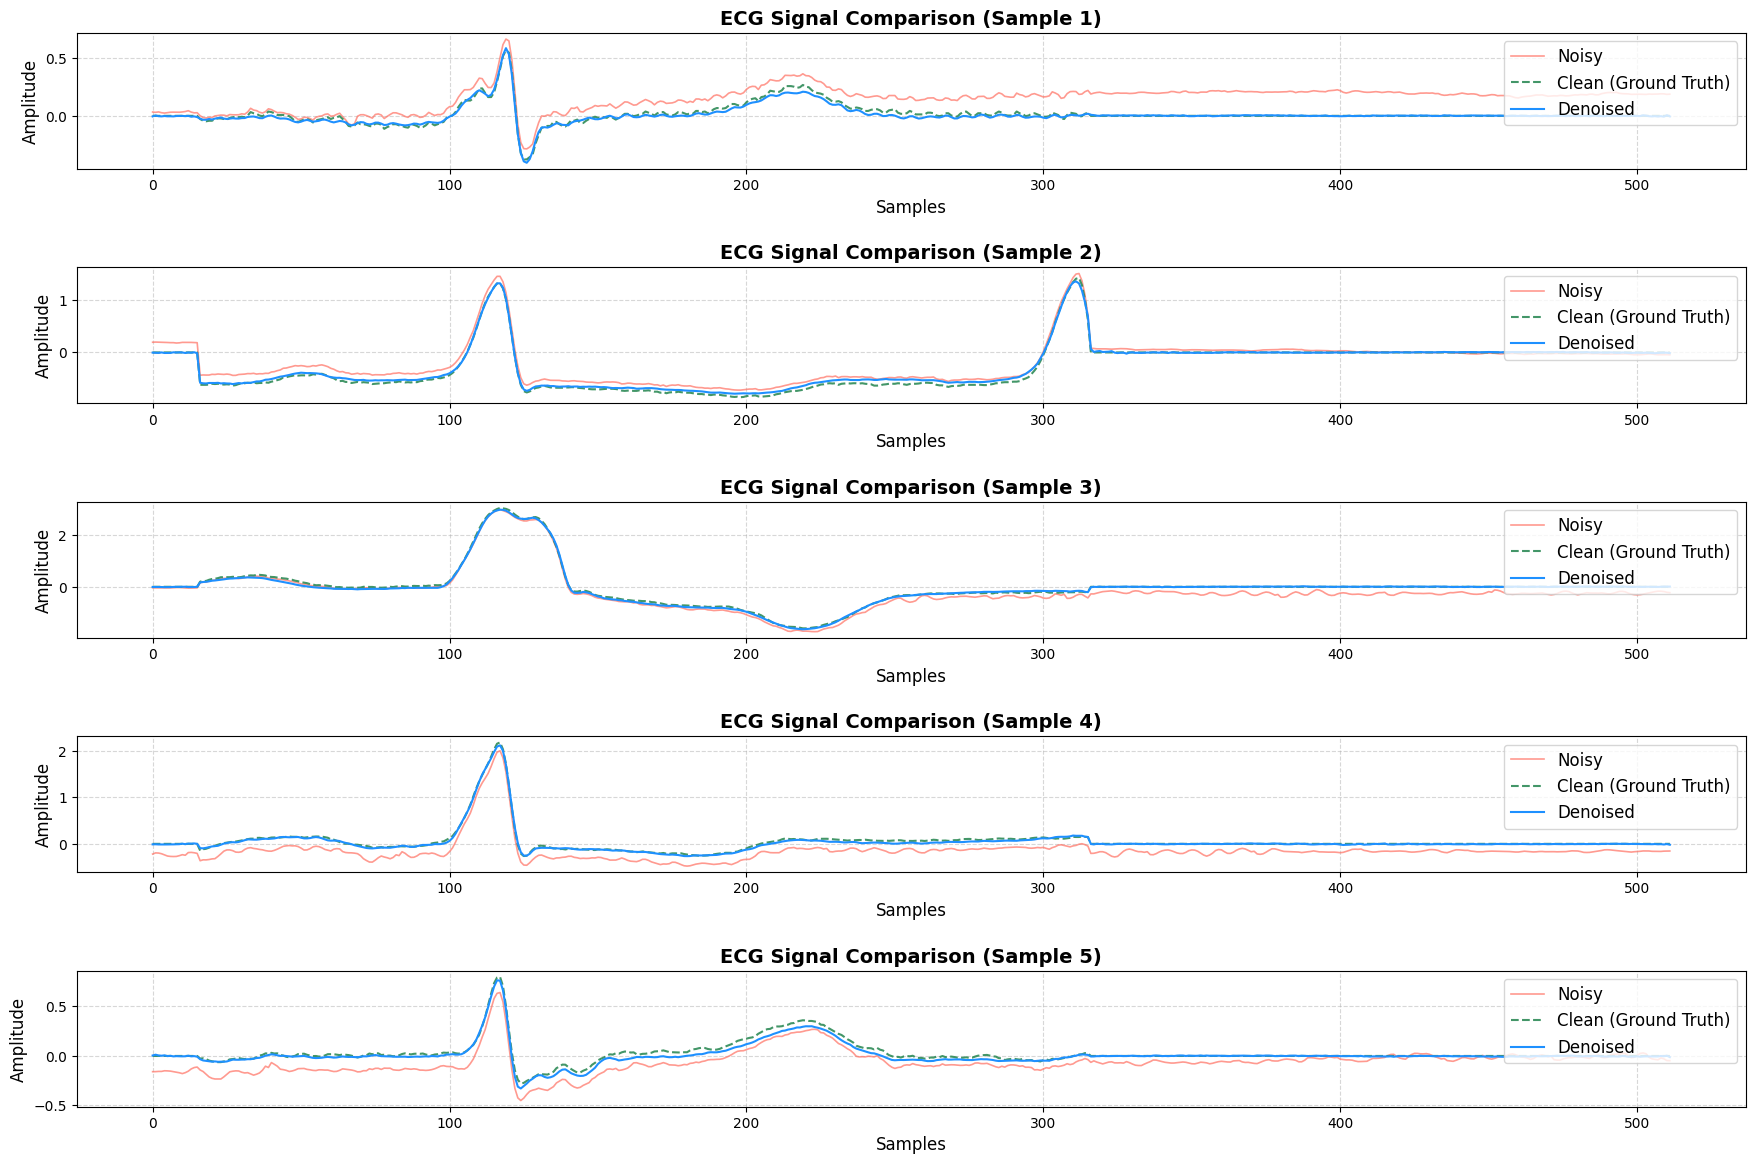

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ecg_comparison(X_test, y_test, y_pred, num_samples=5):
    """
    Noisy, Clean, and Denoised ECG 신호를 보기 좋게 시각화합니다.
    
    Parameters:
    X_test: Noisy 신호 (입력)
    y_test: Clean 신호 (Ground Truth)
    y_pred: Denoised 신호 (출력)
    num_samples: 시각화할 샘플 수 (기본값: 5)
    """
    plt.figure(figsize=(18, 12))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        
        # Noisy Signal
        plt.plot(X_test[i].squeeze(), color='#FF6F61', linewidth=1.2, alpha=0.7, label='Noisy')
        
        # Clean Signal (Ground Truth)
        plt.plot(y_test[i].squeeze(), color='#2E8B57', linestyle='--', linewidth=1.5, alpha=0.9, label='Clean (Ground Truth)')
        
        # Denoised Signal
        plt.plot(y_pred[i].squeeze(), color='#1E90FF', linestyle='-', linewidth=1.5, label='Denoised')
        
        # Plot Customization
        plt.title(f"ECG Signal Comparison (Sample {i + 1})", fontsize=14, fontweight='bold')
        plt.xlabel("Samples", fontsize=12)
        plt.ylabel("Amplitude", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='upper right', fontsize=12)
        
    plt.tight_layout(pad=2.0)
    plt.show()

# 시각화 실행
plot_ecg_comparison(X_test, y_test, y_pred, num_samples=5)


In [ ]:
# 원래 시각화 코드였는데 안쓸거임임
# import os
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt


# def ensure_directory(directory):
#     if not os.path.exists(directory):
#         os.makedirs(directory)


# def ecg_view_comparison(ecg_segments, ecg_blw_segments, ecg_dl_segments, model_name,
#                         noise_indices=None, signal_name=None, save_dir='view_comparison', num_segments=5):
#     ensure_directory(save_dir)  # Ensure the save directory exists

#     # Concatenate segments for plotting
#     ecg_concat = np.concatenate(ecg_segments[:num_segments])
#     ecg_blw_concat = np.concatenate(ecg_blw_segments[:num_segments])
#     ecg_dl_concat = np.concatenate(ecg_dl_segments[:num_segments])

#     # Plot comparison
#     fig, ax = plt.subplots(figsize=(24, 16))
#     ax.plot(ecg_concat, 'b-', label='Original ECG (Ground Truth)', lw=1.5)  # 검은색 선
#     ax.plot(ecg_dl_concat, 'r-', label=f'{model_name} Filtered ECG', lw=3)  # 빨간색 선
    
#     # Grid, labels, and legend
#     ax.grid(True, linestyle='--', linewidth=1.5, alpha=0.8)
#     ax.set_xlabel('Samples (N)', fontsize=42)
#     ax.set_ylabel('Amplitude (au)', fontsize=42)
#     ax.tick_params(axis='both', which='major', labelsize=28)
#     ax.set_title(f"Signal Comparison for {model_name}", fontsize=45, fontweight='bold')
#     ax.legend(loc='upper right', fontsize=25)
    
#     # # 축 범위 제한
#     # ax.set_xlim([0, len(ecg_concat) // 2])
#     # ax.set_ylim([-2, 2])

#     # Save the figure
#     filename = f"Comparison_{signal_name}_{model_name}_Segments_{num_segments}.png"
#     filepath = os.path.join(save_dir, filename)
#     plt.savefig(filepath, dpi=300, bbox_inches='tight')
#     plt.close(fig)  # Close figure to free memory
#     print(f"Saved: {filepath}")


# # Load results for each model
# dl_experiments = ['CNN_DAE','DRNN', 'FCN-DAE', 'DeepFilter', 'AttentionSkipDAE', 'Transformer_DAE', 'Transformer_COMBDAE']

# model_results = {}
# for model_name in dl_experiments:
#     if model_name == 'Transformer_COMBDAE':
#         file_path = f"0221_FIXED/test_results_{model_name}.pkl"
#     file_path = f"0221_FIXED/test_results_{model_name}.pkl"
#     with open(file_path, 'rb') as input_file:
#         model_results[model_name] = pickle.load(input_file)

# # Add FIR and IIR filter results
# with open('1220/test_results_FIR.pkl', 'rb') as input:
#     model_results["FIR_Filter"] = pickle.load(input)

# with open('1220/test_results_IIR.pkl', 'rb') as input:
#     model_results["IIR_Filter"] = pickle.load(input)

# # Example configuration for plotting
# signal_name = 'Example_Signal'
# segments_to_plot = 8
# signals_index = [1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040]  # Indices of segments to plot
# noise_indices = [i for i in signals_index]  # Example noise indices

# # Loop through each model and generate plots
# for model_name, (X_test, y_test, y_pred) in model_results.items():
#     # Prepare segments for plotting
#     ecgbl_signals2plot = [X_test[i] for i in signals_index]  # Noisy segments
#     ecg_signals2plot = [y_test[i] for i in signals_index]  # Original segments
#     dl_signals2plot = [y_pred[i] for i in signals_index]  # Model-filtered segments

#     # Generate comparison plot for the model
#     ecg_view_comparison(ecg_segments=ecg_signals2plot,
#                         ecg_blw_segments=ecgbl_signals2plot,
#                         ecg_dl_segments=dl_signals2plot,
#                         model_name=model_name,
#                         noise_indices=noise_indices,
#                         signal_name=signal_name,
#                         save_dir='fig15',
#                         num_segments=segments_to_plot)


In [ ]:
# 안쓰는게 나을듯듯
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# import os
# from vg_beat_detectors import FastNVG  # Import the FastNVG detector

# def plot_concatenated_r_peaks(y_test, y_pred, model_name, sampling_rate=360, save_dir="fig7", max_samples=8):
#     """
#     Concatenate samples and plot R-peak detection for ground truth and denoised signals.

#     :param y_test: Ground truth signals.
#     :param y_pred: Denoised signals.
#     :param model_name: Name of the model.
#     :param sampling_rate: Sampling rate of the signals.
#     :param save_dir: Directory to save the plots.
#     :param max_samples: Maximum number of samples to concatenate.
#     """
#     # Ensure save directory exists
#     os.makedirs(save_dir, exist_ok=True)
    
#     # Concatenate a limited number of samples
#     y_test_concat = np.concatenate([y.flatten() for y in y_test[1032:1032+max_samples]])
#     y_pred_concat = np.concatenate([y.flatten() for y in y_pred[1032:1032+max_samples]])
    
#     # Initialize the FastNVG detector
#     detector = FastNVG(sampling_frequency=sampling_rate)
#     gt_peaks = detector.find_peaks(y_test_concat)
#     denoised_peaks = detector.find_peaks(y_pred_concat)

#     # Plot the concatenated signals
#     plt.figure(figsize=(24, 16))

#     # Add red grid lines
#     y_min, y_max = min(y_test_concat.min(), y_pred_concat.min()), max(y_test_concat.max(), y_pred_concat.max())
#     signal_length = len(y_test_concat)
    
#     for x in np.arange(0, signal_length, sampling_rate * 0.2):  # Vertical bold lines every 0.2s
#         plt.axvline(x=x, color='red', linestyle='-', alpha=0.7, linewidth=0.8)
#     for x in np.arange(0, signal_length, sampling_rate * 0.04):  # Vertical thin lines every 0.04s
#         plt.axvline(x=x, color='red', linestyle='-', alpha=0.3, linewidth=0.5)
#     # for y in np.arange(y_min, y_max, 0.5):  # Horizontal bold lines every 0.5mV
#     #     plt.axhline(y=y, color='red', linestyle='-', alpha=0.7, linewidth=0.8)
#     for y in np.arange(y_min, y_max, 0.1):  # Horizontal thin lines every 0.1mV
#         plt.axhline(y=y, color='red', linestyle='-', alpha=0.3, linewidth=0.5)

#     # Plot Ground Truth signal
#     plt.plot(y_test_concat, label="Ground Truth Signal", color="blue", linewidth=2)
#     plt.scatter(gt_peaks, y_test_concat[gt_peaks], color="blue", s=100, label="R-Peaks (Ground Truth)", zorder=5)  # 크기 증가 및 색상 변경

#     # Plot Denoised signal
#     plt.plot(y_pred_concat, label="Denoised Signal", color="red", linewidth=2)
#     plt.scatter(denoised_peaks, y_pred_concat[denoised_peaks], color="red", s=100, label="R-Peaks (Denoised)", zorder=5)

#     # Draw dashed lines for R-peak differences and annotate Δ values
#     for gt, den in zip(gt_peaks, denoised_peaks):
#         plt.axvline(x=gt, color="blue", linestyle="--", alpha=0.5)
#         plt.axvline(x=den, color="red", linestyle="--", alpha=0.5)
#         delta_time = abs(gt - den) / sampling_rate
#         plt.text((gt + den) / 2, max(y_test_concat.max(), y_pred_concat.max()) * 0.8,
#                  f"Δ = {delta_time:.2f}s", ha="center", va="bottom", fontsize=10, color="purple")

#     # Add labels, legend, and grid
#     plt.title(f"Concatenated R-Peak Detection - {model_name}", fontsize=24, fontweight="bold")
#     plt.xlabel("Samples (N)", fontsize=20)
#     plt.ylabel("Amplitude (au)", fontsize=20)
#     plt.legend(fontsize=16)
#     plt.grid(True, linestyle='--', alpha=0.7)

#     # Set x-axis limits to start at 0 and end at the signal length
#     plt.xlim(0, signal_length)

#     # Save the plot
#     save_path = os.path.join(save_dir, f"{model_name}_R_Peaks_Comparison.png")
#     plt.savefig(save_path, dpi=300, bbox_inches='tight')
#     plt.close()
#     print(f"Saved concatenated R-peak plot for {model_name}: {save_path}")

# # Example usage
# for model_name, test_model in model_results.items():
#     y_test, y_pred = test_model[1], test_model[2]

#     y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], -1)
#     y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)
#     # metrics, debug_logs, debug_plots = calculate_rr_accuracy_with_mape(y_test, y_pred)

#     # print(f"Model: {model_name}\nMetrics: {metrics}\n")
#     plot_concatenated_r_peaks(y_test, y_pred, model_name)


Calculating metrics ...


+---------------------+---------------+-----------------+---------------+----------------+
|        Model        |      RMSE     |       PRD       |    COS_SIM    |      SNR       |
+---------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 0.121 (0.087) | 48.140 (22.302) | 0.832 (0.177) | 5.938 (6.146)  |
|      IIR Filter     | 0.123 (0.094) | 48.270 (23.235) | 0.828 (0.185) | 6.036 (6.521)  |
|         DRNN        | 0.077 (0.041) | 50.270 (36.779) | 0.891 (0.149) | 8.968 (4.662)  |
|      DeepFilter     | 0.065 (0.033) | 41.965 (31.314) | 0.917 (0.121) | 10.243 (4.531) |
|       CNN_DAE       | 0.091 (0.051) | 52.160 (29.385) | 0.873 (0.141) | 7.563 (3.564)  |
|       FCN_DAE       | 0.080 (0.045) | 46.195 (29.824) | 0.895 (0.139) | 8.693 (3.985)  |
|   AttentionSkipDAE  | 0.070 (0.046) | 37.824 (23.404) | 0.920 (0.124) | 10.295 (4.721) |
|   Transformer_DAE   | 0.057 (0.035) | 31.361 (20.647) | 0.940 

In [ ]:

# # 5-class 시각화 함수
# def plot_5class_samples(mitdb_with_labels, target_class, num_samples=5):
#     """
#     특정 5-class 그룹의 ECG 비트를 시각화합니다.
#     """
#     fig, axs = plt.subplots(num_samples, 1, figsize=(12, 2 * num_samples))
#     fig.suptitle(f"5-Class {target_class} - ECG Beat Samples", fontsize=16)
    
#     sample_count = 0
#     for pid in mitdb_with_labels.keys():
#         for beat, label in mitdb_with_labels[pid]:
#             if group_to_5class(label) == target_class:
#                 axs[sample_count].plot(beat, color='green')
#                 axs[sample_count].set_title(f"Patient {pid} - Sample {sample_count + 1}")
#                 axs[sample_count].set_xlabel("Sample Index")
#                 axs[sample_count].set_ylabel("Amplitude")
#                 sample_count += 1
#                 if sample_count >= num_samples:
#                     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#                     plt.show()
#                     return

# # 5-class 그룹 시각화
# for class_index in range(5):
#     print(f"Visualizing samples for 5-Class {class_index}...")
#     plot_5class_samples(mitdb_with_labels, class_index, num_samples=5)


In [ ]:
# import glob
# import numpy as np
# from scipy.signal import resample_poly
# import wfdb
# import math
# import _pickle as pickle

# def prepare_mitdb(mitpath='/home/dhc99/ecg_denoise/data/physionet.org/files/mitdb/1.0.0/'):
#     """
#     MIT-BIH Database 전처리 및 300 길이의 비트 생성.
#     """
#     # Desired sampling frequency
#     newFs = 360

#     # Preprocessing signals
#     patient_ids = pd.read_csv(mitpath + 'RECORDS', header=None).squeeze("columns").to_numpy()
    
#     # final list that will contain all signals and beats processed
#     MITDatabaseSignals = dict()

#     for pid in patient_ids:
#         signal, fields = wfdb.rdsamp(mitpath + str(pid))
#         ann = wfdb.rdann(mitpath + str(pid), 'atr')
#         annSamples = ann.sample

#         # Extract first channel and split into 300-length beats
#         auxSig = signal[:, 0]
#         beats = [auxSig[max(0, annSamples[i] - 99): min(len(auxSig), annSamples[i] + 201)] for i in range(1, len(annSamples) - 1)]

#         # Padding and resampling each beat to 360 Hz with length 300
#         processed_beats = []
#         for b in beats:
#             if len(b) > 300:  # Skip too long beats
#                 continue
#             b_padded = np.zeros(300)
#             b_padded[:len(b)] = b - (b[0] + b[-1]) / 2  # Centering
#             processed_beats.append(b_padded)

#         # Store processed beats for the patient
#         MITDatabaseSignals[pid] = processed_beats

#     # Save MIT Database as pickle
#     with open('data/MITDatabase.pkl', 'wb') as output:
#         pickle.dump(MITDatabaseSignals, output)
#     print('=========================================================')
#     print('MIT-BIH database saved as pickle file')

# prepare_mitdb()

[INFO] Loaded MITDatabase with 48 signals
112551


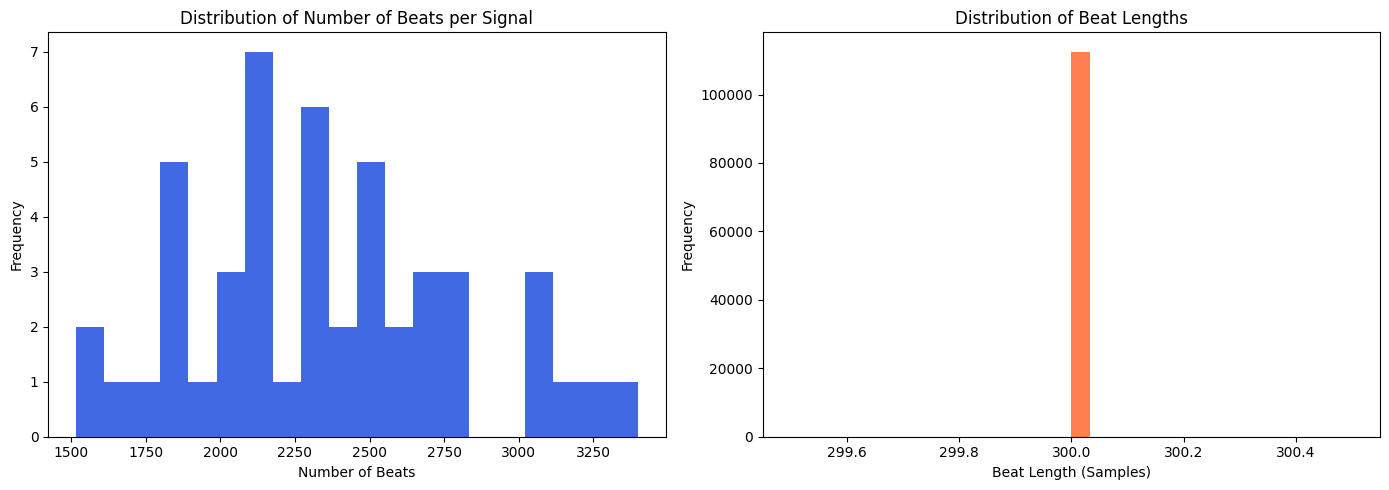

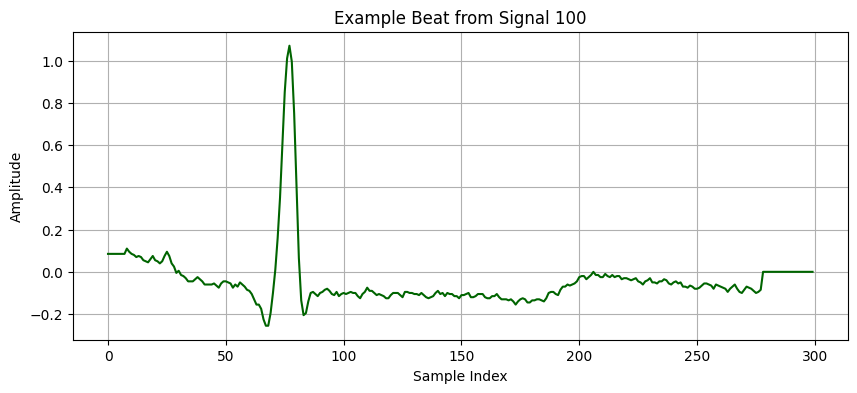

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load MIT Database
with open('data/MITDatabase.pkl', 'rb') as input:
    mitdb = pickle.load(input)

# Print basic info
print(f"[INFO] Loaded MITDatabase with {len(mitdb.keys())} signals")

# Visualize the shape of beats for each signal
signal_lengths = [len(beats) for beats in mitdb.values()]
beat_lengths = [len(beat) for beats in mitdb.values() for beat in beats]
print(len(beat_lengths))
# Plot the distribution of signal and beat lengths
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.hist(signal_lengths, bins=20, color='royalblue')
plt.title('Distribution of Number of Beats per Signal')
plt.xlabel('Number of Beats')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(beat_lengths, bins=30, color='coral')
plt.title('Distribution of Beat Lengths')
plt.xlabel('Beat Length (Samples)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Visualize one sample beat from the first signal in mitdb
first_signal = list(mitdb.keys())[0]
sample_beat = mitdb[first_signal][0]

plt.figure(figsize=(10, 4))
plt.plot(sample_beat, color='darkgreen')
plt.title(f'Example Beat from Signal {first_signal}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [ ]:
# import numpy as np
# from scipy.fft import fft
# from scipy.signal import resample_poly
# import wfdb
# import math
# import _pickle as pickle

# def make_fourier(inputs, n, fs):
#     """
#     주파수 도메인 정보 추출 및 time-domain과 같은 shape으로 만듦.
#     """
#     T = n / fs
#     k = np.arange(n)
#     freq = k / T
#     freq = freq[range(int(n / 2))]

#     signal_list = []
#     for i in range(inputs.shape[0]):
#         y = inputs[i, :]
#         Y = fft(y) / n  # FFT 수행 후 정규화
#         Y = np.abs(Y[range(int(n / 2))])
#         Y_full = np.hstack([Y, Y])  # Duplicate to match time-domain size (512)
#         signal_list.append(Y_full)

#     return np.asarray(signal_list)

# def Data_Preparation_with_Fourier_mitdb(samples=512, fs=360):
#     """
#     MITDB 데이터셋을 준비하고 Fourier 변환된 주파수 도메인 정보와 함께 반환합니다.
#     """
#     print('Preparing the MITDB dataset...')

#     # Set random seed for reproducibility
#     seed = 1234
#     np.random.seed(seed=seed)

#     # Load MIT Database
#     with open('data/MITDatabase.pkl', 'rb') as input:
#         mitdb = pickle.load(input)
#     print(f"[INFO] Loaded MITDatabase with {len(mitdb.keys())} signals")

#     # Load combined noise
#     with open('data/CombinedNoise.pkl', 'rb') as input:
#         combined_noise = pickle.load(input)
#     print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

#     beats = []
#     fourier_x = []
#     fourier_y = []
#     valid_indices = []
#     sn = []

#     skip_beats = 0

#     print(f"[INFO] Processing MITDatabase, {len(mitdb.keys())} signals to process.")
#     for signal_name in mitdb.keys():
#         for b_idx, b in enumerate(mitdb[signal_name]):
#             b_np = np.zeros(samples)
#             b_sq = np.array(b)

#             init_padding = 16
#             if b_sq.shape[0] > (samples - init_padding):
#                 skip_beats += 1
#                 continue

#             b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

#             # Fourier 변환 적용 (주파수 도메인 정보, time-domain과 동일한 shape으로)
#             fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)
            
#             beats.append(b_np)
#             fourier_y.append(fourier_transformed_y[0])
#             valid_indices.append(len(beats) - 1)

#     #####################################
#     # Data split (80% train, 20% test)
#     #####################################
#     total_beats = len(beats)
#     split_idx = int(total_beats * 0.8)

#     beats_train = beats[:split_idx]
#     beats_test = beats[split_idx:]

#     fourier_train_y = fourier_y[:split_idx]
#     fourier_test_y = fourier_y[split_idx:]

#     #####################################
#     # Adding noise to train and test sets
#     #####################################
#     print(f"[INFO] Adding noise to train and test sets")
#     sn_train = []
#     sn_test = []
#     fourier_train_x = []
#     fourier_test_x = []

#     # Random scaling factor for train and test
#     rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
#     rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
#     np.save('rnd_test_mitdb.npy', rnd_test)

#     def add_noise(beats, rnd, combined_noise, samples):
#         sn = []
#         fourier_x = []
#         noise_index = 0
#         for beat_idx, beat in enumerate(beats):
#             selected_channel = beat_idx % 2
#             noise_combination_idx = 0
#             noise = combined_noise[selected_channel][:, noise_combination_idx]
#             noise_segment = noise[noise_index:noise_index + samples]
#             beat_max_value = np.max(beat) - np.min(beat)
#             noise_max_value = np.max(noise_segment) - np.min(noise_segment)
#             Ase = 1 if noise_max_value == 0 else noise_max_value / beat_max_value
#             alpha = rnd[beat_idx] / Ase
#             signal_noise = beat + alpha * noise_segment
#             sn.append(signal_noise)
#             fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
#             fourier_x.append(fourier_transformed_x[0])
#             noise_index += samples
#             if noise_index > (len(noise) - samples):
#                 noise_index = 0
#         return sn, fourier_x

#     # Add noise to train and test sets
#     sn_train, fourier_train_x = add_noise(beats_train, rnd_train, combined_noise, samples)
#     sn_test, fourier_test_x = add_noise(beats_test, rnd_test, combined_noise, samples)

#     #####################################
#     # Convert to NumPy arrays and reshape
#     #####################################
#     X_train = np.expand_dims(np.array(sn_train), axis=2)
#     y_train = np.expand_dims(np.array(beats_train), axis=2)
#     X_test = np.expand_dims(np.array(sn_test), axis=2)
#     y_test = np.expand_dims(np.array(beats_test), axis=2)
#     F_train_x = np.expand_dims(np.array(fourier_train_x), axis=2)
#     F_train_y = np.expand_dims(np.array(fourier_train_y), axis=2)
#     F_test_x = np.expand_dims(np.array(fourier_test_x), axis=2)
#     F_test_y = np.expand_dims(np.array(fourier_test_y), axis=2)

#     Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y]

#     print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
#     print(f"[INFO] Fourier shapes -> F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}, F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")
#     print('Dataset ready to use.')

#     return Dataset
# def Data_Preparation_with_mitdb(samples=512, fs=360):
#     """
#     MITDB 데이터셋을 준비하고 Fourier 변환된 주파수 도메인 정보와 함께 반환합니다.
#     """
#     print('Preparing the MITDB dataset...')

#     # Set random seed for reproducibility
#     seed = 1234
#     np.random.seed(seed=seed)

#     # Load MIT Database
#     with open('data/MITDatabase.pkl', 'rb') as input:
#         mitdb = pickle.load(input)
#     print(f"[INFO] Loaded MITDatabase with {len(mitdb.keys())} signals")

#     # Load combined noise
#     with open('data/CombinedNoise.pkl', 'rb') as input:
#         combined_noise = pickle.load(input)
#     print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

#     beats = []
#     fourier_x = []
#     fourier_y = []
#     valid_indices = []
#     sn = []

#     skip_beats = 0

#     print(f"[INFO] Processing MITDatabase, {len(mitdb.keys())} signals to process.")
#     for signal_name in mitdb.keys():
#         for b_idx, b in enumerate(mitdb[signal_name]):
#             b_np = np.zeros(samples)
#             b_sq = np.array(b)

#             init_padding = 16
#             if b_sq.shape[0] > (samples - init_padding):
#                 skip_beats += 1
#                 continue

#             b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

#             # Fourier 변환 적용 (주파수 도메인 정보, time-domain과 동일한 shape으로)
#             fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)
            
#             beats.append(b_np)
#             fourier_y.append(fourier_transformed_y[0])
#             valid_indices.append(len(beats) - 1)

#     #####################################
#     # Data split (80% train, 20% test)
#     #####################################
#     total_beats = len(beats)
#     split_idx = int(total_beats * 0.8)

#     beats_train = beats[:split_idx]
#     beats_test = beats[split_idx:]

#     fourier_train_y = fourier_y[:split_idx]
#     fourier_test_y = fourier_y[split_idx:]

#     #####################################
#     # Adding noise to train and test sets
#     #####################################
#     print(f"[INFO] Adding noise to train and test sets")
#     sn_train = []
#     sn_test = []
#     fourier_train_x = []
#     fourier_test_x = []

#     # Random scaling factor for train and test
#     rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
#     rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
#     np.save('rnd_test_mitdb.npy', rnd_test)

#     def add_noise(beats, rnd, combined_noise, samples):
#         sn = []
#         fourier_x = []
#         noise_index = 0
#         for beat_idx, beat in enumerate(beats):
#             selected_channel = beat_idx % 2
#             noise_combination_idx = 0
#             noise = combined_noise[selected_channel][:, noise_combination_idx]
#             noise_segment = noise[noise_index:noise_index + samples]
#             beat_max_value = np.max(beat) - np.min(beat)
#             noise_max_value = np.max(noise_segment) - np.min(noise_segment)
#             Ase = 1 if noise_max_value == 0 else noise_max_value / beat_max_value
#             alpha = rnd[beat_idx] / Ase
#             signal_noise = beat + alpha * noise_segment
#             sn.append(signal_noise)
#             fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
#             fourier_x.append(fourier_transformed_x[0])
#             noise_index += samples
#             if noise_index > (len(noise) - samples):
#                 noise_index = 0
#         return sn, fourier_x

#     # Add noise to train and test sets
#     sn_train, fourier_train_x = add_noise(beats_train, rnd_train, combined_noise, samples)
#     sn_test, fourier_test_x = add_noise(beats_test, rnd_test, combined_noise, samples)

#     #####################################
#     # Convert to NumPy arrays and reshape
#     #####################################
#     X_train = np.expand_dims(np.array(sn_train), axis=2)
#     y_train = np.expand_dims(np.array(beats_train), axis=2)
#     X_test = np.expand_dims(np.array(sn_test), axis=2)
#     y_test = np.expand_dims(np.array(beats_test), axis=2)


#     Dataset = [X_train, y_train, X_test, y_test]

#     print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
#     print('Dataset ready to use.')

#     return Dataset


In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
# Load rnd_test (noise levels)
rnd_test = np.load("rnd_test.npy")
# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals
# Ensure directory for saving images exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
def plot_model_differences_individual(model_results, vis_indices, noise_range, save_dir):
    """
    Plot differences for each model in individual plots.
    """
    for model_name, (X_test, y_test, y_pred) in model_results.items():
        differences = [y_test[idx].flatten() - y_pred[idx].flatten() for idx in vis_indices]
        concatenated_diff = np.concatenate(differences)

        plt.figure(figsize=(14, 6))
        plt.plot(concatenated_diff, label=f'{model_name} Difference', color='blue', linewidth=1.5)

        plt.title(f"Difference Signal: {model_name}\nNoise Range: {noise_range}", fontsize=20, fontweight='bold')
        plt.xlabel("Sample Index", fontsize=14)
        plt.ylabel("Difference Amplitude (a.u.)", fontsize=14)
        plt.legend(loc="upper right", fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.tight_layout()

        # Save individual plot
        save_path = os.path.join(save_dir, f"{model_name}_Noise_{noise_range.replace('<', '_')}.png")
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"Saved individual plot for {model_name}: {save_path}")

# Noise range 처리 및 저장 경로 설정
save_dir_individual = "difference_plots_individual"
ensure_directory(save_dir_individual)

for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

    if len(noise_indices) == 0:
        print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
        continue

    vis_indices = noise_indices[:7]  # 최대 7개 샘플 선택
    noise_range_str = f"{noise_start} < noise < {noise_end}"

    plot_model_differences_individual(
        model_results, vis_indices, noise_range_str, save_dir_individual
    )


Saved individual plot for DRNN: difference_plots_individual/DRNN_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for FCN-DAE: difference_plots_individual/FCN-DAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Multibranch LANLD: difference_plots_individual/Multibranch LANLD_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for AttentionSkipDAE: difference_plots_individual/AttentionSkipDAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Transformer_DAE: difference_plots_individual/Transformer_DAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Transformer_COMBDAE: difference_plots_individual/Transformer_COMBDAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for FIR_Filter: difference_plots_individual/FIR_Filter_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for IIR_Filter: difference_plots_individual/IIR_Filter_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for DRNN: difference_plots_individual/DRNN_Noise_0.6 _ noise _ 1.0.png
Saved individual plot for FCN-D

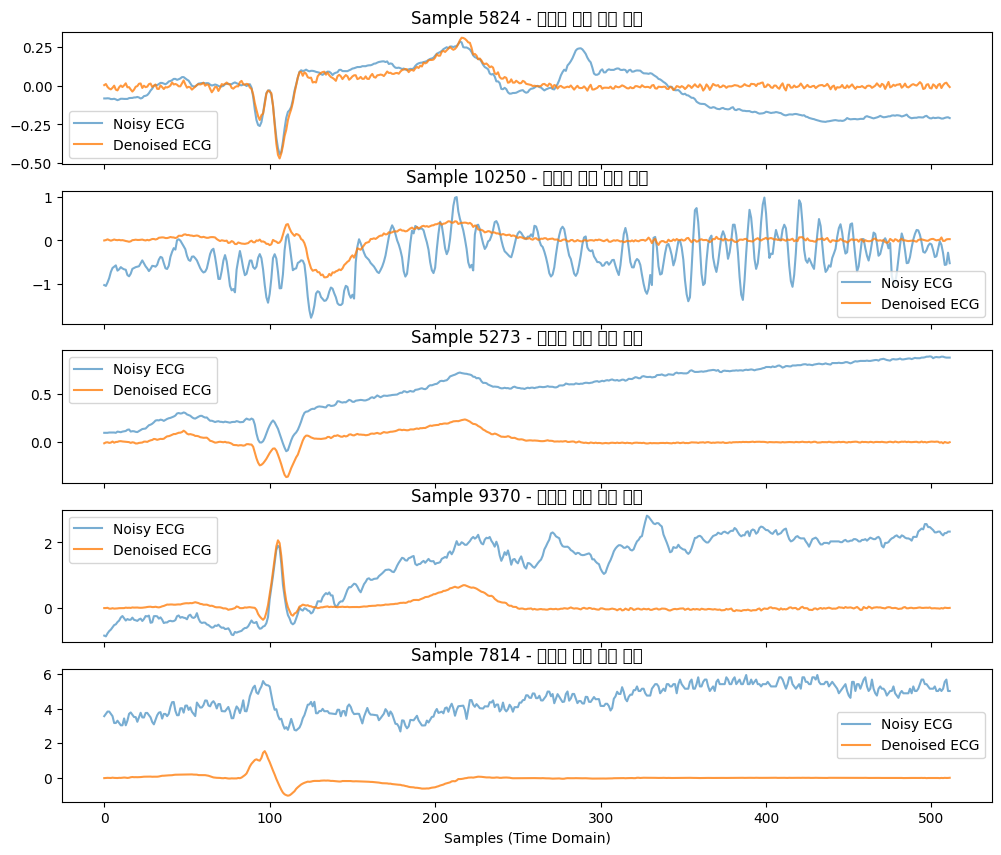

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_absolute_error

# === SNR별 폴더 및 모델 정의 === #
snr_folders = ["SNR_0DB", "SNR_6DB", "SNR_12DB"]
dl_model = "Transformer_COMBDAE"  # 사용할 모델

# === 평가 지표 계산 함수 === #
def SSD(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

def PRD(y_true, y_pred):
    return 100 * np.sqrt(np.sum((y_true - y_pred) ** 2) / np.sum(y_true ** 2))

def Cosine_Similarity(y_true, y_pred):
    return 1 - cosine(y_true.flatten(), y_pred.flatten())

# === QTDataset에서 'sel123' 찾기 === #
with open('data/QTDatabase.pkl', 'rb') as input:
    qtdb = pickle.load(input)

sel123_data = qtdb["sel123"]  # 'sel123' 데이터 가져오기
sel123_data = np.array(sel123_data)  # (샘플 개수, 512)

# === 시각화 설정 === #
fig, axes = plt.subplots(len(snr_folders), 1, figsize=(10, 15))

for i, snr_folder in enumerate(snr_folders):
    # === 모델 테스트 데이터 로드 === #
    with open(f"{snr_folder}/test_results_{dl_model}.pkl", "rb") as f:
        X_test, y_test, y_pred = pickle.load(f)

    # 'sel123' 데이터에 해당하는 샘플 찾기
    sel123_indices = [idx for idx in range(len(y_test)) if np.any(np.isin(y_test[idx], sel123_data))]

    # 여러 샘플을 연결하여 긴 신호 생성
    long_X_test = np.concatenate([X_test[j].squeeze() for j in sel123_indices[:10]], axis=0)
    long_y_test = np.concatenate([y_test[j].squeeze() for j in sel123_indices[:10]], axis=0)
    long_y_pred = np.concatenate([y_pred[j].squeeze() for j in sel123_indices[:10]], axis=0)

    # === Reconstruction Metrics 계산 === #
    ssd_value = SSD(long_y_test, long_y_pred)
    mad_value = mean_absolute_error(long_y_test, long_y_pred)
    prd_value = PRD(long_y_test, long_y_pred)
    cos_sim_value = Cosine_Similarity(long_y_test, long_y_pred)

    # === 그래프 그리기 === #
    ax = axes[i]
    ax.plot(long_y_test, label="Original", color="red", linewidth=1)
    ax.plot(long_X_test, label="Noisy", color="blue", linewidth=1, alpha=0.7)
    ax.plot(long_y_pred, label="Reconstruction", color="green", linewidth=1)

    ax.set_xlabel("Samples")
    ax.set_ylabel("Amplitude")
    ax.set_title(f"{snr_folder.replace('_', ' ')} - Noise Condition (sel123)")
    ax.legend()

    # Reconstruction Metrics 추가
    ax.text(0.75, 0.8, f"SSD: {ssd_value:.3f}\nMAD: {mad_value:.3f}\nPRD: {prd_value:.3f}\nCosine Sim: {cos_sim_value:.3f}", 
            transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()


밑의 코드로 latex로 바로 정리 가능능

In [ ]:
# Generate LaTeX tables for each metric
import os
import pickle
import numpy as np

# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving tables
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to calculate metrics
def calculate_metrics(y_original, y_filtered):
    """
    Calculate evaluation metrics for the filtered signal compared to the original signal.

    Parameters:
        y_original (ndarray): Original signal.
        y_filtered (ndarray): Filtered signal.

    Returns:
        dict: Dictionary containing SSD, MAD, PRD, COS_SIM, and SNR metrics.
    """
    # Flatten the signals to ensure 1D for metric calculations
    y_original = y_original.flatten()
    y_filtered = y_filtered.flatten()
    noise = y_original - y_filtered

    # SSD
    ssd = np.sum((y_original - y_filtered) ** 2)

    # MAD (using deviation from mean)
    # mu_filtered = np.mean(y_filtered)np.max(np.abs(y - y_pred), axis=1)
    mad = np.max(np.abs(y_original - y_filtered))

    # PRD
    prd = np.sqrt(np.sum((y_original - y_filtered) ** 2) / np.sum(y_original ** 2)) * 100

    # Cosine Similarity
    cosine_sim = np.dot(y_original, y_filtered) / (
        np.sqrt(np.sum(y_original ** 2)) * np.sqrt(np.sum(y_filtered ** 2))
    )

    # SNR (Signal-to-Noise Ratio)
    signal_power = np.sum(y_original ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)

    return {"SSD": ssd, "MAD": mad, "PRD": prd, "COS_SIM": cosine_sim, "SNR": snr}


# Load results for each model
dl_experiments = ['DRNN', 'FCN-DAE', 'DeepFilter', 'AttentionSkipDAE', 'Transformer_DAE']
model_results = {}

# Load FIR and IIR results
with open('1220/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR-Filter"] = pickle.load(input)

with open('1220/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR-Filter"] = pickle.load(input)
    
for model_name in dl_experiments:
    file_path = f"0220/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)
with open('0220/test_results_Transformer_COMBDAE.pkl', 'rb') as input:
    model_results["Transformer-COMBDAE"] = pickle.load(input)


# Load noise levels
rnd_test = np.load("rnd_test.npy")

# Initialize result storage
final_metrics = {metric: {model: [] for model in model_results.keys()} for metric in ["SSD", "MAD", "PRD", "COS_SIM", "SNR"]}

# Process each model
for model_name, (X_test, y_test, y_pred) in model_results.items():
    print(f"Processing results for model: {model_name}")
    
    # Loop through each noise level range
    for i in range(len(segm) - 1):
        noise_start, noise_end = segm[i], segm[i + 1]
        noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

        if len(noise_indices) == 0:
            print(f"No data for noise range {noise_start} to {noise_end} for {model_name}. Skipping...")
            for metric in final_metrics.keys():
                final_metrics[metric][model_name].append((0, 0))  # Append dummy values
            continue

        # Metrics storage
        metrics_range = {"SSD": [], "MAD": [], "PRD": [], "COS_SIM": [], "SNR": []}

        # Calculate metrics for all samples in the range
        for idx in noise_indices:
            metrics = calculate_metrics(y_test[idx], y_pred[idx])
            for key, value in metrics.items():
                metrics_range[key].append(value)

        # Summarize metrics (mean and std) and store
        for key in metrics_range.keys():
            final_metrics[key][model_name].append((np.mean(metrics_range[key]), np.std(metrics_range[key])))


output_dir = "results_tables_final2"
ensure_directory(output_dir)

for metric in final_metrics.keys():
    table_content = f"\\begin{{table*}}[h!]\n"
    table_content += "    \\hspace*{-2cm} % 테이블을 더 왼쪽으로 이동\n"
    table_content += f"    \\caption{{{metric} Results for All Models Across Noise Ranges}}\n"
    table_content += "    \\small\n"
    table_content += "    \\setlength{\\tabcolsep}{7pt} % 열 간격 조정\n"
    table_content += "    \\renewcommand{\\arraystretch}{1.2} % 행 높이 조정\n"
    table_content += "    \\resizebox{\\textwidth}{!}{ % 테이블 폭을 페이지 전체에 맞춤\n"
    table_content += "    \\begin{tabular}{lcccc} % 첫 열 왼쪽 정렬, 나머지 중앙 정렬\n"
    table_content += "        \\toprule\n"
    table_content += "        \\textbf{Model} & \\textbf{0.2-0.6} & \\textbf{0.6-1.0} & \\textbf{1.0-1.5} & \\textbf{1.5-2.0} \\\\\n"
    table_content += "        \\midrule\n"

    for model_name, results in final_metrics[metric].items():
        row = f"        {model_name}"
        for mean, std in results:
            if metric == "COS_SIM" or metric == "MAD":
                row += f" & {mean:.3f} $\\pm$ {std:.3f}"  # CosSim 소수점 셋째 자리
            else:
                row += f" & {mean:.2f} $\\pm$ {std:.2f}"  # 다른 Metric은 소수점 둘째 자리
        row += " \\\\\n"
        table_content += row

    table_content += "        \\bottomrule\n"
    table_content += "    \\end{tabular}\n"
    table_content += "    }\n"
    table_content += "\\end{table*}\n"
    
    # Save LaTeX table
    output_file = os.path.join(output_dir, f"{metric}_results.tex")
    with open(output_file, "w") as f:
        f.write(table_content)
    print(f"Saved {metric} table to {output_file}")


Processing results for model: FIR-Filter
Processing results for model: IIR-Filter
Processing results for model: DRNN
Processing results for model: FCN-DAE
Processing results for model: DeepFilter
Processing results for model: AttentionSkipDAE
Processing results for model: Transformer_DAE
Processing results for model: Transformer-COMBDAE
Saved SSD table to results_tables_final2/SSD_results.tex
Saved MAD table to results_tables_final2/MAD_results.tex
Saved PRD table to results_tables_final2/PRD_results.tex
Saved COS_SIM table to results_tables_final2/COS_SIM_results.tex
Saved SNR table to results_tables_final2/SNR_results.tex


In [ ]:
# import numpy as np
# snr_info = []  # 각 chunk별 SNR 정보를 저장할 리스트
# def apply_random_snr(noise, desired_snr_db):
#     """
#     Adjusts the SNR of a given noise signal to the desired SNR in dB.
    
#     Parameters:
#     noise (np.ndarray): The noise signal to be adjusted.
#     desired_snr_db (float): The target SNR in dB (-6, 0, 6, 12, 18).
    
#     Returns:
#     np.ndarray: Noise signal with the adjusted SNR.
#     """
#     signal_power = np.mean(noise ** 2)
#     desired_snr = 10 ** (desired_snr_db / 10)
#     noise_power = signal_power / desired_snr
#     adjusted_noise = noise * np.sqrt(noise_power / np.mean(noise ** 2))
#     return adjusted_noise
# # Random SNR values (-6, 0, 6, 12, 18dB)
# def prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
#     """
#     Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
#     with Baseline Wander (BW) noise always included. Electrode Motion (EM) and 
#     Muscle Artifact (MA) noises are added randomly.
#     Expands the final noise matrix to shape (2, 650000, 1).
    
#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     """
#     # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
#     # Initialize storage for combined noise across channels
#     combined_noise = []
#     snr_values = [-6, 0, 6, 12, 18, 24]
#     seed = 1234
#     np.random.seed(seed)

#     for channel in range(2):
#         bw_noise = bw_signals[:, channel]
#         em_noise = em_signals[:, channel]
#         ma_noise = ma_signals[:, channel]
#         combined_channel_noise = np.zeros(bw_noise.shape)
#         chunk_size = 10000
#         num_chunks = len(bw_noise) // chunk_size

#         for chunk_idx in range(num_chunks):
#             start_idx = chunk_idx * chunk_size
#             end_idx = start_idx + chunk_size
            
#             # Random SNR selection for each noise type
#             bw_snr = np.random.choice(snr_values)
#             em_snr = np.random.choice(snr_values)
#             ma_snr = np.random.choice(snr_values)
            
#             # Apply random SNR to each noise type
#             bw_chunk = apply_random_snr(bw_noise[start_idx:end_idx], bw_snr)
#             em_chunk = apply_random_snr(em_noise[start_idx:end_idx], em_snr)
#             ma_chunk = apply_random_snr(ma_noise[start_idx:end_idx], ma_snr)

#             # Composite noise
#             chunk_noise = bw_chunk + em_chunk + ma_chunk
#             combined_channel_noise[start_idx:end_idx] += chunk_noise
#                 # SNR 정보 저장
#             snr_info.append({
#                 "chunk_idx": chunk_idx,
#                 "start_idx": start_idx,
#                 "end_idx": end_idx,
#                 "bw_snr": bw_snr,
#                 "em_snr": em_snr,
#                 "ma_snr": ma_snr
#             })
#         combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)
#         print(combined_channel_noise.shape)
#         combined_noise.append(combined_channel_noise)
#     # Stack the noises for all channels to shape (2, 650000, 1)
#     combined_noise = np.stack(combined_noise, axis=0)

#     # Save combined noise data as a pickle file
#     with open('data/CombinedNoise.pkl', 'wb') as output:
#         pickle.dump(combined_noise, output)
    
#     print('=========================================================')
#     print(f'Final combined noise shape: {combined_noise.shape}')

    
# prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')

(650000, 1)
(650000, 1)
Final combined noise shape: (2, 650000, 1)


In [ ]:
# # 이대로하면 노이즈가 너무 작음음

# import numpy as np
# import pickle
# import wfdb

# snr_info = []  # 각 chunk별 SNR 정보를 저장할 리스트

# def apply_random_snr(noise, desired_snr_db):
#     """
#     Adjusts the SNR of a given noise signal to the desired SNR in dB.

#     Parameters:
#     noise (np.ndarray): The noise signal to be adjusted.
#     desired_snr_db (float): The target SNR in dB.

#     Returns:
#     np.ndarray: Noise signal with the adjusted SNR.
#     """
#     signal_power = np.mean(noise ** 2)
#     desired_snr = 10 ** (desired_snr_db / 10)
#     noise_power = signal_power / desired_snr
#     adjusted_noise = noise * np.sqrt(noise_power / np.mean(noise ** 2))
#     return adjusted_noise

# def prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
#     """
#     Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
#     with Baseline Wander (BW) noise always included. Electrode Motion (EM) and 
#     Muscle Artifact (MA) noises are added randomly.
#     Expands the final noise matrix to shape (2, 650000, 1).

#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     """
#     # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

#     # Initialize storage for combined noise across channels
#     combined_noise = []
#     seed = 1234
#     np.random.seed(seed)

#     for channel in range(2):
#         bw_noise = bw_signals[:, channel]
#         em_noise = em_signals[:, channel]
#         ma_noise = ma_signals[:, channel]
#         combined_channel_noise = np.zeros(bw_noise.shape)
#         chunk_size = 10000
#         num_chunks = len(bw_noise) // chunk_size

#         for chunk_idx in range(num_chunks):
#             start_idx = chunk_idx * chunk_size
#             end_idx = start_idx + chunk_size

#             # Assign specific SNR ranges to each noise type
#             bw_snr = np.random.uniform(0, 5)  # BW: 0-5 dB
#             ma_snr = np.random.uniform(5, 10)  # MA: 5-10 dB
#             em_snr = np.random.uniform(10, 15)  # EM: 10-15 dB

#             # Apply fixed SNR ranges
#             bw_chunk = apply_random_snr(bw_noise[start_idx:end_idx], bw_snr)
#             ma_chunk = apply_random_snr(ma_noise[start_idx:end_idx], ma_snr)
#             em_chunk = apply_random_snr(em_noise[start_idx:end_idx], em_snr)

#             # Composite noise
#             chunk_noise = bw_chunk + ma_chunk + em_chunk
#             combined_channel_noise[start_idx:end_idx] += chunk_noise

#             # SNR 정보 저장
#             snr_info.append({
#                 "chunk_idx": chunk_idx,
#                 "start_idx": start_idx,
#                 "end_idx": end_idx,
#                 "bw_snr": bw_snr,
#                 "ma_snr": ma_snr,
#                 "em_snr": em_snr
#             })

#         combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)
#         combined_noise.append(combined_channel_noise)

#     # Stack the noises for all channels to shape (2, 650000, 1)
#     combined_noise = np.stack(combined_noise, axis=0)

#     # Save combined noise data as a pickle file
#     with open('data/CombinedNoise.pkl', 'wb') as output:
#         pickle.dump(combined_noise, output)

#     print('=========================================================')
#     print(f'Final combined noise shape: {combined_noise.shape}')

# prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')


In [ ]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('1220/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('1220/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('1220/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('1220/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('1220/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0128/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+------------------+---------------+-----------------+---------------+----------------+
|        Model        |       SSD        |      MAD      |       PRD       |    COS_SIM    |      SNR       |
+---------------------+------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 87.842 (149.923) | 0.997 (0.816) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 78.701 (135.916) | 0.958 (0.817) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        |  6.821 (10.051)  | 0.497 (0.330) | 55.969 (33.130) | 0.874 (0.128) | 7.297 (3.390)  |
|       FCN-DAE       |  9.175 (13.267)  | 0.547 (0.382) | 72.853 (46.337) | 0.803 (0.194) | 5.742 (3.735)  |
|      DeepFilter     |  6.680 (9.011)   | 0.440 (0.327) | 60.646 (38.037) | 0.860 (0.138) | 6.999 (3.610)  |
|   AttentionSkipDAE  |  5.777 (9.137)   | 0.388 (0.280) | 48.260 (25.741) | 0.898 (0.106) | 8

bw

In [ ]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
with open('0209_bw/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0209_bw/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0209_bw/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0209_bw/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0209_bw/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0209_bw/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('0209_bw/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('0209_bw/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+-----------------+---------------+-----------------+---------------+----------------+
|        Model        |       SSD       |      MAD      |       PRD       |    COS_SIM    |      SNR       |
+---------------------+-----------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 48.460 (93.887) | 0.683 (0.594) | 65.667 (22.197) | 0.696 (0.216) | 1.220 (5.971)  |
|      IIR Filter     | 35.764 (71.235) | 0.595 (0.538) | 60.675 (23.110) | 0.740 (0.205) | 2.749 (6.134)  |
|         DRNN        |  5.524 (8.681)  | 0.421 (0.282) | 47.749 (25.819) | 0.899 (0.097) | 8.477 (3.701)  |
|       FCN-DAE       |  6.183 (9.236)  | 0.454 (0.297) | 57.605 (35.799) | 0.863 (0.147) | 7.076 (3.587)  |
|      DeepFilter     |  4.142 (6.180)  | 0.332 (0.253) | 42.805 (27.866) | 0.919 (0.088) | 9.473 (3.838)  |
|   AttentionSkipDAE  |  3.330 (5.282)  | 0.311 (0.229) | 35.592 (17.471) | 0.941 (0.059) | 10.441 (3.

In [ ]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
with open('0209_all/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0209_all/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0209_all/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0209_all/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0209_all/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0209_all/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('0209_all/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('0209_all/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+-------------------+---------------+-----------------+---------------+----------------+
|        Model        |        SSD        |      MAD      |       PRD       |    COS_SIM    |      SNR       |
+---------------------+-------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 115.394 (173.310) | 1.180 (0.879) | 80.595 (18.018) | 0.529 (0.236) | -3.449 (5.539) |
|      IIR Filter     | 106.976 (160.080) | 1.166 (0.874) | 79.961 (18.449) | 0.538 (0.235) | -3.125 (5.573) |
|         DRNN        |   7.363 (10.718)  | 0.534 (0.354) | 58.697 (33.000) | 0.863 (0.135) | 6.719 (3.230)  |
|       FCN-DAE       |   9.611 (14.616)  | 0.594 (0.416) | 74.109 (44.312) | 0.800 (0.201) | 5.440 (3.522)  |
|      DeepFilter     |   7.659 (10.530)  | 0.460 (0.320) | 66.224 (44.297) | 0.839 (0.146) | 6.242 (3.321)  |
|   AttentionSkipDAE  |   5.957 (9.085)   | 0.421 (0.310) | 47.747 (25.645) | 0.897 (0

CENSD

In [ ]:
# import wfdb
# import numpy as np
# import matplotlib.pyplot as plt

# # 파일 경로 설정
# clean_ecg_path = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/raw/118"
# noisy_ecg_path = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/118e24"
# noise_path = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/ma"

# # 1. 깨끗한 ECG 신호 읽기
# clean_record = wfdb.rdrecord(clean_ecg_path)
# clean_signal = clean_record.p_signal[:, 0]  # 첫 번째 리드 사용

# # 2. 잡음이 추가된 ECG 신호 읽기
# noisy_record = wfdb.rdrecord(noisy_ecg_path)
# noisy_signal = noisy_record.p_signal[:, 0]

# # 3. 추가된 잡음 신호 읽기
# noise_record = wfdb.rdrecord(noise_path)
# noise_signal = noise_record.p_signal[:, 0]
# print(noise_signal)
# # 4. SNR 계산 함수 정의
# def calculate_snr(clean, noise):
#     signal_power = np.mean(clean**2)
#     noise_power = np.mean(noise**2)
#     snr_db = 10 * np.log10(signal_power / noise_power)
#     return snr_db

# # 5. 잡음 추출 및 SNR 확인
# added_noise = noisy_signal - clean_signal  # 잡음 성분 추출
# snr_db = calculate_snr(clean_signal, added_noise)

# print(f"Calculated SNR: {snr_db:.2f} dB (Expected: -6 dB)")

# # 6. 신호 시각화
# plt.figure(figsize=(15, 8))

# # (a) 깨끗한 신호
# plt.subplot(3, 1, 1)
# plt.plot(clean_signal[:], label="Clean ECG", color="blue")
# plt.title("Clean ECG Signal (118.dat)")
# plt.xlabel("Samples")
# plt.ylabel("Amplitude (mV)")
# plt.legend()

# # (b) 잡음이 추가된 신호
# plt.subplot(3, 1, 2)
# plt.plot(noisy_signal[:], label="Noisy ECG (-6 dB SNR)", color="red")
# plt.title("Noisy ECG Signal (118e_6.dat)")
# plt.xlabel("Samples")
# plt.ylabel("Amplitude (mV)")
# plt.legend()

# # (c) 추가된 잡음만 시각화
# plt.subplot(3, 1, 3)
# plt.plot(added_noise[:], label="Added Noise (em.dat)", color="green")
# plt.title("Added Noise (-6 dB SNR)")
# plt.xlabel("Samples")
# plt.ylabel("Amplitude (mV)")
# plt.legend()

# plt.tight_layout()
# plt.show()


In [ ]:
# import wfdb
# import numpy as np
# import matplotlib.pyplot as plt

# # 파일 경로 설정
# CLEAN_ECG_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/raw/118"
# NOISY_ECG_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/118e_6"
# NOISE_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/em"

# # 1. 데이터 로드 함수
# def load_data(ecg_path, noise_path):
#     """Loads ECG and noise signals."""
#     try:
#         ecg_record = wfdb.rdrecord(ecg_path)
#         ecg_signal = ecg_record.p_signal[:, 0]
#         noise_record = wfdb.rdrecord(noise_path)
#         noise_signal = noise_record.p_signal[:, 0]
#         return ecg_signal, noise_signal, ecg_record.fs
#     except Exception as e:
#         print(f"Error loading data: {e}")
#         return None, None, None

# # 2. 잡음 추가 함수 (스케일링 없이)
# def add_noise_segmented(clean_signal, noise_signal, fs, start_time=5 * 60, interval_duration=2 * 60):
#     """Adds raw noise to the clean signal in segments."""
#     noisy_signal = clean_signal.copy()
#     start_sample = int(start_time * fs)
#     interval_samples = int(interval_duration * fs)

#     for i in range(start_sample, len(clean_signal) - interval_samples, 2 * interval_samples):
#         noisy_signal[i:i + interval_samples] += noise_signal[:interval_samples]
#     return noisy_signal

# # 3. 신호 비교 및 차이 분석 함수
# def compare_signals(actual, generated):
#     """Compares actual and generated signals."""
#     differences = actual - generated
#     nonzero_indices = np.where(differences != 0)[0]
    
#     print(f"Number of differing samples: {len(nonzero_indices)}")
    
#     if len(nonzero_indices) > 0:
#         print("First few differences (index: actual vs generated):")
#         for idx in nonzero_indices[:10]:  # 처음 몇 개의 차이만 출력
#             print(f"Index {idx}: {actual[idx]} vs {generated[idx]} (Difference: {differences[idx]:.5f})")
    
#     # 차이의 통계 정보 출력
#     print(f"Max difference: {np.max(np.abs(differences)):.5f}")
#     print(f"Mean difference: {np.mean(np.abs(differences)):.5f}")
    
#     return differences

# # 4. 시각화 함수
# def visualize(clean, actual, generated, differences, noise):
#     """Visualizes the signals and their differences."""
#     plt.figure(figsize=(15, 18))
    
#     # Clean signal
#     plt.subplot(5, 1, 1)
#     plt.plot(clean[:], label="Clean ECG", color="blue")
#     plt.title("Clean ECG Signal (118.dat)")
#     plt.xlabel("Samples")
#     plt.ylabel("Amplitude (mV)")
#     plt.legend()

#     # Actual noisy signal
#     plt.subplot(5, 1, 2)
#     plt.plot(actual[:], label="Actual Noisy ECG (-6 dB SNR)", color="red")
#     plt.title("Actual Noisy ECG Signal (118e_6.dat)")
#     plt.xlabel("Samples")
#     plt.ylabel("Amplitude (mV)")
#     plt.legend()

#     # Generated noisy signal
#     plt.subplot(5, 1, 3)
#     plt.plot(generated[:], label="Generated Noisy ECG", color="green")
#     plt.title("Generated Noisy ECG Signal")
#     plt.xlabel("Samples")
#     plt.ylabel("Amplitude (mV)")
#     plt.legend()

#     # Differences between actual and generated signals
#     plt.subplot(5, 1, 4)
#     plt.plot(differences[:], label="Differences (Actual - Generated)", color="purple")
#     plt.title("Differences Between Actual and Generated Signals")
#     plt.xlabel("Samples")
#     plt.ylabel("Difference (mV)")
#     plt.legend()
    
#     # Raw Noise Signal
#     plt.subplot(5, 1, 5)
#     plt.plot(noise[:], label="Raw Noise Signal", color="orange")
#     plt.title("Raw Noise Signal (em.dat)")
#     plt.xlabel("Samples")
#     plt.ylabel("Amplitude (mV)")
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # 메인 함수
# def main():
#     """Main function to load data, add raw noise without scaling, compare signals, and visualize."""
    
#     # 데이터 로드
#     clean_signal, noise_signal, fs = load_data(CLEAN_ECG_PATH, NOISE_PATH)
    
#     if clean_signal is None or noise_signal is None or fs is None:
#         print("Failed to load data. Check file paths.")
#         return
    
#     noisy_signal_actual, _, _ = load_data(NOISY_ECG_PATH, NOISE_PATH)

#     # 잡음 추가 구간 설정 및 적용 (스케일링 없이)
#     noisy_signal_generated = add_noise_segmented(clean_signal, noise_signal, fs)

#     # 신호 비교 및 차이 분석
#     differences = compare_signals(noisy_signal_actual, noisy_signal_generated)

#     # 시각화
#     visualize(clean_signal, noisy_signal_actual, noisy_signal_generated, differences, noise_signal)

# if __name__ == "__main__":
#     main()

In [ ]:
# import wfdb
# import numpy as np

# # 파일 경로 설정
# CLEAN_ECG_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/raw/118"
# NOISY_ECG_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/118e_6"
# NOISE_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/em"

# # 1. 데이터 로드 함수
# def load_data(ecg_path):
#     """Loads ECG signal."""
#     try:
#         ecg_record = wfdb.rdrecord(ecg_path)
#         ecg_signal = ecg_record.p_signal[:, 0]
#         return ecg_signal
#     except Exception as e:
#         print(f"Error loading data: {e}")
#         return None

# # 2. 잡음 스케일링 함수
# def scale_noise(signal, noise, target_snr_db):
#     """Scales noise to achieve the target SNR."""
#     # 신호 전력 계산
#     signal_power = np.mean(signal ** 2)
    
#     # 잡음 전력 계산
#     noise_power = np.mean(noise ** 2)
    
#     # 스케일링 팩터 계산
#     scaling_factor = np.sqrt(signal_power / (noise_power * 10 ** (target_snr_db / 10)))
    
#     # 잡음 스케일링
#     scaled_noise = noise * scaling_factor
    
#     return scaled_noise

# # 3. SNR 계산 함수
# def calculate_snr(signal, noisy_signal):
#     """Calculates the SNR for the entire signal."""
#     # 신호 전력 (Signal Power)
#     signal_power = np.mean(signal ** 2)
    
#     # 잡음 전력 (Noise Power)
#     noise = noisy_signal - signal
#     noise_power = np.mean(noise ** 2)
    
#     # SNR 계산 (데시벨 단위)
#     snr_db = 10 * np.log10(signal_power / noise_power)
    
#     return snr_db

# # 메인 함수
# def main():
#     """Main function to calculate and print the SNR of the entire signal."""
    
#     # 원본 신호와 잡음 신호 로드
#     clean_signal = load_data(CLEAN_ECG_PATH)
#     noise_signal = load_data(NOISE_PATH)
#     noisy_signal = load_data(NOISY_ECG_PATH)
#     if clean_signal is None or noise_signal is None:
#         print("Failed to load data. Check file paths.")
#         return
    
#     # 잡음 신호 길이 맞추기
#     if len(noise_signal) < len(clean_signal):
#         noise_signal = np.tile(noise_signal, int(np.ceil(len(clean_signal) / len(noise_signal))))
#     noise_signal = noise_signal[:len(clean_signal)]
    
#     # 잡음 스케일링 (SNR -6 dB로 설정)
#     target_snr_db = -6
#     scaled_noise = scale_noise(clean_signal, noise_signal, target_snr_db)
    
#     # # 잡음이 추가된 신호 생성
#     # noisy_signal = clean_signal + scaled_noise
    
#     # SNR 계산
#     snr_db = calculate_snr(clean_signal, noisy_signal)
    
#     print(f"Calculated SNR for the entire signal: {snr_db:.2f} dB")

# if __name__ == "__main__":
#     main()

원래 BW를 전제로 했던 기본 CENSD

In [ ]:

# def prepare_combined_noise_with_bw(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
#     """
#     Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
#     with Baseline Wander (BW) noise always included. Electrode Motion (EM) and 
#     Muscle Artifact (MA) noises are added randomly.
#     Expands the final noise matrix to shape (2, 650000, 1).
    
#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     """
#     # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
#     # Initialize storage for combined noise across channels
#     combined_noise = []

#     # Loop through both training and test noise channels
#     for channel in range(2):
#         # Extract channel-specific noise data
#         bw_noise = bw_signals[:, channel]
#         em_noise = em_signals[:, channel]
#         ma_noise = ma_signals[:, channel]
        
#         print(f"[DEBUG] Processing channel {channel+1}: BW noise shape: {bw_noise.shape}, EM noise shape: {ma_noise.shape}, MA noise shape: {ma_noise.shape}")
        
#         # Initialize combined noise array for this channel
#         combined_channel_noise = np.zeros(bw_noise.shape)

#         # Divide the noise data into chunks (simulating random time intervals)
#         chunk_size = 10000  # Random time chunk size
#         num_chunks = len(bw_noise) // chunk_size
#         seed = 1234  # 원하는 값을 설정
#         np.random.seed(seed=seed)
#         for chunk_idx in range(num_chunks):
#             start_idx = chunk_idx * chunk_size
#             end_idx = start_idx + chunk_size

#             # Include BW noise by default
#             bw_chunk = bw_noise[start_idx:end_idx]

#             # Randomly decide whether to include EM and MA noises
#             em_flag = np.random.choice([0, 1])  # Include Electrode Motion or not
#             ma_flag = np.random.choice([0, 1])  # Include Muscle Artifact or not
            
#             # Generate noise for this chunk
#             chunk_noise = (
#                 bw_chunk +  # BW noise is always included
#                 em_flag * em_noise[start_idx:end_idx] +
#                 ma_flag * ma_noise[start_idx:end_idx]
#             )

#             # Apply the chunk noise to the combined noise array
#             combined_channel_noise[start_idx:end_idx] += chunk_noise
        
#         # Expand dimensions to make it (650000, 1) for this channel
#         combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)

#         # Append the combined noise for this channel
#         combined_noise.append(combined_channel_noise)

#     # Stack the noises for all channels to shape (2, 650000, 1)
#     combined_noise = np.stack(combined_noise, axis=0)

#     # Save combined noise data as a pickle file
#     with open('data/CombinedNoise.pkl', 'wb') as output:
#         pickle.dump(combined_noise, output)
    
#     print('=========================================================')
#     print(f'Final combined noise shape: {combined_noise.shape}')
#     print('Realistic NSTDB noise data with Baseline Wander always included saved as pickle')

In [ ]:
# prepare_combined_noise_with_bw(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')

REMAKED CENSD (이미 만들었으니 음영)

In [ ]:

# def apply_random_snr(noise, desired_snr_db):
#     """
#     Adjusts the SNR of a given noise signal to the desired SNR in dB.
    
#     Parameters:
#     noise (np.ndarray): The noise signal to be adjusted.
#     desired_snr_db (float): The target SNR in dB (-6, 0, 6, 12, 18).
    
#     Returns:
#     np.ndarray: Noise signal with the adjusted SNR.
#     """
#     signal_power = np.mean(noise ** 2)
#     desired_snr = 10 ** (desired_snr_db / 10)
#     noise_power = signal_power / desired_snr
#     adjusted_noise = noise * np.sqrt(noise_power / np.mean(noise ** 2))
#     return adjusted_noise
# # Random SNR values (-6, 0, 6, 12, 18dB)
# def prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
#     """
#     Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
#     with Baseline Wander (BW) noise always included. Electrode Motion (EM) and 
#     Muscle Artifact (MA) noises are added randomly.
#     Expands the final noise matrix to shape (2, 650000, 1).
    
#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     """
#     # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
#     # Initialize storage for combined noise across channels
#     combined_noise = []
#     snr_values = [-6, 0, 6, 12, 18]
#     seed = 1234
#     np.random.seed(seed)

#     for channel in range(2):
#         bw_noise = bw_signals[:, channel]
#         em_noise = em_signals[:, channel]
#         ma_noise = ma_signals[:, channel]
#         combined_channel_noise = np.zeros(bw_noise.shape)
#         chunk_size = 10000
#         num_chunks = len(bw_noise) // chunk_size

#         for chunk_idx in range(num_chunks):
#             start_idx = chunk_idx * chunk_size
#             end_idx = start_idx + chunk_size
            
#             # Random SNR selection for each noise type
#             bw_snr = np.random.choice(snr_values)
#             em_snr = np.random.choice(snr_values)
#             ma_snr = np.random.choice(snr_values)
            
#             # Apply random SNR to each noise type
#             bw_chunk = apply_random_snr(bw_noise[start_idx:end_idx], bw_snr)
#             em_chunk = apply_random_snr(em_noise[start_idx:end_idx], em_snr)
#             ma_chunk = apply_random_snr(ma_noise[start_idx:end_idx], ma_snr)

#             # Composite noise
#             chunk_noise = bw_chunk + em_chunk + ma_chunk
#             combined_channel_noise[start_idx:end_idx] += chunk_noise
#                 # SNR 정보 저장
#             snr_info.append({
#                 "chunk_idx": chunk_idx,
#                 "start_idx": start_idx,
#                 "end_idx": end_idx,
#                 "bw_snr": bw_snr,
#                 "em_snr": em_snr,
#                 "ma_snr": ma_snr
#             })
#         combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)
#         print(combined_channel_noise.shape)
#         combined_noise.append(combined_channel_noise)
#     # Stack the noises for all channels to shape (2, 650000, 1)
#     combined_noise = np.stack(combined_noise, axis=0)

#     # Save combined noise data as a pickle file
#     with open('data/CombinedNoise.pkl', 'wb') as output:
#         pickle.dump(combined_noise, output)
    
#     print('=========================================================')
#     print(f'Final combined noise shape: {combined_noise.shape}')

    
# prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')

In [ ]:
# import wfdb
# import numpy as np
# import pickle
# import matplotlib.pyplot as plt
# from scipy.signal import resample

# def visualize_and_save_noise(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', chunk_size=10000, save_path='fig4/'):
#     """
#     Visualizes and saves plots for:
#     - Full BW, EM, MA signals with masking for non-included chunks.
#     - Combined noise for a single chunk.

#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     chunk_size: Number of samples per chunk.
#     save_path: Path to save the figures.
#     """
#     # Load NSTDB noise signals
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
#     # Resample signals to 360 Hz
#     def resample_signal(signal, target_fs=360, original_fs=128):
#         return resample(signal, int(len(signal) * (target_fs / original_fs)))

#     bw_noise = resample_signal(bw_signals[:, 0])
#     em_noise = resample_signal(em_signals[:, 0])
#     ma_noise = resample_signal(ma_signals[:, 0])

#     # Load combined noise
#     with open('data/CombinedNoise.pkl', 'rb') as f:
#         combined_noise = pickle.load(f)
#     combined_resampled = resample(combined_noise[0, :, 0], len(bw_noise))

#     # Define chunks
#     num_chunks = len(bw_noise) // chunk_size
#     x = np.arange(len(bw_noise))
#     chunks = np.array_split(x, num_chunks)
    
#     # Random flags for EM and MA inclusion
#     em_flags = np.random.choice([0, 1], size=num_chunks)
#     ma_flags = np.random.choice([0, 1], size=num_chunks)

#     # Plot BW Noise
#     plt.figure(figsize=(24,8))
#     plt.plot(x, bw_noise, color='blue')
#     plt.title("Baseline Wander (BW) Noise")
#     plt.xlabel("Sample Index")
#     plt.ylabel("Amplitude")
#     plt.savefig(f"{save_path}bw_noise.png")
#     plt.close()
    
#     # Plot EM Noise
#     plt.figure(figsize=(24,8))
#     plt.plot(x, em_noise, color='green')
#     # plt.title("Electrode Motion (EM) Noise")
#     # plt.xlabel("Sample Index")
#     # plt.ylabel("Amplitude")
#     plt.axis('off')  # 축과 테두리를 모두 숨김
#     plt.savefig(f"{save_path}em2_noise.png")
#     plt.close()    
    
#     # Plot MA Noise
#     plt.figure(figsize=(24,8))
#     plt.plot(x, ma_noise, color='red')
#     # plt.title("Muscle Artifact (MA) Noise")
#     # plt.xlabel("Sample Index")
#     # plt.ylabel("Amplitude")
#     plt.axis('off')  # 축과 테두리를 모두 숨김
#     plt.savefig(f"{save_path}ma2_noise.png")
#     plt.close()
#     # Plot Combined Noise
#     plt.figure(figsize=(24,8))
#     plt.plot(x[:chunk_size], combined_resampled[:chunk_size], color='purple')
#     plt.title("Combined Noise for First Chunk")
#     plt.xlabel("Sample Index")
#     plt.ylabel("Amplitude")
#     plt.savefig(f"{save_path}combined_noise.png")
#     plt.close()

#     print("Plots saved successfully!")

# # Call the function to visualize and save
# visualize_and_save_noise(chunk_size=10000, save_path='fig4/')

# import wfdb
# import numpy as np
# import pickle
# import matplotlib.pyplot as plt

# def visualize_with_district_lines(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', chunk_size=10000):
#     """
#     Visualizes the entire noise signals with district lines for chunks:
#     - Baseline Wander (BW) noise (always visible)
#     - Electrode Motion (EM) noise (masked in gray for unselected chunks)
#     - Muscle Artifact (MA) noise (masked in gray for unselected chunks)
#     - Combined Noise

#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     chunk_size: Number of samples per chunk.
#     """
#     # Load NSTDB noise signals
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
#     # Load combined noise matrix
#     with open('data/CombinedNoise.pkl', 'rb') as f:
#         combined_noise = pickle.load(f)

#     # Determine the number of chunks based on the total length and chunk size
#     total_samples = bw_signals.shape[0]
#     num_chunks = total_samples // chunk_size
#     x = np.arange(total_samples)  # X-axis for the entire length

#     # Generate random flags for EM and MA visibility simulation (for demonstration)
#     np.random.seed(1234)  # For reproducibility
#     em_flags = np.random.choice([0, 1], size=num_chunks)
#     ma_flags = np.random.choice([0, 1], size=num_chunks)

#     # Function to create and save individual plots
#     def create_and_save_plot(data, title, color, filename, flags=None):
#         plt.figure(figsize=(28,8))
#         if flags is not None:
#             data_copy = data.copy()
#             for i in range(num_chunks):
#                 if flags[i] == 0:
#                     data_copy[i * chunk_size:(i + 1) * chunk_size] = np.nan
#             plt.plot(x, data_copy, label=f'{title}', color=color)
#         else:
#             plt.plot(x, data, label=f'{title}', color=color)
        
#         for i in range(1, num_chunks):
#             plt.axvline(x=i * chunk_size, color='black', linestyle='dotted', alpha=0.7)

#         plt.title(title, fontsize=40, fontweight='bold')  # 제목 폰트 크기를 20으로 설정
#         plt.xlabel("Sample Length (N)", fontsize=35)  # x축 레이블 폰트 크기를 15로 설정
#         plt.ylabel("Amplitude", fontsize=35)
#         plt.xticks(fontsize=25)  # x축 눈금 폰트 크기를 12로 설정
#         plt.yticks(fontsize=25)
#         # plt.legend(fontsize=18, loc='upper right')  # 범례 폰트 크기를 15로 설정
#         plt.tight_layout()
#         plt.savefig(f"fig4/{filename}.png")
#         plt.close()

#     # Create and save individual plots
#     create_and_save_plot(bw_signals[:, 0], "Baseline Wander Noise (BW)", 'blue', "bw_noise")
#     create_and_save_plot(em_signals[:, 0], "Electrode Motion Noise (EM)", 'green', "em_noise", em_flags)
#     create_and_save_plot(ma_signals[:, 0], "Muscle Artifact Noise (MA)", 'red', "ma_noise", ma_flags)
#     create_and_save_plot(combined_noise[0][:, 0], "", 'purple', "combined_noise")

# # Visualize noise with district lines and masking
# visualize_with_district_lines()

In [ ]:


# def visualize_and_highlight_noise(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', 
#                                   chunk_size=10000, save_path='fig4/'):
#     """
#     Visualizes full BW, EM, MA noise signals with one highlighted chunk.
#     Also extracts and plots the highlighted chunk separately.

#     Parameters:
#     NSTDBPath: Path to the NSTDB dataset.
#     chunk_size: Number of samples per chunk.
#     save_path: Path to save the figures.
#     """

#     # Load NSTDB noise signals
#     bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

#     # Resample signals to 360 Hz
#     def resample_signal(signal, target_fs=360, original_fs=128):
#         return resample(signal, int(len(signal) * (target_fs / original_fs)))

#     bw_noise = resample_signal(bw_signals[:, 0])
#     em_noise = resample_signal(em_signals[:, 0])
#     ma_noise = resample_signal(ma_signals[:, 0])

#     # Load combined noise
#     with open('data/CombinedNoise.pkl', 'rb') as f:
#         combined_noise = pickle.load(f)
#     combined_resampled = resample(combined_noise[0, :, 0], len(bw_noise))

#     # Define x-axis as total sample length
#     total_samples = bw_signals.shape[0]  # Ensuring the correct length is used
#     num_chunks = total_samples // chunk_size
#     x_full = np.arange(total_samples)  # X-axis for full signals

#     # Select one chunk to highlight
#     highlight_idx = 12
#     highlight_start = highlight_idx * chunk_size
#     highlight_end = highlight_start + chunk_size
#     x_chunk = np.arange(chunk_size)  # X-axis for extracted chunk

#     # Function to plot and save with a highlighted region
#     def plot_with_highlight(signal, title, color, filename):
#         plt.figure(figsize=(24, 8))
#         plt.plot(x_full, signal[:total_samples], color=color)  # Using correct x-axis length
#         plt.axvspan(highlight_start, highlight_end, color='deeppink', alpha=0.6, label="Highlighted Chunk")
#         for i in range(num_chunks):
#             plt.axvline(x=i * chunk_size, color='black', linestyle='dotted', alpha=0.7)
#         plt.title(title, fontsize=40, fontweight='bold')
#         plt.xlabel("Sample Length (N)", fontsize=35)  # X-axis as sample length
#         plt.ylabel("Amplitude", fontsize=35)
#         plt.xticks(fontsize=25)
#         plt.yticks(fontsize=25)
#         plt.legend(fontsize=18, loc="upper left")
#         plt.tight_layout()
#         plt.savefig(f"{save_path}{filename}.png")
#         plt.close()

#     # Plot each noise signal with a highlighted chunk
#     plot_with_highlight(bw_noise, "Baseline Wander (BW) Noise", 'blue', "bw_noise_highlighted")
#     plot_with_highlight(em_noise, "Electrode Motion (EM) Noise", 'green', "em_noise_highlighted")
#     plot_with_highlight(ma_noise, "Muscle Artifact (MA) Noise", 'red', "ma_noise_highlighted")
#     plot_with_highlight(combined_resampled, "", 'purple', "combined_noise_highlighted")

#     # Function to plot and save the extracted highlighted chunk
#     def plot_chunk(signal, title, color, filename):
#         plt.figure(figsize=(12, 4))
#         plt.plot(x_chunk, signal, color=color)
#         plt.title(title, fontsize=40, fontweight='bold')
#         plt.xlabel("Sample Length (N)", fontsize=35)  # X-axis as sample length
#         plt.ylabel("Amplitude", fontsize=35)
#         plt.xticks(fontsize=25)
#         plt.yticks(fontsize=25)
#         plt.tight_layout()
#         plt.savefig(f"{save_path}{filename}.png")
#         plt.close()

#     # Extract and plot the highlighted chunk separately
#     plot_chunk(bw_noise[highlight_start:highlight_end], "Extracted BW Chunk", 'blue', "bw_chunk")
#     plot_chunk(em_noise[highlight_start:highlight_end], "Extracted EM Chunk", 'green', "em_chunk")
#     plot_chunk(ma_noise[highlight_start:highlight_end], "Extracted MA Chunk", 'red', "ma_chunk")

#     print(f"Plots saved successfully in {save_path}")

# # Run the function
# visualize_and_highlight_noise(chunk_size=10000, save_path='fig4/')
